In [1]:
import uproot
import glob
import os
import pandas as pd
import warnings
warnings.simplefilter(action="ignore", category=pd.errors.PerformanceWarning)
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import yahist
import itertools
import mplhep as hep

plt.rcParams.update({"figure.facecolor":  (1,1,1,0)})

from utils.analysis import Optimization

TAG = "btagsf_fix"
# TAG = "max_detajj"
PLOTSDIR = f"/home/users/jguiang/public_html/vbswh_plots/{TAG}/opt"
os.makedirs(PLOTSDIR, exist_ok=True)

In [2]:
presort_babies = sorted(glob.glob(f"../analysis/studies/vbswh/output_{TAG}/Run2/*.root"))
presort_babies = [baby for baby in presort_babies if "data" not in baby]
presort_babies = [baby for baby in presort_babies if "Lambda" not in baby and "VVJJ" not in baby]
babies = []
for baby in sorted(presort_babies, reverse=True):
    if "EWK" in baby.split("/")[-1]:
        babies.append(baby)
    else:
        babies.insert(0, baby)
        
for baby_i, baby in enumerate(babies):
    if "VBSWH_SM" in baby.split("/")[-1] in baby:
        babies.append(babies.pop(baby_i))
        break

sig_babies = [baby for baby in babies if "VBSWH_mkW" in baby]
bkg_babies = [baby for baby in babies if "VBSWH" not in baby and "VBSWH_SM" not in baby]

print(sig_babies)
bkg_babies

['../analysis/studies/vbswh/output_btagsf_fix/Run2/VBSWH_mkW.root']


['../analysis/studies/vbswh/output_btagsf_fix/Run2/Bosons.root',
 '../analysis/studies/vbswh/output_btagsf_fix/Run2/SingleTop.root',
 '../analysis/studies/vbswh/output_btagsf_fix/Run2/TTX.root',
 '../analysis/studies/vbswh/output_btagsf_fix/Run2/TTbar1L.root',
 '../analysis/studies/vbswh/output_btagsf_fix/Run2/TTbar2L.root',
 '../analysis/studies/vbswh/output_btagsf_fix/Run2/VH.root',
 '../analysis/studies/vbswh/output_btagsf_fix/Run2/WJets.root',
 '../analysis/studies/vbswh/output_btagsf_fix/Run2/EWKWLep.root']

In [3]:
vbswh = Optimization(
    sig_root_files=[baby for baby in babies if "VBSWH_mkW" in baby],
    bkg_root_files=[baby for baby in babies if "VBSWH" not in baby and "VBSWH_SM" not in baby],
    ttree_name="tree",
    weight_columns=[
        "xsec_sf", "lep_id_sf", "ewkfix_sf", 
        "elec_reco_sf", "muon_iso_sf", 
        "light_btag_sf", "bc_btag_sf", 
        "pu_sf", "prefire_sf", "trig_sf", "puid_sf"
    ],
    plots_dir=PLOTSDIR,
    sample_labels = {
#         "VBSWH_SM": "VBSWH (SM)", 
        "TTbar1L": r"$t\bar{t}+1\ell$",
        "TTbar2L": r"$t\bar{t}+2\ell$",
        "TTX": r"$t\bar{t}+X$",
        "SingleTop": "Single top",
        "WJets": "W+jets",
        "EWKWLep": r"EWK W$\rightarrow\ell\nu$"
    },
    reweight_column="reweights",
    stack_order=["Bosons"]
)
vbswh.df["presel_noVBS_noBVeto"] = vbswh.df.eval(
    "hbbjet_score > 0.3"
)
vbswh.df["presel_noVBS"] = vbswh.df.eval(
    "passes_bveto and hbbjet_score > 0.3"
)
vbswh.df["presel_noDetaJJ"] = vbswh.df.eval(
    "passes_bveto and M_jj > 500 and hbbjet_score > 0.3"
)
vbswh.df["presel"] = vbswh.df.eval(
    "passes_bveto and M_jj > 500 and abs(deta_jj) > 3 and hbbjet_score > 0.3"
)
# vbswh.df["SR"] = vbswh.df.eval(
#     "presel and ST > 1200 and M_jj > 1500 and abs(deta_jj) > 4 and hbbjet_score > 0.9 and hbbjet_msoftdrop < 150"
# )
vbswh.df["SR2"] = vbswh.df.eval(
    "presel_noDetaJJ and M_jj > 600 and ST > 1500 and hbbjet_score > 0.9 and abs(deta_jj) > 4 and hbbjet_msoftdrop < 150"
)
vbswh.df["regionA"] = vbswh.df.eval(
    "presel_noDetaJJ and M_jj > 600 and ST > 900 and hbbjet_score > 0.9 and abs(deta_jj) > 4 and hbbjet_msoftdrop >= 150"
)
vbswh.df["regionB"] = vbswh.df.eval(
    "presel_noDetaJJ and M_jj > 600 and ST > 900 and hbbjet_score > 0.9 and abs(deta_jj) <= 4 and hbbjet_msoftdrop >= 150"
)
vbswh.df["regionC"] = vbswh.df.eval(
    "presel_noDetaJJ and M_jj > 600 and ST > 900 and hbbjet_score > 0.9 and abs(deta_jj) <= 4 and hbbjet_msoftdrop < 150"
)
vbswh.df["SR1"] = vbswh.df.eval(
    "presel_noDetaJJ and M_jj > 600 and ST > 900 and hbbjet_score > 0.9 and abs(deta_jj) > 4 and hbbjet_msoftdrop < 150"
)
vbswh.df["SR_like"] = vbswh.df.eval(
    "presel_noDetaJJ and M_jj > 600 and ST > 900 and hbbjet_score > 0.9"
)

ORIG_EVENT_WEIGHTS = vbswh.df.event_weight.values.copy()

Loading bkg babies: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:34<00:00,  4.30s/it]


In [4]:
vbswh.df

HT  n_jets  n_loose_b_jets  n_medium_b_jets  n_tight_b_jets  \
0      473.633854       3               1                0               0   
1      125.059208       2               0                0               0   
2      184.562748       2               0                0               0   
3      226.750175       2               1                1               1   
4      254.792938       2               0                0               0   
...           ...     ...             ...              ...             ...   
26205  129.656939       3               0                0               0   
26206  161.079361       2               2                2               2   
26207  293.084099       2               0                0               0   
26208  543.870935       5               0                0               0   
26209   78.772125       2               1                1               1   

       light_btag_sf  light_btag_sf_up  light_btag_sf_dn  bc_btag_sf  \
0           1.000000          1.000000          1.000000    1.000000   
1           0.996735          0.995305          0.998165    1.000000   
2           0.991977          0.988551          0.995403    1.000000   
3           0.993094          0.990178          0.996010    1.000000   
4           0.989232          0.983935          0.994529    1.000000   
...              ...               ...               ...         ...   
26205       0.996553          0.994840          0.998265    1.000000   
26206       1.000000          1.000000          1.000000    1.000000   
26207       0.987845          0.980611          0.995107    1.000000   
26208       0.985511          0.975051          0.996018    1.000000   
26209       1.000000          1.000000          1.000000    1.133756   

       bc_btag_sf_up  ...  presel_noVBS_noBVeto  presel_noVBS  \
0           1.000000  ...                  True          True   
1           1.000000  ...                  True          True   
2           1.000000  ...                  True          True   
3           1.000000  ...                 False         False   
4           1.000000  ...                  True          True   
...              ...  ...                   ...           ...   
26205       1.000000  ...                 False         False   
26206       1.000000  ...                 False         False   
26207       1.000000  ...                  True          True   
26208       1.000000  ...                 False         False   
26209       1.118054  ...                 False         False   

       presel_noDetaJJ  presel    SR2  regionA  regionB  regionC    SR1  \
0                 True    True  False    False    False    False   True   
1                 True    True  False    False    False    False  False   
2                 True    True  False    False    False    False   True   
3                False   False  False    False    False    False  False   
4                 True    True  False    False    False    False   True   
...                ...     ...    ...      ...      ...      ...    ...   
26205            False   False  False    False    False    False  False   
26206            False   False  False    False    False    False  False   
26207            False   False  False    False    False    False  False   
26208            False   False  False    False    False    False  False   
26209            False   False  False    False    False    False  False   

       SR_like  
0         True  
1        False  
2         True  
3        False  
4         True  
...        ...  
26205    False  
26206    False  
26207    False  
26208    False  
26209    False  

[5486610 rows x 116 columns]

In [5]:
vbswh_negLambda = Optimization(
    sig_root_files=[f"../analysis/studies/vbswh/output_{TAG}/Run2/VBSWH_negLambda.root"],
    ttree_name="tree",
    weight_columns=[
        "xsec_sf", "lep_id_sf", "ewkfix_sf", 
        "elec_reco_sf", "muon_iso_sf", 
        "light_btag_sf", "bc_btag_sf", 
        "pu_sf", "prefire_sf", "trig_sf", "puid_sf", "xbb_sf" # only plot these in SR!
    ],
    plots_dir=PLOTSDIR,
    reweight_column="reweights"
)
vbswh_negLambda.df["presel_noDetaJJ"] = vbswh_negLambda.df.eval(
    "passes_bveto and M_jj > 500 and hbbjet_score > 0.3"
)
vbswh_negLambda.df["SR1"] = vbswh_negLambda.df.eval(
    "presel_noDetaJJ and M_jj > 600 and ST > 900 and hbbjet_score > 0.9 and abs(deta_jj) > 4 and hbbjet_msoftdrop < 150"
)

vbswh_posLambda = Optimization(
    sig_root_files=[f"../analysis/studies/vbswh/output_{TAG}/Run2/VBSWH_posLambda.root"],
    ttree_name="tree",
    weight_columns=[
        "xsec_sf", "lep_id_sf", "ewkfix_sf", 
        "elec_reco_sf", "muon_iso_sf", 
        "light_btag_sf", "bc_btag_sf", 
        "pu_sf", "prefire_sf", "trig_sf", "puid_sf", "xbb_sf" # only plot these in SR!
    ],
    plots_dir=PLOTSDIR,
    reweight_column="reweights"
)
vbswh_posLambda.df["presel_noDetaJJ"] = vbswh_posLambda.df.eval(
    "passes_bveto and M_jj > 500 and hbbjet_score > 0.3"
)
vbswh_posLambda.df["SR1"] = vbswh_posLambda.df.eval(
    "presel_noDetaJJ and M_jj > 600 and ST > 900 and hbbjet_score > 0.9 and abs(deta_jj) > 4 and hbbjet_msoftdrop < 150"
)

Loading sig babies: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.84it/s]


In [6]:
def add_more_kappas_SR1(axes, var, bins, legend_loc=None):
    # Reweights (transposed) negLambda indices
    # 14:  kW = 0.0, kZ = -1
    # 315: kW = 0.0, kZ = +1
    # Reweights (transposed) posLambda indices
    # 115: kW = +0.5, kZ = +1
    
    nSR1 = vbswh_negLambda.df.SR1
    pSR1 = vbswh_posLambda.df.SR1
    
    nwgts = vbswh_negLambda.df[nSR1].event_weight*vbswh_negLambda.sig_reweights.T[315][nSR1]
    pwgts = vbswh_posLambda.df[pSR1].event_weight*vbswh_posLambda.sig_reweights.T[115][pSR1]
    
    axes.hist(
        vbswh_negLambda.df[nSR1][var],
        bins=bins,
        label="$\kappa_{W} = 0, \kappa_{Z} = 1$"+f" [{np.sum(nwgts):.1f} events]",
        histtype="step",
        linewidth=2,
        color="m",
        weights=nwgts
    )
    
    axes.hist(
        vbswh_posLambda.df[pSR1][var],
        bins=bins,
        label="$\kappa_{W} = 0.5, \kappa_{Z} = 1$"+f" [{np.sum(pwgts):.1f} events]",
        histtype="step",
        linewidth=2,
        color="b",
        weights=pwgts
    )
    
    axes.legend(fontsize=14, loc=legend_loc)
    outfile = f"{PLOTSDIR}/{var}_sig_vs_bkg_stacked_extraKappas_SR1.pdf"
    plt.savefig(outfile)
    plt.savefig(outfile.replace(".pdf", ".png"))
    print(f"Saved {outfile}")

Wrote plot to /home/users/jguiang/public_html/vbswh_plots/btagsf_fix/opt/ST_sig_vs_bkg_stacked_SR1.pdf
Saved /home/users/jguiang/public_html/vbswh_plots/btagsf_fix/opt/ST_sig_vs_bkg_stacked_extraKappas_SR1.pdf
Wrote plot to /home/users/jguiang/public_html/vbswh_plots/btagsf_fix/opt/M_jj_sig_vs_bkg_stacked_SR1.pdf
Saved /home/users/jguiang/public_html/vbswh_plots/btagsf_fix/opt/M_jj_sig_vs_bkg_stacked_extraKappas_SR1.pdf
Wrote plot to /home/users/jguiang/public_html/vbswh_plots/btagsf_fix/opt/abs_deta_jj_sig_vs_bkg_stacked_SR1.pdf
Saved /home/users/jguiang/public_html/vbswh_plots/btagsf_fix/opt/abs_deta_jj_sig_vs_bkg_stacked_extraKappas_SR1.pdf
Wrote plot to /home/users/jguiang/public_html/vbswh_plots/btagsf_fix/opt/hbbjet_score_sig_vs_bkg_stacked_SR1.pdf
Saved /home/users/jguiang/public_html/vbswh_plots/btagsf_fix/opt/hbbjet_score_sig_vs_bkg_stacked_extraKappas_SR1.pdf
Wrote plot to /home/users/jguiang/public_html/vbswh_plots/btagsf_fix/opt/hbbjet_msoftdrop_sig_vs_bkg_stacked_SR1.pdf
S

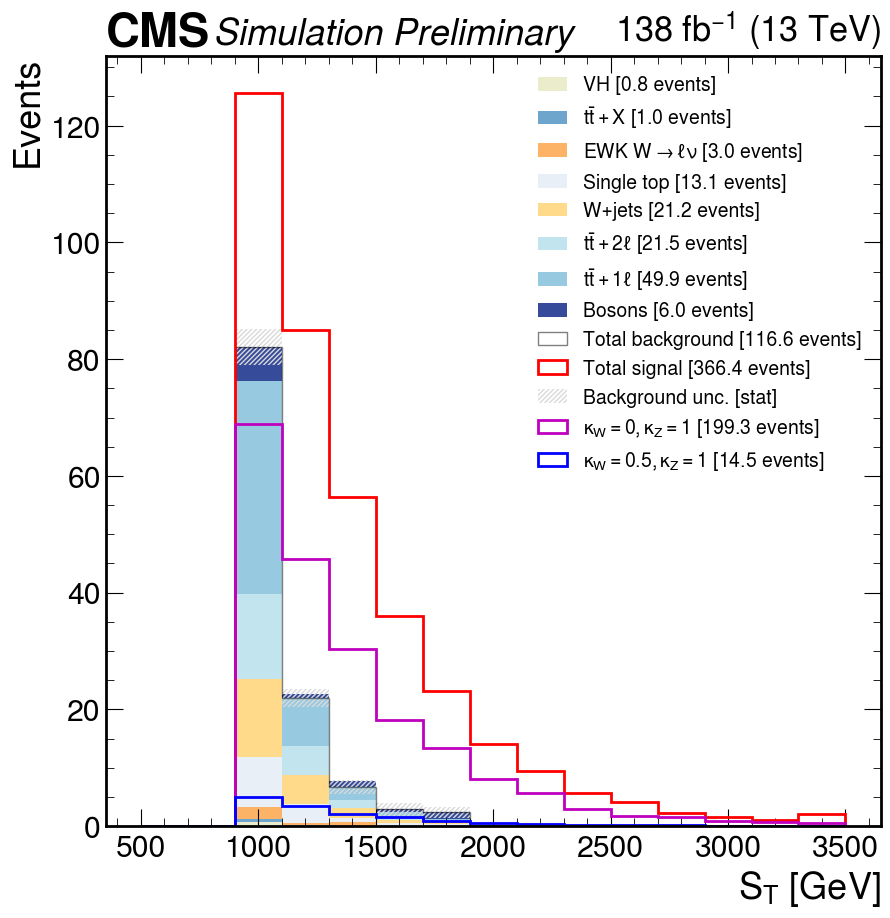

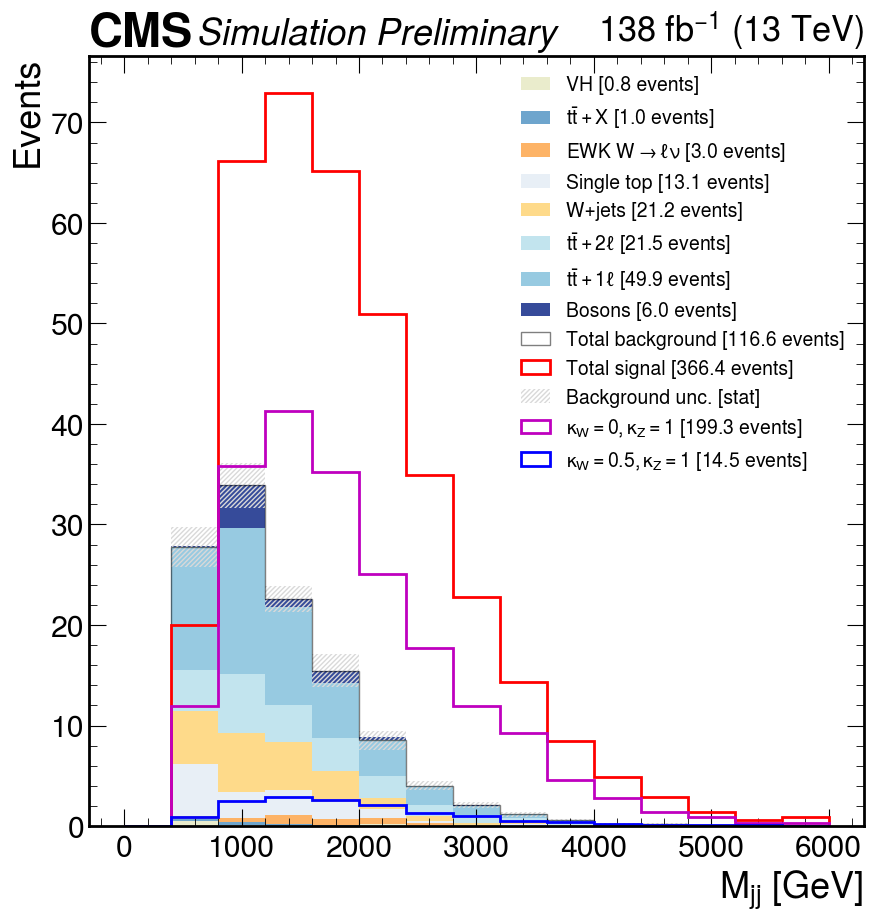

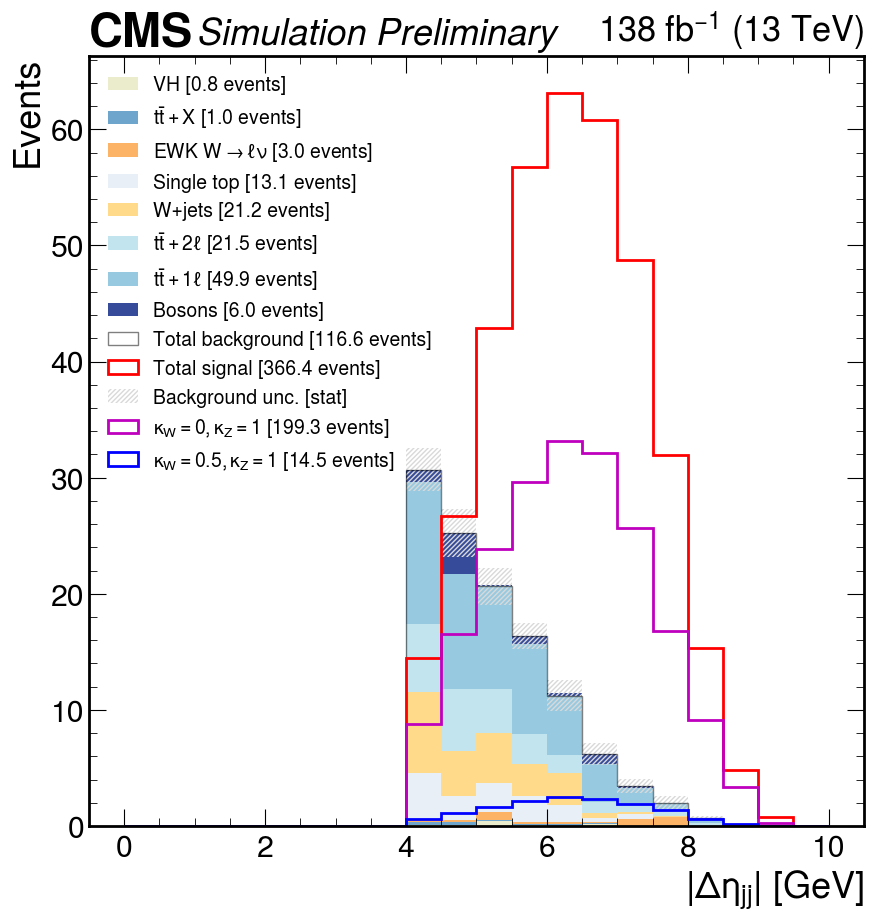

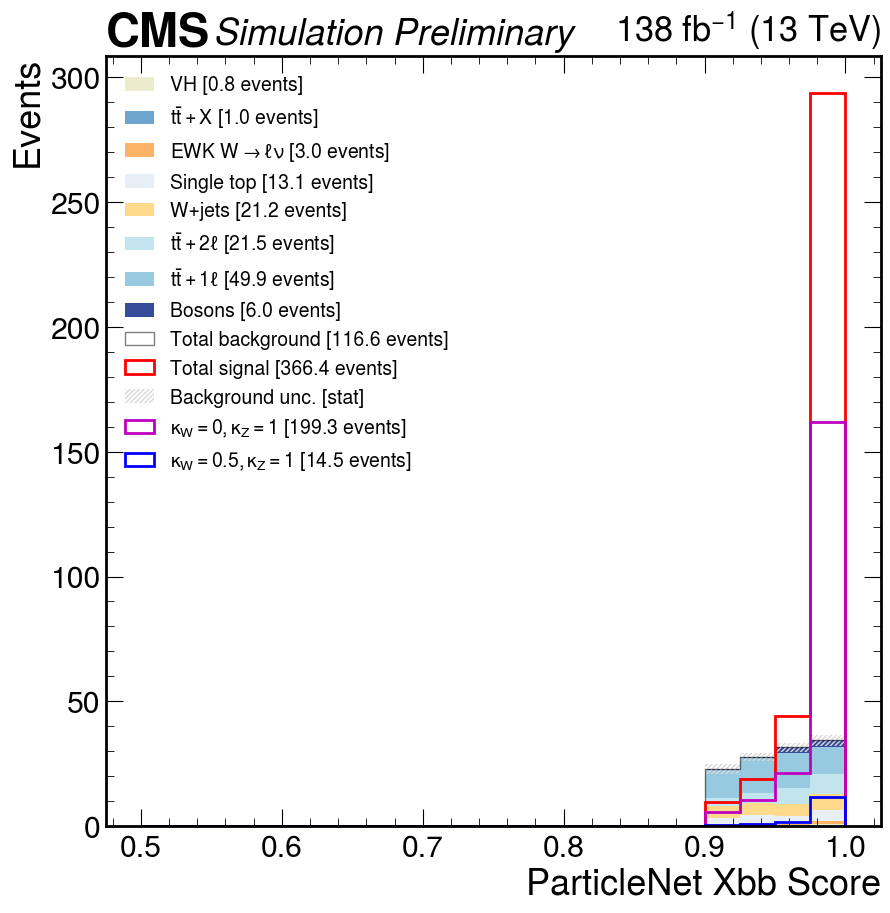

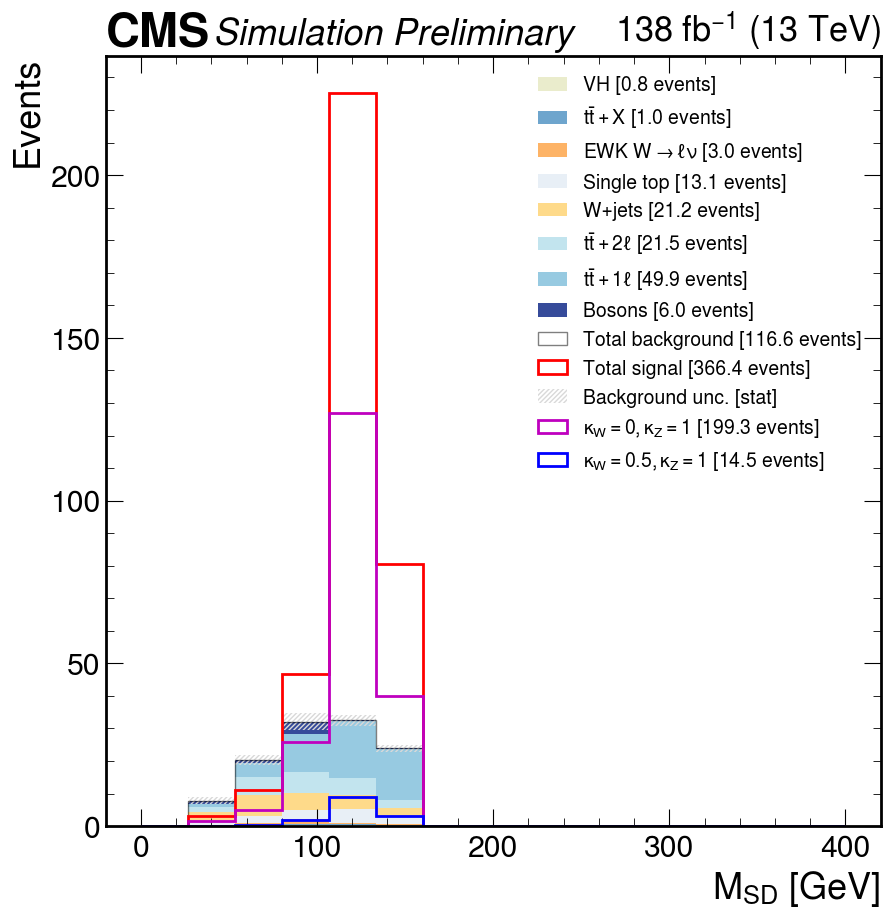

In [7]:
vbswh.df["event_weight"] = ORIG_EVENT_WEIGHTS*vbswh.df.xbb_sf

nSR1 = vbswh_negLambda.df.SR1
pSR1 = vbswh_posLambda.df.SR1

# Reweights (transposed) negLambda indices
# 14:  kW = 0.0, kZ = -1
# 315: kW = 0.0, kZ = +1

# Reweights (transposed) posLambda indices
# 115: kW = +0.5, kZ = +1

axes = vbswh.plot_sig_vs_bkg(
    "ST", np.linspace(500, 3500, 16), selection="SR1", x_label="$S_T$ [GeV]", 
    stacked=True, logy=False
);
add_more_kappas_SR1(axes, "ST", np.linspace(500, 3500, 16))


axes = vbswh.plot_sig_vs_bkg(
    "M_jj", np.linspace(0, 6000, 16), selection="SR1", x_label="$M_{jj}$ [GeV]",
    stacked=True, logy=False
);
add_more_kappas_SR1(axes, "M_jj", np.linspace(0, 6000, 16))

axes = vbswh.plot_sig_vs_bkg(
    "abs_deta_jj", np.linspace(0, 10, 21), selection="SR1", x_label="$|\Delta\eta_{jj}|$ [GeV]",
    stacked=True, logy=False, legend_loc="upper left"
);
add_more_kappas_SR1(axes, "abs_deta_jj", np.linspace(0, 10, 21), legend_loc="upper left")

axes = vbswh.plot_sig_vs_bkg(
    "hbbjet_score", np.linspace(0.5, 1, 21), selection="SR1", x_label="ParticleNet Xbb Score",
    stacked=True, legend_loc="upper left"
);
add_more_kappas_SR1(axes, "hbbjet_score", np.linspace(0.5, 1, 21), legend_loc="upper left")

axes = vbswh.plot_sig_vs_bkg(
    "hbbjet_msoftdrop", np.linspace(0, 400, 16), selection="SR1", x_label="$M_{SD}$ [GeV]",
    stacked=True,
);
add_more_kappas_SR1(axes, "hbbjet_msoftdrop", np.linspace(0, 400, 16))

vbswh.df["event_weight"] = ORIG_EVENT_WEIGHTS

In [8]:
import math

vbswh_sm = Optimization(
    sig_root_files=[baby for baby in babies if "VBSWH_SM" in baby],
    ttree_name="tree",
    weight_columns=[
        "xsec_sf", "lep_id_sf", "ewkfix_sf", 
        "elec_reco_sf", "muon_iso_sf", 
        "light_btag_sf", "bc_btag_sf",
        "pu_sf", "prefire_sf", "trig_sf", "puid_sf"
    ],
    plots_dir=PLOTSDIR,
    reweight_column="reweights"
)
vbswh_sm.df["presel_noDetaJJ"] = vbswh_sm.df.eval(
    "passes_bveto and M_jj > 500 and hbbjet_score > 0.3"
)

ORIG_EVENT_WEIGHTS = vbswh.df.event_weight.values.copy()

def two_sig_figs(number):
    if number > 1000:
        return str(round(number/1000, 1))+"K"
    elif number > 100:
        return str(round(number))
    elif number > 10:
        return str(round(number))
    else:
        return str(round(number, 1))

def print_cutflow_tex(cuts, samples):
    print(f"\\begin{{tabular}}{{c{'rCl'*len(samples)}}}".replace("C", "@{\hskip3pt}c@{\hskip3pt}"))
    print("\\hline")
    print("\\hline")

    L1 = max([len(n) for n, _ in cuts]) # Length of longest cut LaTeX

    row = [f"{'Cut':^{L1}}"]
    for sample in samples:
        if sample == "bkg":
            sample_tex = "Total bkg."
        elif sample == "sig":
            sample_tex = "Total sig."
        elif sample == "VBSWH_SM":
            sample_tex = "SM VBS WH"
        else:
            sample_tex = vbswh.sample_labels.get(sample, sample)
        row.append(f"\\multicolumn{{3}}{{c}}{{{sample_tex}}}")

    L2s = [len(c) for c in row[1:]]     # Lengths of sample header LaTeX

    print(" & ".join(row)+" \\\\")
    print("\\hline")

    row = []
    prev_cut_sels = ""
    for cut_i, (cut_name, cut_sel) in enumerate(cuts):
        row.append(f"{cut_name:^{L1}}")
        if cut_sel == "hbbjet_score > 0.9" and "sig" in samples:
            vbswh.df["event_weight"] = ORIG_EVENT_WEIGHTS*vbswh.df.xbb_sf
        for sample_i, sample in enumerate(samples):
            L2 = L2s[sample_i]
            if sample == "bkg":
                count = vbswh.bkg_count(selection=cut_sel+prev_cut_sels)
                error = vbswh.bkg_error(selection=cut_sel+prev_cut_sels)
            elif sample == "sig":
                count = vbswh.sig_count(selection=cut_sel+prev_cut_sels)
                error = vbswh.sig_error(selection=cut_sel+prev_cut_sels)
            elif sample == "VBSWH_SM":
                count = vbswh_sm.sig_count(selection=cut_sel+prev_cut_sels)
                error = vbswh_sm.sig_error(selection=cut_sel+prev_cut_sels)
            else:
                count = vbswh.sample_count(sample, selection=cut_sel+prev_cut_sels)
                error = vbswh.sample_error(sample, selection=cut_sel+prev_cut_sels)
            if error >= 0.1:
                col = f"{two_sig_figs(count)} & $\pm$ & {error:.1f}"
            else:
                col = f"{two_sig_figs(count)} & $\pm$ & {error:.2f}"
            row.append(f"{col:^{L2}}")

        print(" & ".join(row)+" \\\\")
        prev_cut_sels += f" and {cut_sel}"
        row = []
        
    if "sig" in samples:
        vbswh.df["event_weight"] = ORIG_EVENT_WEIGHTS

    print("\\hline")
    print("\\hline")
    print("\\end{tabular}")

Loading sig babies: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.42it/s]


In [9]:
cuts = [
    ("Preselection", "presel_noDetaJJ"),
    ("$\Mjj > 600 \GeV$", "M_jj > 600"),
    ("$\ST > 900 \GeV$", "ST > 900"),
    ("ParticleNet Xbb $ > 0.9$", "hbbjet_score > 0.9"),
    ("$|\detajj| > 4$", "abs_deta_jj > 4"),
    ("$\MSD < 150 \GeV$", "hbbjet_msoftdrop < 150")
]

print_cutflow_tex(cuts, ["Bosons", "WJets", "SingleTop", "TTbar1L", "TTbar2L"])

print("\\newline")
print("\\vspace{1em}")
print("\\newline")

print_cutflow_tex(cuts, ["bkg", "sig", "VBSWH_SM"])

\begin{tabular}{cr@{\hskip3pt}c@{\hskip3pt}lr@{\hskip3pt}c@{\hskip3pt}lr@{\hskip3pt}c@{\hskip3pt}lr@{\hskip3pt}c@{\hskip3pt}lr@{\hskip3pt}c@{\hskip3pt}l}
\hline
\hline
          Cut            & \multicolumn{3}{c}{Bosons} & \multicolumn{3}{c}{W+jets} & \multicolumn{3}{c}{Single top} & \multicolumn{3}{c}{$t\bar{t}+1\ell$} & \multicolumn{3}{c}{$t\bar{t}+2\ell$} \\
\hline
      Preselection       &     369 & $\pm$ & 18.1     &     1.0K & $\pm$ & 6.8     &       323 & $\pm$ & 6.8        &         2.7K & $\pm$ & 11.6          &          351 & $\pm$ & 3.7           \\
   $\Mjj > 600 \GeV$     &     301 & $\pm$ & 16.7     &     801 & $\pm$ & 5.8      &       259 & $\pm$ & 6.1        &         2.2K & $\pm$ & 10.4          &          294 & $\pm$ & 3.4           \\
    $\ST > 900 \GeV$     &     194 & $\pm$ & 13.3     &     527 & $\pm$ & 4.3      &       177 & $\pm$ & 5.1        &          1.2K & $\pm$ & 7.8          &          170 & $\pm$ & 2.6           \\
ParticleNet Xbb $ > 0.9$ &      37 & 

In [10]:
vbswh.sample_labels["EWKWLep"] = "EWK W"

cuts = [
    ("Preselection", "presel_noDetaJJ"),
    ("$\Mjj > 600 \GeV$", "M_jj > 600"),
    ("$\ST > 900 \GeV$", "ST > 900"),
    ("ParticleNet Xbb $ > 0.9$", "hbbjet_score > 0.9"),
    ("$|\detajj| > 4$", "abs_deta_jj > 4"),
    ("$\MSD < 150 \GeV$", "hbbjet_msoftdrop < 150")
]

print("\\begin{tiny}")
print_cutflow_tex(cuts, ["VH", "EWKWLep", "Bosons", "WJets", "SingleTop", "TTX", "TTbar1L", "TTbar2L", "bkg"])
print("\\end{tiny}")

vbswh.sample_labels["EWKWLep"] = r"EWK W$\rightarrow\ell\nu$"

\begin{tiny}
\begin{tabular}{cr@{\hskip3pt}c@{\hskip3pt}lr@{\hskip3pt}c@{\hskip3pt}lr@{\hskip3pt}c@{\hskip3pt}lr@{\hskip3pt}c@{\hskip3pt}lr@{\hskip3pt}c@{\hskip3pt}lr@{\hskip3pt}c@{\hskip3pt}lr@{\hskip3pt}c@{\hskip3pt}lr@{\hskip3pt}c@{\hskip3pt}lr@{\hskip3pt}c@{\hskip3pt}l}
\hline
\hline
          Cut            & \multicolumn{3}{c}{VH} & \multicolumn{3}{c}{EWK W} & \multicolumn{3}{c}{Bosons} & \multicolumn{3}{c}{W+jets} & \multicolumn{3}{c}{Single top} & \multicolumn{3}{c}{$t\bar{t}+X$} & \multicolumn{3}{c}{$t\bar{t}+1\ell$} & \multicolumn{3}{c}{$t\bar{t}+2\ell$} & \multicolumn{3}{c}{Total bkg.} \\
\hline
      Preselection       &   5.4 & $\pm$ & 1.1    &     71 & $\pm$ & 4.9      &     369 & $\pm$ & 18.1     &     1.0K & $\pm$ & 6.8     &       323 & $\pm$ & 6.8        &         45 & $\pm$ & 0.8         &         2.7K & $\pm$ & 11.6          &          351 & $\pm$ & 3.7           &      4.9K & $\pm$ & 24.4       \\
   $\Mjj > 600 \GeV$     &   4.0 & $\pm$ & 1.0    &     58 & $\pm$ &

In [11]:
sig_SR_df = vbswh.sig_df(selection="SR1")

print("number of events w/ same-sign eta")
vbs_samesign_eta = sig_SR_df.ld_vbsjet_eta*sig_SR_df.tr_vbsjet_eta > 0
print(np.sum(vbs_samesign_eta), "(raw)")
print(np.sum(sig_SR_df[vbs_samesign_eta].event_weight*sig_SR_df[vbs_samesign_eta].xbb_sf), "(wgt)")

print("number of events w/ opposite-sign eta")
print(np.sum(~vbs_samesign_eta), "(raw)")
print(np.sum(sig_SR_df[~vbs_samesign_eta].event_weight*sig_SR_df[~vbs_samesign_eta].xbb_sf), "(wgt)")

print("number of edge case events where ld vbs jet eta == 0")
print(np.sum(sig_SR_df.ld_vbsjet_eta == 0))
print("number of edge case events where tr vbs jet eta == 0")
print(np.sum(sig_SR_df.tr_vbsjet_eta == 0))

number of events w/ same-sign eta
5 (raw)
0.14021184917886342 (wgt)
number of events w/ opposite-sign eta
21111 (raw)
366.25270286410813 (wgt)
number of edge case events where ld vbs jet eta == 0
0
number of edge case events where tr vbs jet eta == 0
0


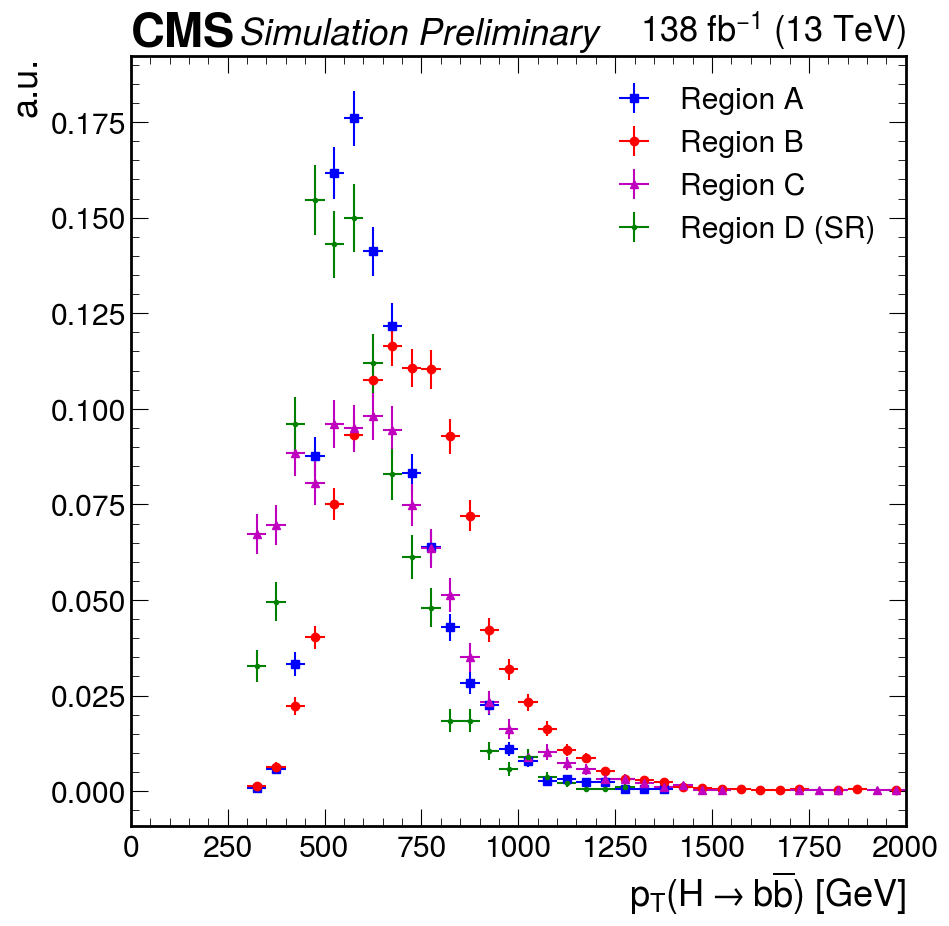

In [12]:
bins = np.linspace(0, 2000, 41)

fig, axes = plt.subplots()

ttbar_df = vbswh.bkg_df(selection="name == 'TTbar1L' or name == 'TTbar2L'")

regionA_hist = yahist.Hist1D(
    ttbar_df[ttbar_df.regionA].hbbjet_pt.values,
    bins=bins,
    color="b",
    label="Region A"
).normalize()
regionA_hist.plot(ax=axes, errors=True, fmt="s")

regionB_hist = yahist.Hist1D(
    ttbar_df[ttbar_df.regionB].hbbjet_pt.values,
    bins=bins,
    color="r",
    label="Region B"
).normalize()
regionB_hist.plot(ax=axes, errors=True, fmt="o")

regionC_hist = yahist.Hist1D(
    ttbar_df[ttbar_df.regionC].hbbjet_pt.values,
    bins=bins,
    color="m",
    label="Region C"
).normalize()
regionC_hist.plot(ax=axes, errors=True, fmt="^")

regionD_hist = yahist.Hist1D(
    ttbar_df[ttbar_df.SR1].hbbjet_pt.values,
    bins=bins,
    color="g",
    label="Region D (SR)"
).normalize()
regionD_hist.plot(ax=axes, errors=True, fmt=".")

hep.cms.label("Preliminary", data=False, lumi=138, loc=0, ax=axes)

axes.set_ylabel("a.u.");
axes.set_xlabel(r"$p_T(H\rightarrow b\overline{b})$ [GeV]");

In [13]:
def plot_overlays(sample_pairs, selection, column, bins, outname, title=None, xlabel=None):
    for sample1, sample2 in sample_pairs:
        fig = plt.figure()
        gs = gridspec.GridSpec(ncols=1, nrows=2, figure=fig, height_ratios=[2, 0.65], hspace=0.1)
        hist_axes = fig.add_subplot(gs[0])
        ratio_axes = fig.add_subplot(gs[1])
        
        df1 = vbswh.sample_df(sample1, selection=selection)
        df2 = vbswh.sample_df(sample2, selection=selection)
        label1 = vbswh.sample_labels.get(sample1, sample1)
        label2 = vbswh.sample_labels.get(sample2, sample2)
        
        hist1 = yahist.Hist1D(
            np.abs(df1[column].values),
            bins=bins,
            color=vbswh.bkg_colors[sample1],
            label=label1
        ).normalize()
        hist2 = yahist.Hist1D(
            np.abs(df2[column].values),
            bins=bins,
            color=vbswh.bkg_colors[sample2],
            label=label2
        ).normalize()
        
        ratio_hist = hist1/hist2
        ratio_label = r"LABEL1/LABEL2".replace("LABEL1", label1).replace("LABEL2", label2)

        hist1.plot(ax=hist_axes, errors=True, fmt="o", zorder=100)
        hist2.plot(ax=hist_axes, errors=True, fmt="^", zorder=101)
        (ratio_hist).plot(ax=ratio_axes, errors=True, color="k", label=ratio_label)

        hist_axes.set_xticklabels([]);
        hist_axes.set_ylabel("a.u.")
        hist_axes.set_title(title);
        hist_axes.set_ylim([0, 0.4])

        ratio_axes.axhline(y=1, color="k", linestyle="--", alpha=0.75, linewidth=0.75)
        ratio_axes.legend().remove()
        ratio_axes.set_ylabel(ratio_label)
        ratio_axes.set_xlabel(xlabel);
        ratio_axes.set_ylim([0, 2])

        plot_file = f"/home/users/jguiang/public_html/vbswh_plots/{TAG}/opt/{outname}_{sample1}_vs_{sample2}.pdf"
        plt.savefig(plot_file, bbox_inches="tight")
        print(f"Wrote {plot_file}")
#         plt.close()

Wrote /home/users/jguiang/public_html/vbswh_plots/btagsf_fix/opt/AB_Bosons_vs_TTbar1L.pdf
Wrote /home/users/jguiang/public_html/vbswh_plots/btagsf_fix/opt/AB_WJets_vs_TTbar1L.pdf
Wrote /home/users/jguiang/public_html/vbswh_plots/btagsf_fix/opt/AB_SingleTop_vs_TTbar1L.pdf
Wrote /home/users/jguiang/public_html/vbswh_plots/btagsf_fix/opt/AB_TTbar2L_vs_TTbar1L.pdf


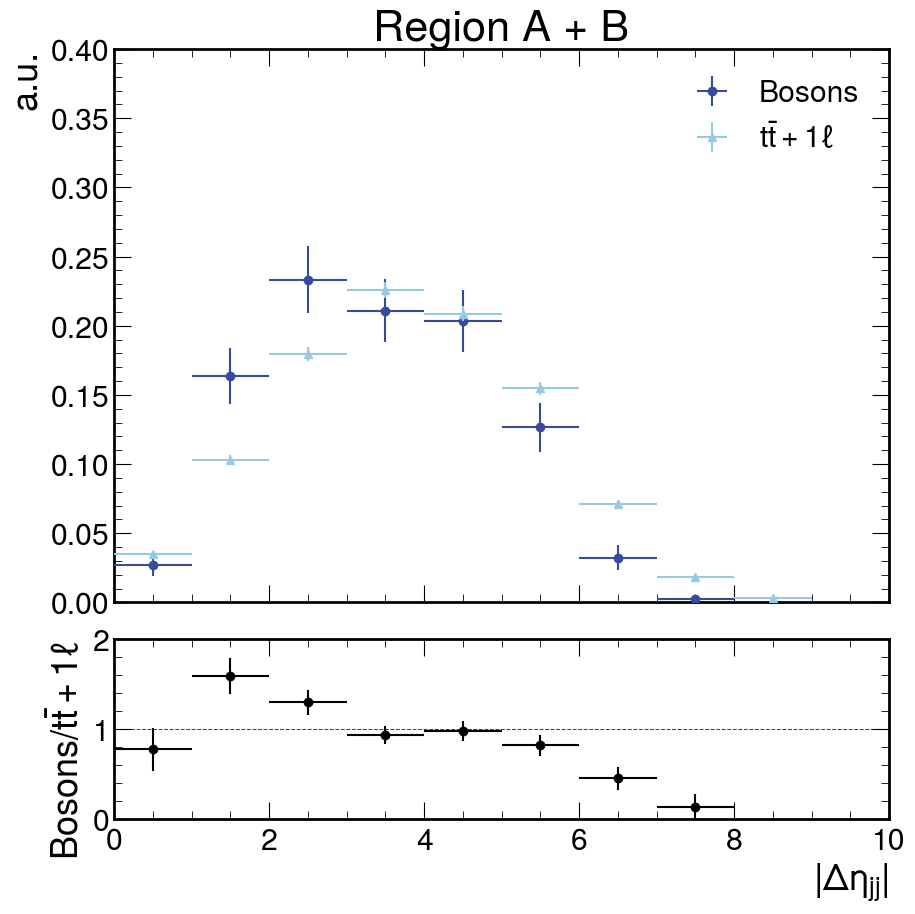

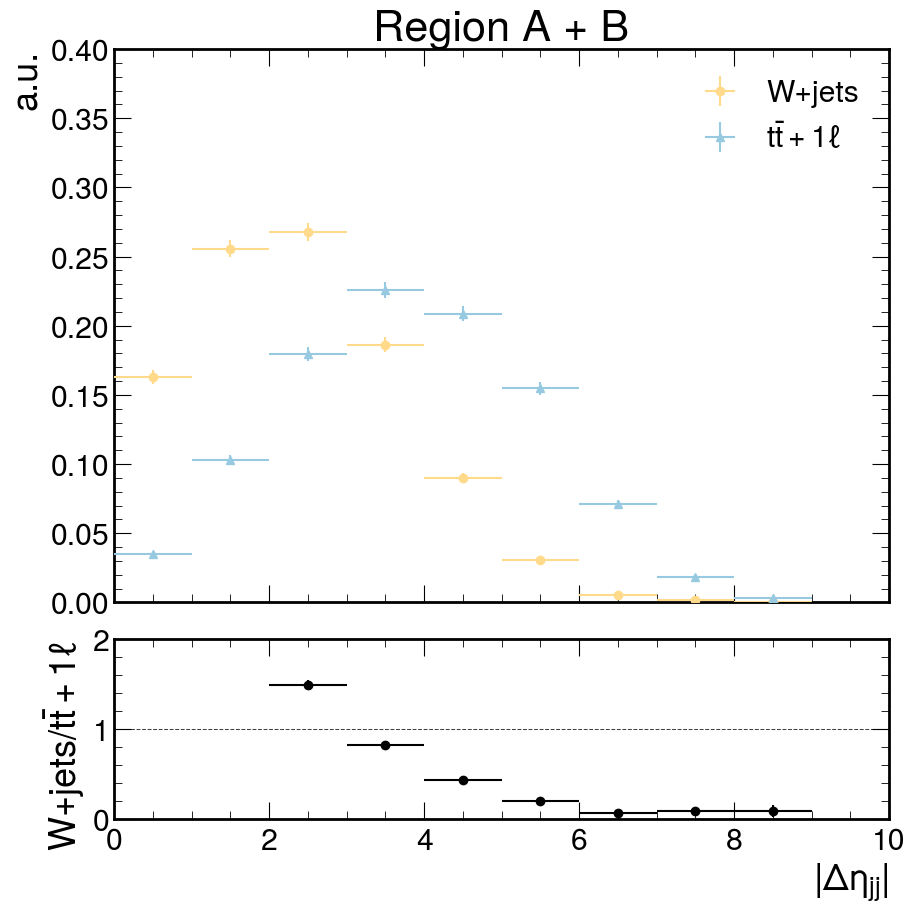

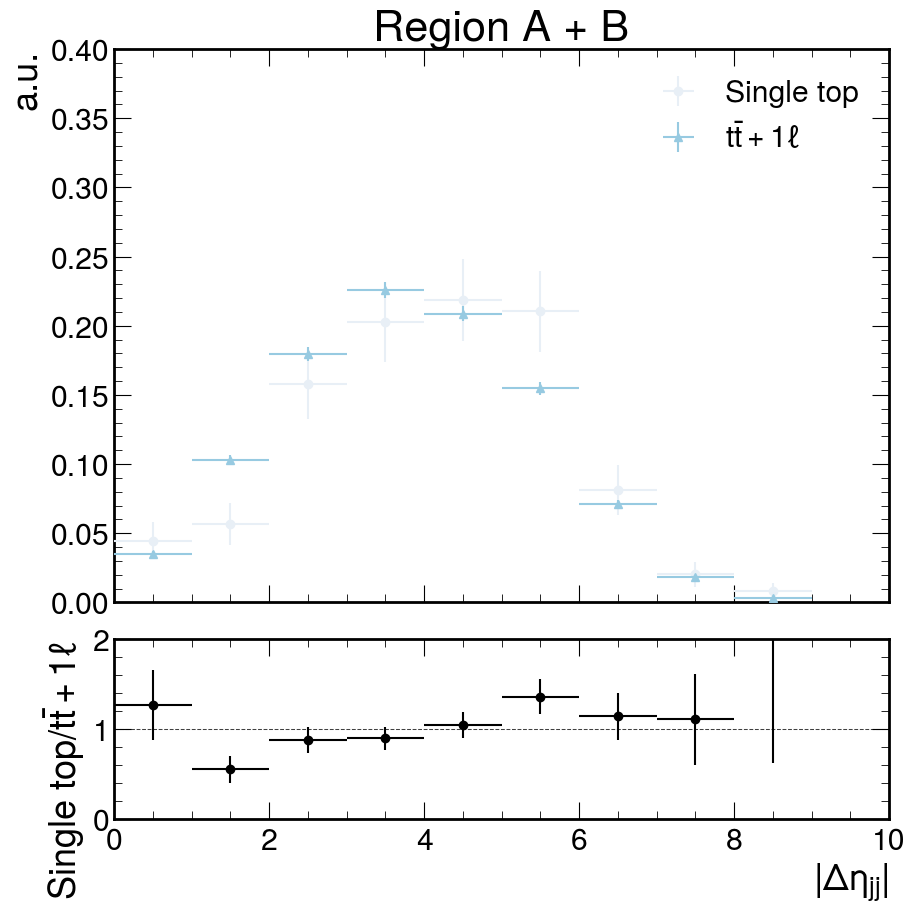

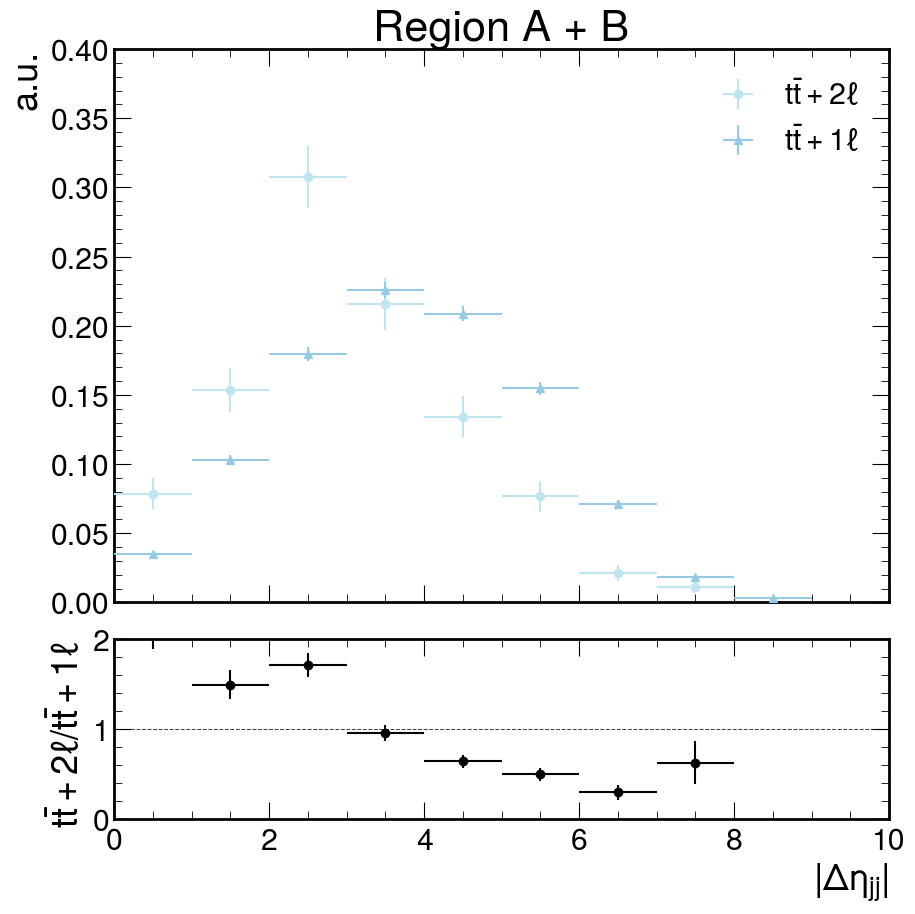

In [14]:
plot_overlays(
    [("Bosons", "TTbar1L"), ("WJets", "TTbar1L"), ("SingleTop", "TTbar1L"), ("TTbar2L", "TTbar1L")], 
    "(regionA or regionB)", 
    "abs_deta_jj", 
    np.linspace(0, 10, 11), 
    "AB",
    title="Region A + B",
    xlabel=r"$|\Delta\eta_{jj}|$"
)

Wrote /home/users/jguiang/public_html/vbswh_plots/btagsf_fix/opt/CD_Bosons_vs_TTbar1L.pdf
Wrote /home/users/jguiang/public_html/vbswh_plots/btagsf_fix/opt/CD_WJets_vs_TTbar1L.pdf
Wrote /home/users/jguiang/public_html/vbswh_plots/btagsf_fix/opt/CD_SingleTop_vs_TTbar1L.pdf
Wrote /home/users/jguiang/public_html/vbswh_plots/btagsf_fix/opt/CD_TTbar2L_vs_TTbar1L.pdf


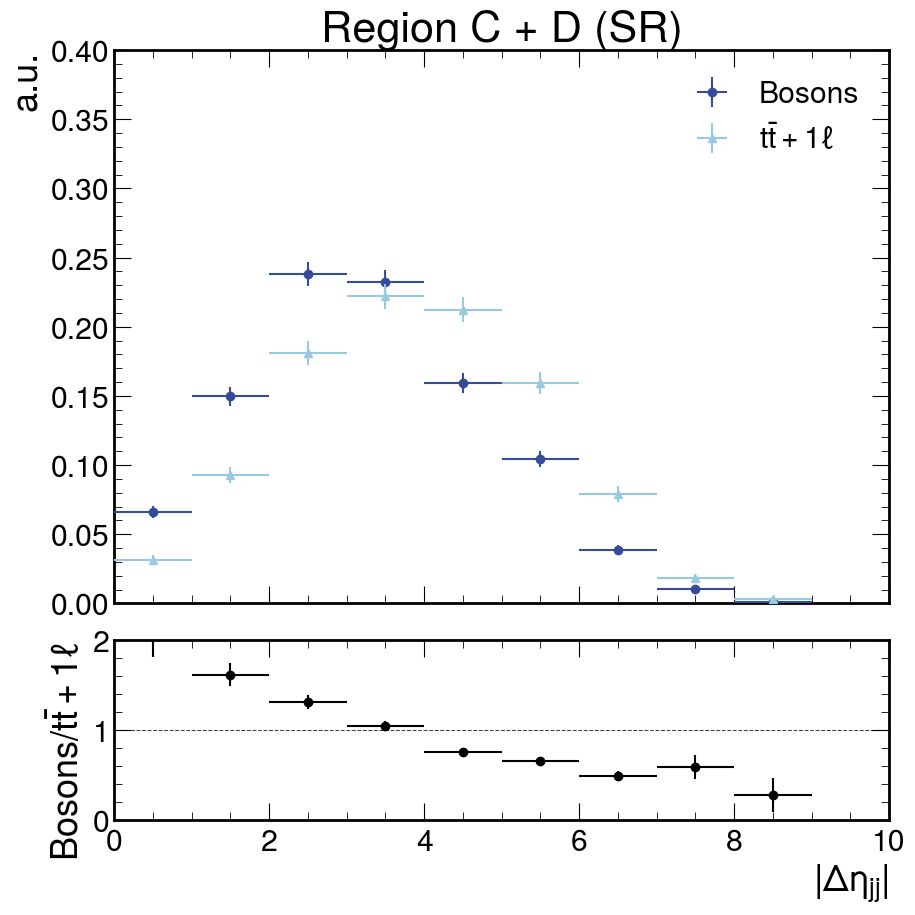

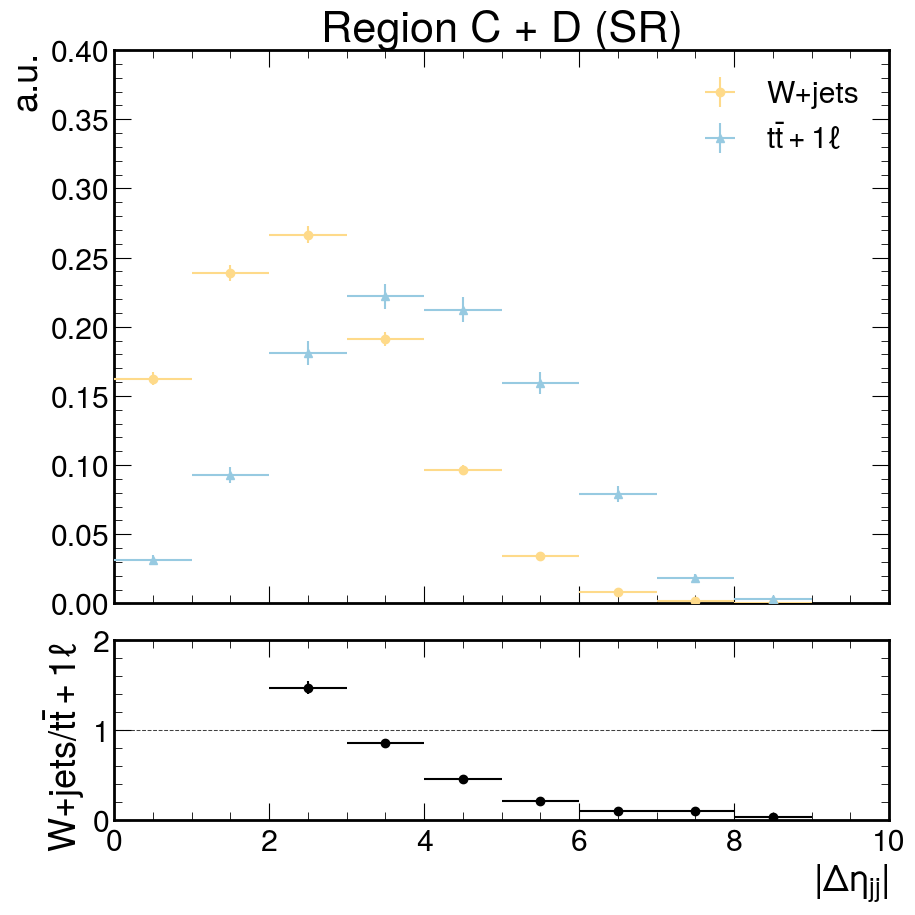

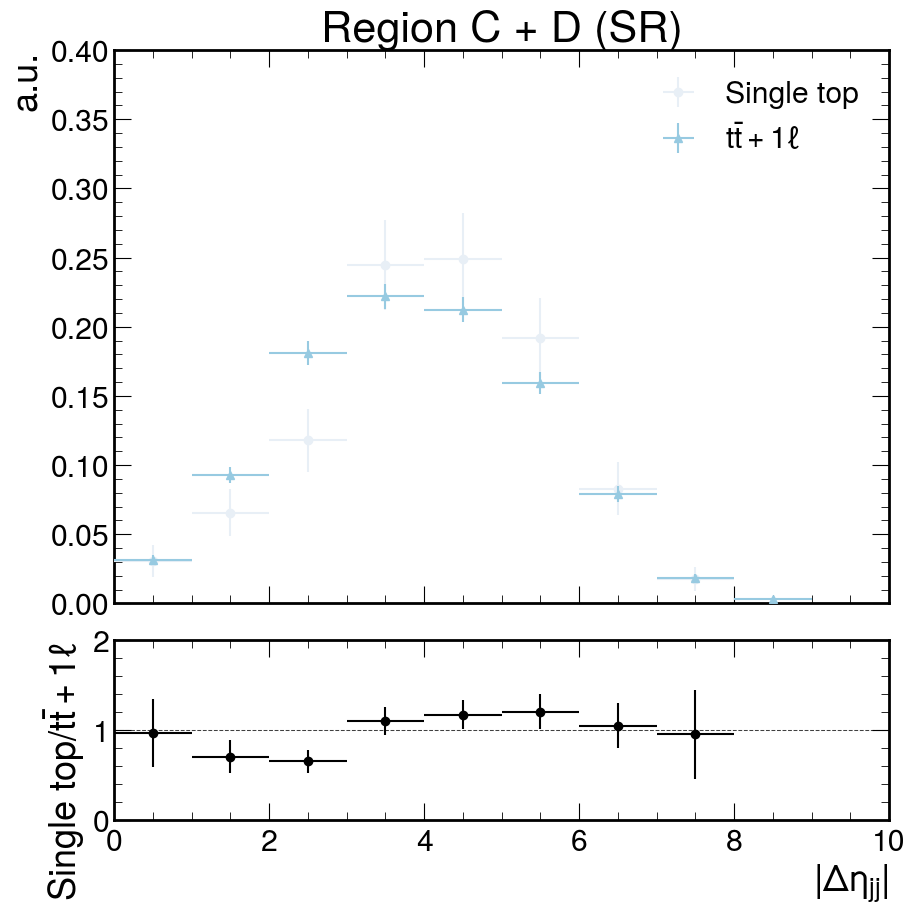

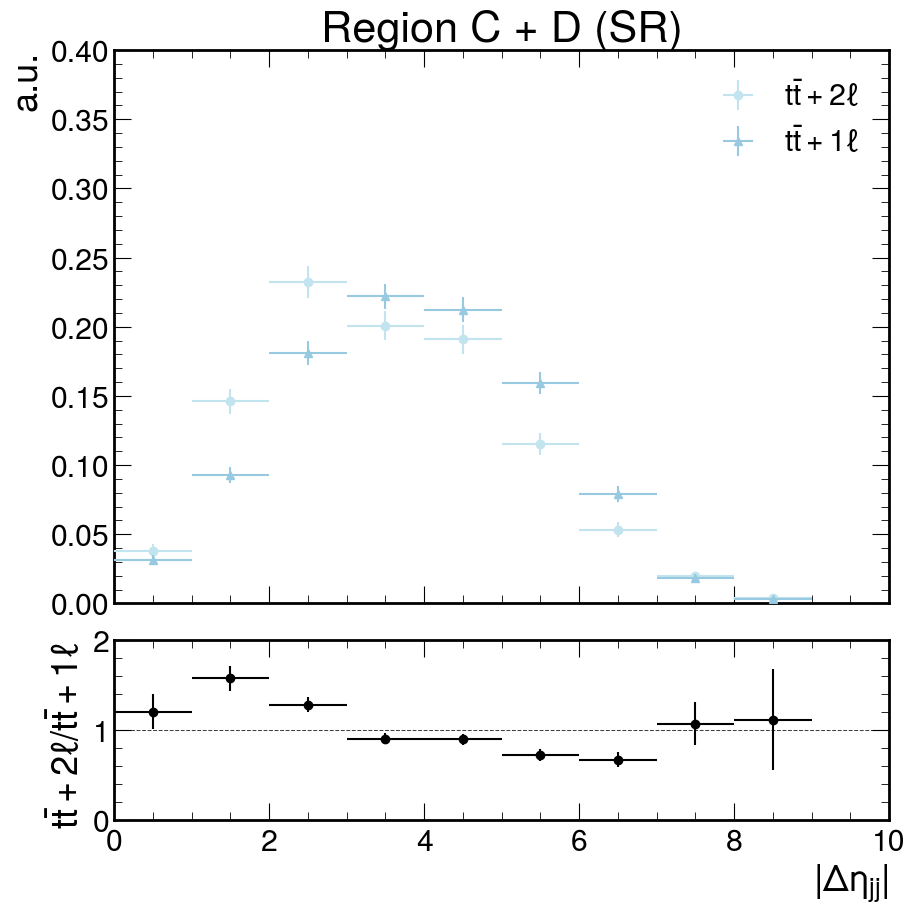

In [15]:
plot_overlays(
    [("Bosons", "TTbar1L"), ("WJets", "TTbar1L"), ("SingleTop", "TTbar1L"), ("TTbar2L", "TTbar1L")], 
    "(regionC or SR1)", 
    "abs_deta_jj", 
    np.linspace(0, 10, 11), 
    "CD",
    title="Region C + D (SR)",
    xlabel=r"$|\Delta\eta_{jj}|$"
)

In [16]:
# selection = "(regionA or regionB)"
# bins = np.linspace(0, 10, 11)

# fig = plt.figure()
# gs = gridspec.GridSpec(ncols=1, nrows=2, figure=fig, height_ratios=[2, 0.65], hspace=0.1)
# hist_axes = fig.add_subplot(gs[0])
# ratio_axes = fig.add_subplot(gs[1])


# tt1l_df = vbswh.sample_df("TTbar1L", selection=selection)
# tt2l_df = vbswh.sample_df("TTbar2L", selection=selection)
# wjets_df = vbswh.sample_df("WJets", selection=selection)
# bosons_df = vbswh.sample_df("Bosons", selection=selection)
# st_df = vbswh.sample_df("SingleTop", selection=selection)

# st_hist = yahist.Hist1D(
#     np.abs(st_df.deta_jj.values),
#     bins=bins,
#     color=vbswh.bkg_colors["SingleTop"],
#     label="Single top"
# ).normalize()
# bosons_hist = yahist.Hist1D(
#     np.abs(bosons_df.deta_jj.values),
#     bins=bins,
#     color=vbswh.bkg_colors["Bosons"],
#     label="Bosons"
# ).normalize()
# tt1l_hist = yahist.Hist1D(
#     np.abs(tt1l_df.deta_jj.values),
#     bins=bins,
#     color=vbswh.bkg_colors["TTbar1L"],
#     label=r"$t\bar{t}+1\ell$"
# ).normalize()
# tt2l_hist = yahist.Hist1D(
#     np.abs(tt2l_df.deta_jj.values),
#     bins=bins,
#     color=vbswh.bkg_colors["TTbar2L"],
#     label=r"$t\bar{t}+2\ell$"
# ).normalize()
# wjets_hist = yahist.Hist1D(
#     np.abs(wjets_df.deta_jj.values),
#     bins=bins,
#     color=vbswh.bkg_colors["WJets"],
#     label="W+jets"
# ).normalize()
# ratio_hist = tt1l_hist/tt2l_hist

# bosons_hist.plot(ax=hist_axes, errors=True, fmt="s", zorder=100)
# wjets_hist.plot(ax=hist_axes, errors=True, fmt="o", zorder=101)
# st_hist.plot(ax=hist_axes, errors=True, fmt="v", zorder=102)
# tt2l_hist.plot(ax=hist_axes, errors=True, fmt="^", zorder=103)
# tt1l_hist.plot(ax=hist_axes, errors=True, fmt=".", zorder=104)
# (tt2l_hist/tt1l_hist).plot(ax=ratio_axes, errors=True, color="k", label=r"$t\bar{t}+2\ell/t\bar{t}+1\ell$")
# (wjets_hist/tt1l_hist).plot(ax=ratio_axes, errors=True, color="grey", label=r"W+jets$/t\bar{t}+1\ell$")

# hist_axes.set_xticklabels([]);
# hist_axes.set_ylabel("a.u.")
# hist_axes.set_title("Region A + Region B");

# ratio_axes.axhline(y=1, color="k", linestyle="--", alpha=0.75, linewidth=0.75)
# # ratio_axes.legend().remove()
# ratio_axes.set_ylabel("Ratio");
# ratio_axes.set_xlabel(r"$|\Delta\eta_{jj}|$");

# plot_file = f"/home/users/jguiang/public_html/vbswh_plots/{TAG}/opt/AB_wjets_vs_ttbar.pdf"
# plt.savefig(plot_file, bbox_inches="tight")

In [17]:
# selection = "(regionC or SR1)"
# bins = np.linspace(0, 10, 11)

# fig = plt.figure()
# gs = gridspec.GridSpec(ncols=1, nrows=2, figure=fig, height_ratios=[2, 0.65], hspace=0.1)
# hist_axes = fig.add_subplot(gs[0])
# ratio_axes = fig.add_subplot(gs[1])


# tt1l_df = vbswh.bkg_df(selection=f"{selection} and name == 'TTbar1L'")
# tt2l_df = vbswh.bkg_df(selection=f"{selection} and name == 'TTbar2L'")
# wjets_df = vbswh.bkg_df(selection=f"{selection} and name == 'WJets'")

# tt1l_hist = yahist.Hist1D(
#     np.abs(tt1l_df.deta_jj.values),
#     bins=bins,
#     color="b",
#     label=r"$t\bar{t}+1\ell$"
# ).normalize()
# tt2l_hist = yahist.Hist1D(
#     np.abs(tt2l_df.deta_jj.values),
#     bins=bins,
#     color="r",
#     label=r"$t\bar{t}+2\ell$"
# ).normalize()
# wjets_hist = yahist.Hist1D(
#     np.abs(wjets_df.deta_jj.values),
#     bins=bins,
#     color="m",
#     label="W+jets"
# ).normalize()
# ratio_hist = tt1l_hist/tt2l_hist

# tt2l_hist.plot(ax=hist_axes, errors=True)
# tt1l_hist.plot(ax=hist_axes, errors=True)
# wjets_hist.plot(ax=hist_axes, errors=True)
# (tt2l_hist/tt1l_hist).plot(ax=ratio_axes, errors=True, color="k", label=r"$t\bar{t}+2\ell/t\bar{t}+1\ell$")
# (wjets_hist/tt1l_hist).plot(ax=ratio_axes, errors=True, color="grey", label=r"W+jets$/t\bar{t}+1\ell$")

# hist_axes.set_xticklabels([]);
# hist_axes.set_ylabel("a.u.")
# hist_axes.set_title("Region C + Region D (SR)");

# ratio_axes.axhline(y=1, color="k", linestyle="--", alpha=0.75, linewidth=0.75)
# # ratio_axes.legend().remove()
# ratio_axes.set_ylabel("Ratio");
# ratio_axes.set_xlabel(r"$|\Delta\eta_{jj}|$");

# plot_file = f"/home/users/jguiang/public_html/vbswh_plots/{TAG}/opt/CD_wjets_vs_ttbar.pdf"
# plt.savefig(plot_file, bbox_inches="tight")

Wrote plot to /home/users/jguiang/public_html/vbswh_plots/btagsf_fix/opt/LT_sig_vs_bkg_stacked_logy_presel_noDetaJJ.pdf


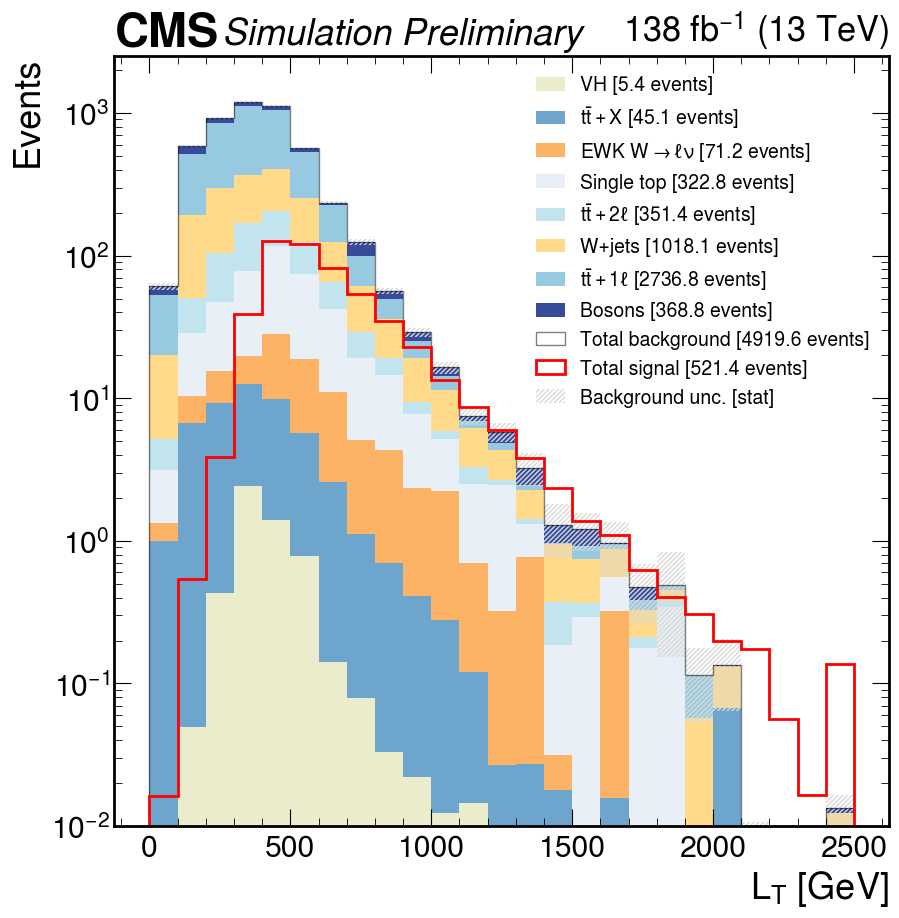

In [18]:
axes = vbswh.plot_sig_vs_bkg(
    "LT", np.linspace(0, 2500, 26), 
    selection="presel_noDetaJJ",
    x_label="$L_T$ [GeV]",
    stacked=True,
    logy=True
);

Wrote plot to /home/users/jguiang/public_html/vbswh_plots/btagsf_fix/opt/LT_sig_vs_bkg_stacked_presel_noDetaJJ.pdf


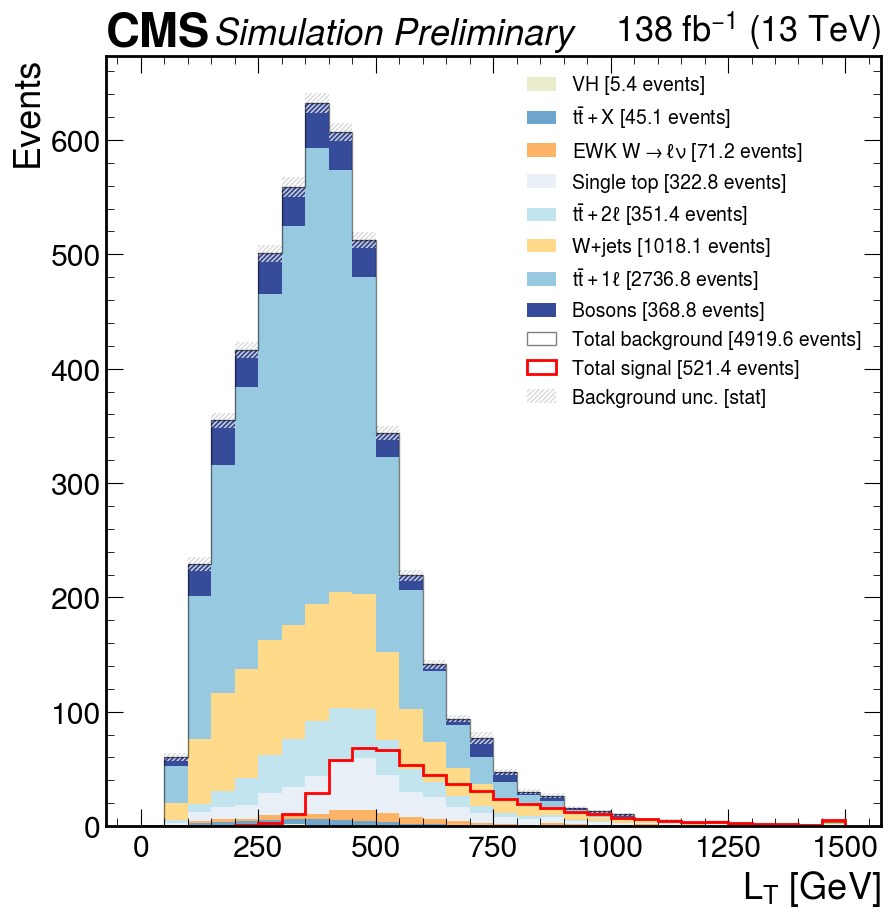

In [19]:
axes = vbswh.plot_sig_vs_bkg(
    "LT", np.linspace(0, 1500, 31), 
    selection="presel_noDetaJJ",
    x_label="$L_T$ [GeV]",
    stacked=True,
#     norm=True
);

Wrote plot to /home/users/jguiang/public_html/vbswh_plots/btagsf_fix/opt/MET_sig_vs_bkg_stacked_logy_presel_noDetaJJ.pdf


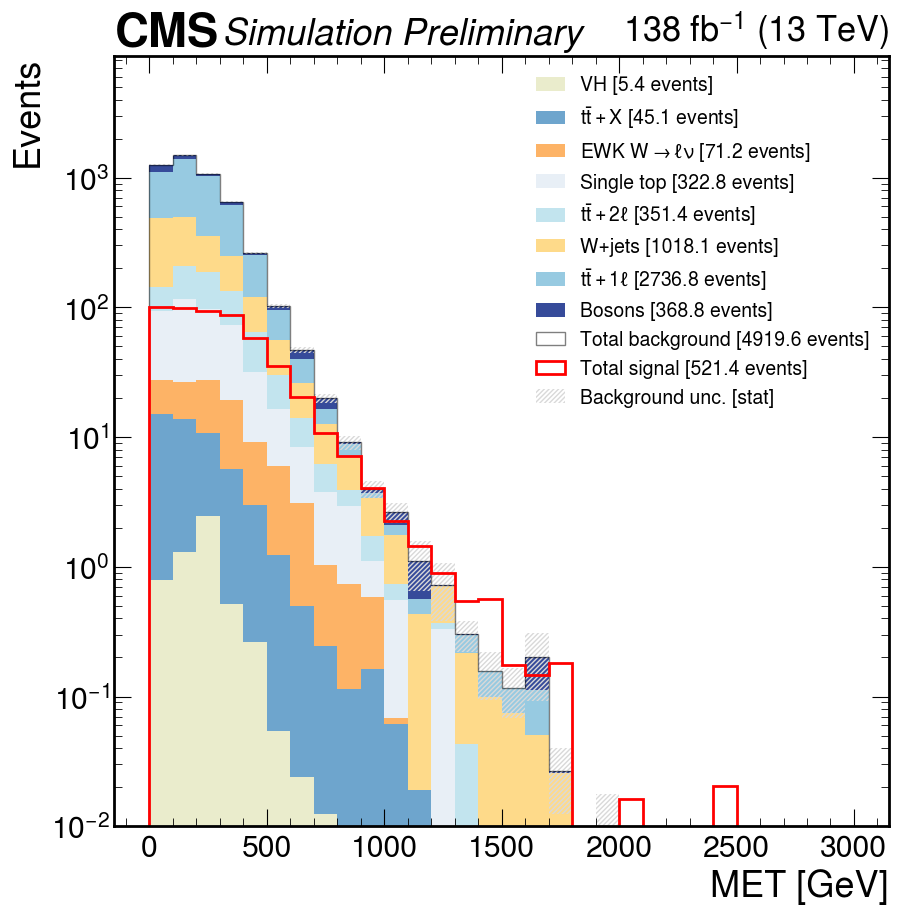

In [20]:
axes = vbswh.plot_sig_vs_bkg(
    "MET", np.linspace(0, 3000, 31), 
    selection="presel_noDetaJJ",
    x_label=r"MET [GeV]",
    stacked=True,
    logy=True
);

Wrote plot to /home/users/jguiang/public_html/vbswh_plots/btagsf_fix/opt/lep_pt_sig_vs_bkg_stacked_logy_presel_noDetaJJ.pdf


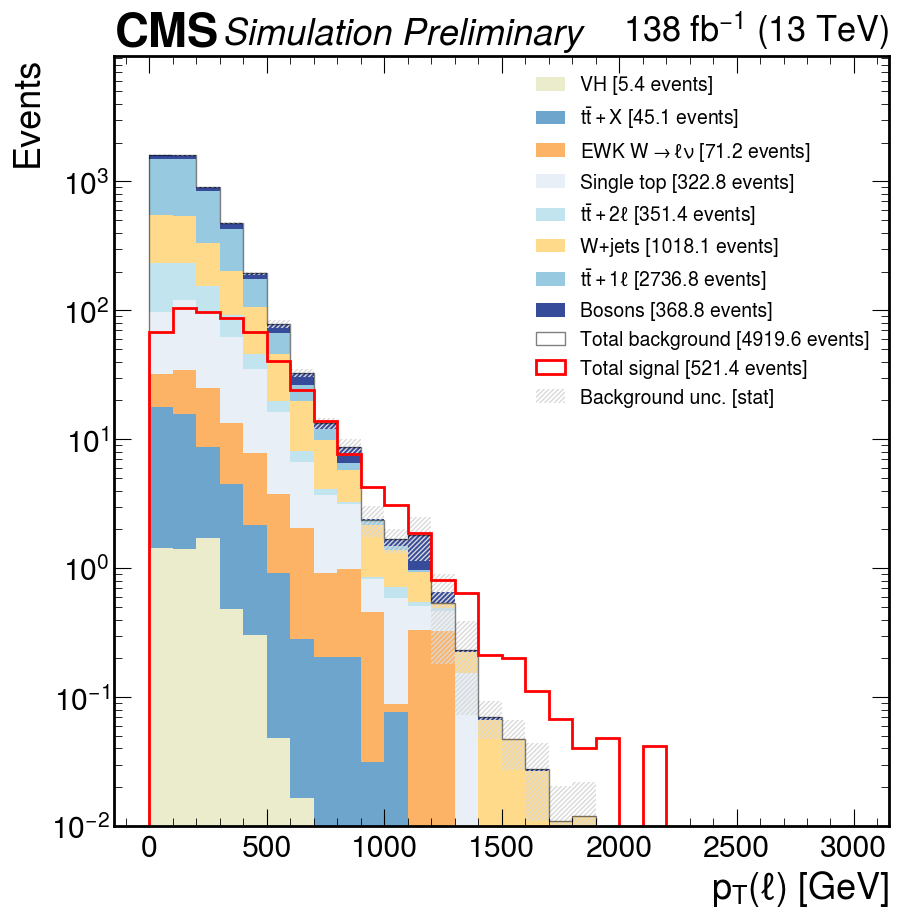

In [21]:
axes = vbswh.plot_sig_vs_bkg(
    "lep_pt", np.linspace(0, 3000, 31), 
    selection="presel_noDetaJJ",
    x_label=r"$p_T(\ell)$ [GeV]",
    stacked=True,
    logy=True
);

Wrote plot to /home/users/jguiang/public_html/vbswh_plots/btagsf_fix/opt/hbbjet_pt_sig_vs_bkg_stacked_logy_presel_noDetaJJ.pdf


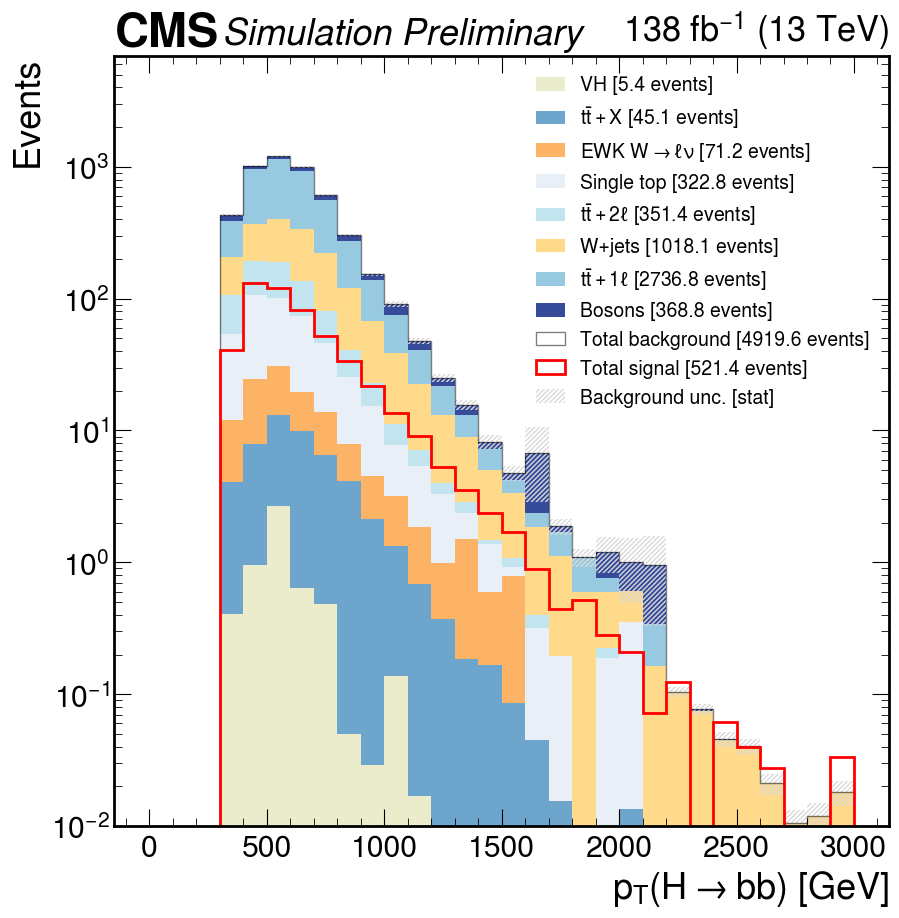

In [22]:
axes = vbswh.plot_sig_vs_bkg(
    "hbbjet_pt", np.linspace(0, 3000, 31), 
    selection="presel_noDetaJJ",
    x_label=r"$p_T(H\rightarrow bb)$ [GeV]",
    stacked=True,
    logy=True
);

Wrote plot to /home/users/jguiang/public_html/vbswh_plots/btagsf_fix/opt/hbbjet_pt_sig_vs_bkg_stacked_logy_presel_noDetaJJ_and_SR1.pdf


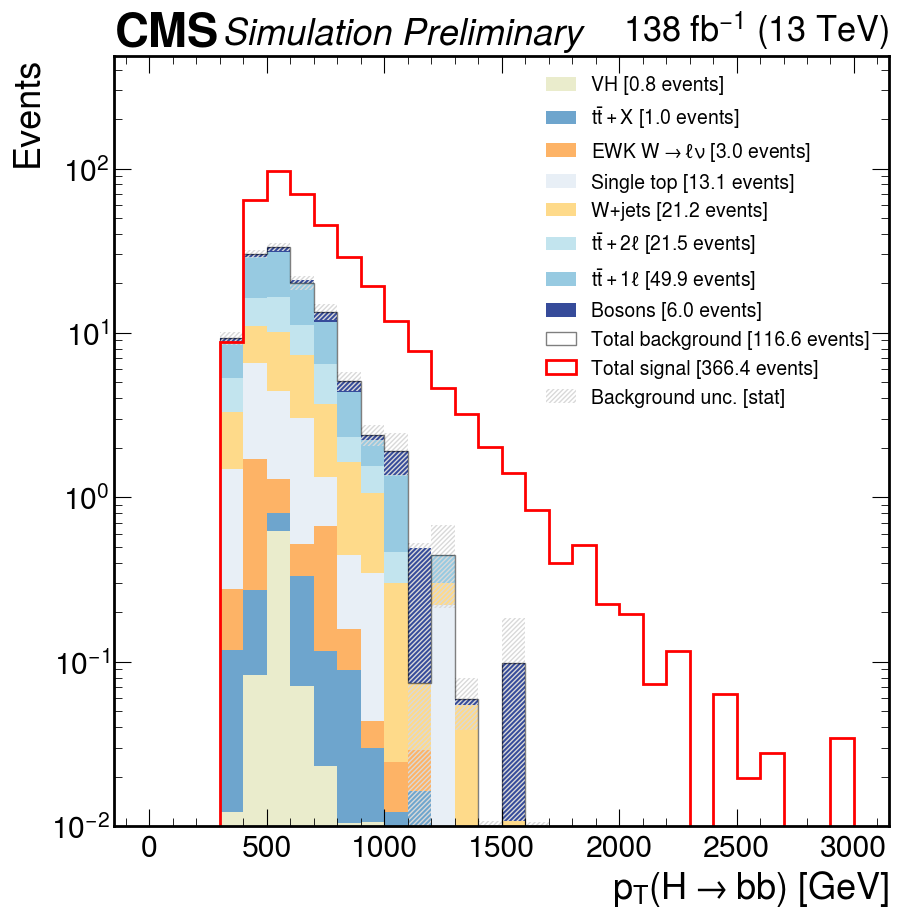

In [23]:
axes = vbswh.plot_sig_vs_bkg(
    "hbbjet_pt", np.linspace(0, 3000, 31), 
    selection="presel_noDetaJJ and SR1",
    x_label=r"$p_T(H\rightarrow bb)$ [GeV]",
    stacked=True,
    logy=True,
    weights=["xbb_sf"]
);

Wrote plot to /home/users/jguiang/public_html/vbswh_plots/btagsf_fix/opt/ST_sig_vs_bkg_stacked_logy_presel_noDetaJJ.pdf


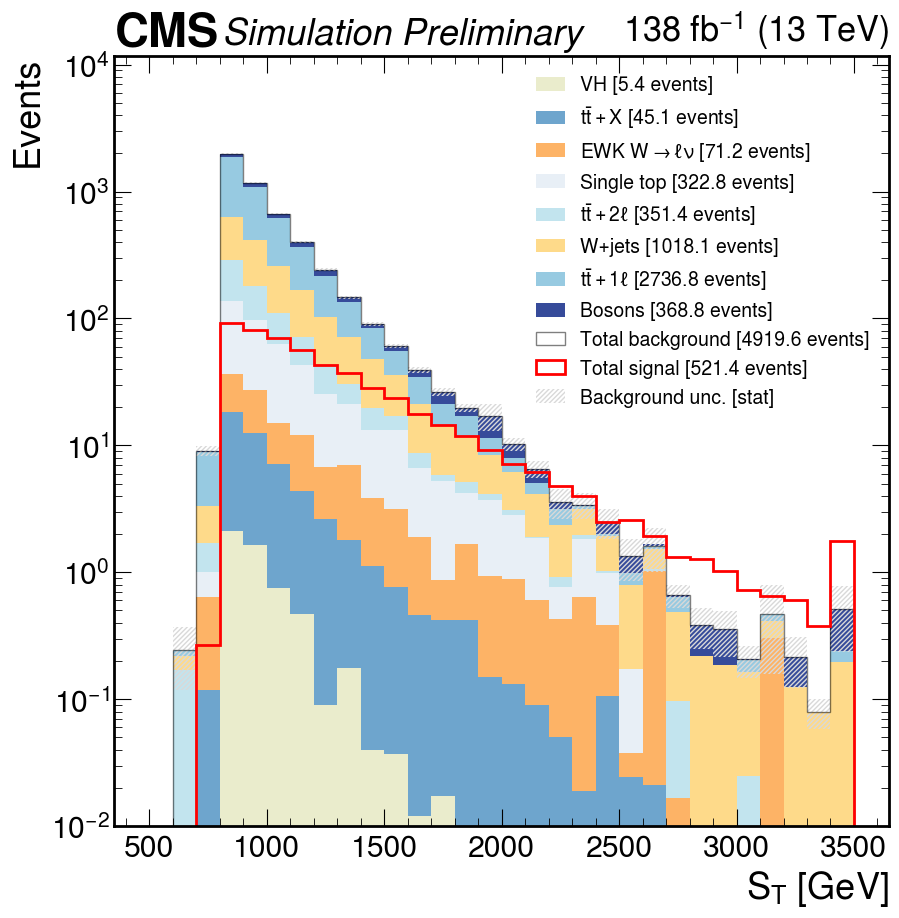

In [24]:
axes = vbswh.plot_sig_vs_bkg(
    "ST", np.linspace(500, 3500, 31), 
    selection="presel_noDetaJJ",
    x_label="$S_T$ [GeV]",
    stacked=True,
    logy=True,
#     norm=True
);

Wrote plot to /home/users/jguiang/public_html/vbswh_plots/btagsf_fix/opt/ST_sig_vs_bkg_stacked_presel.pdf


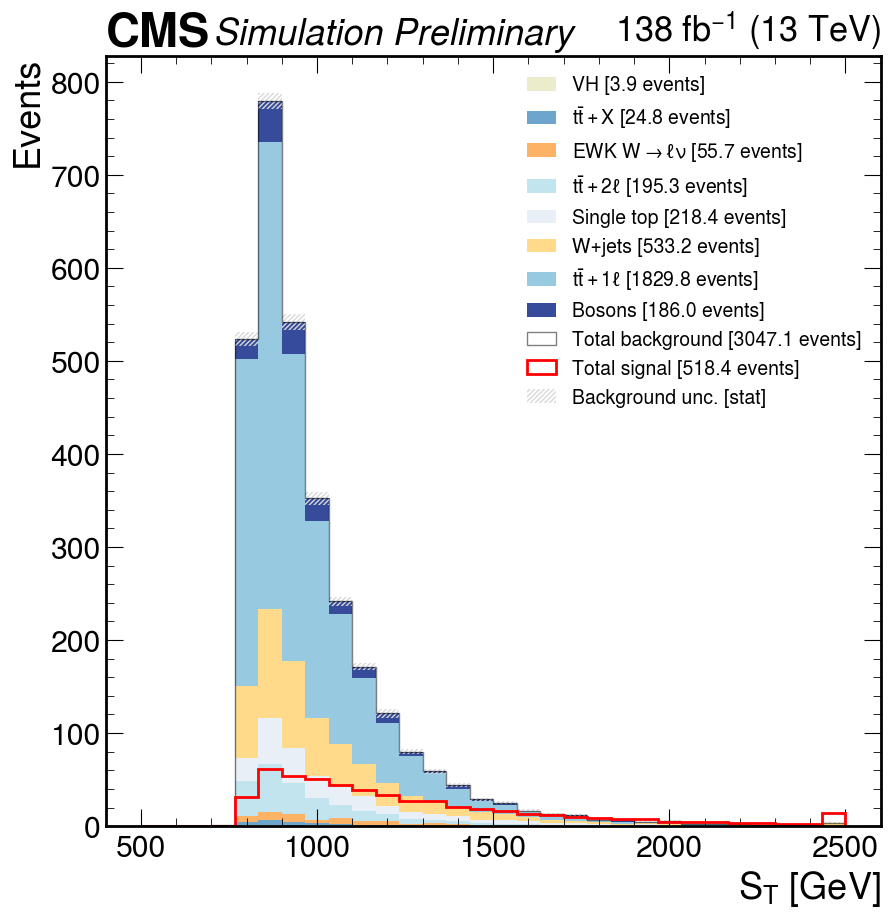

In [25]:
axes = vbswh.plot_sig_vs_bkg(
    "ST", np.linspace(500, 2500, 31), 
    selection="presel",
    x_label="$S_T$ [GeV]",
    stacked=True,
#     logy=True,
#     norm=True
);

Wrote plot to /home/users/jguiang/public_html/vbswh_plots/btagsf_fix/opt/hbbjet_msoftdrop_sig_vs_bkg_stacked_presel_noDetaJJ.pdf


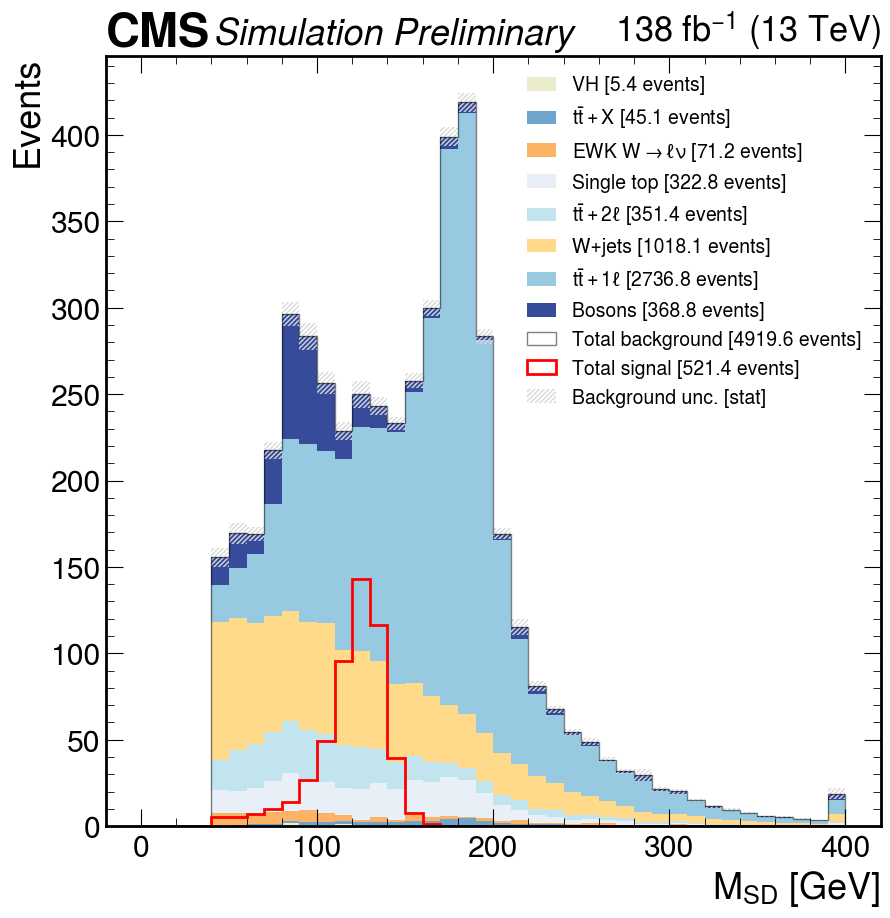

In [26]:
axes = vbswh.plot_sig_vs_bkg(
    "hbbjet_msoftdrop", np.linspace(0, 400, 41), 
    selection="presel_noDetaJJ",
    x_label="$M_{SD}$ [GeV]",
    stacked=True,
#     norm=True
);

Wrote plot to /home/users/jguiang/public_html/vbswh_plots/btagsf_fix/opt/hbbjet_score_sig_vs_bkg_stacked_presel_noDetaJJ.pdf


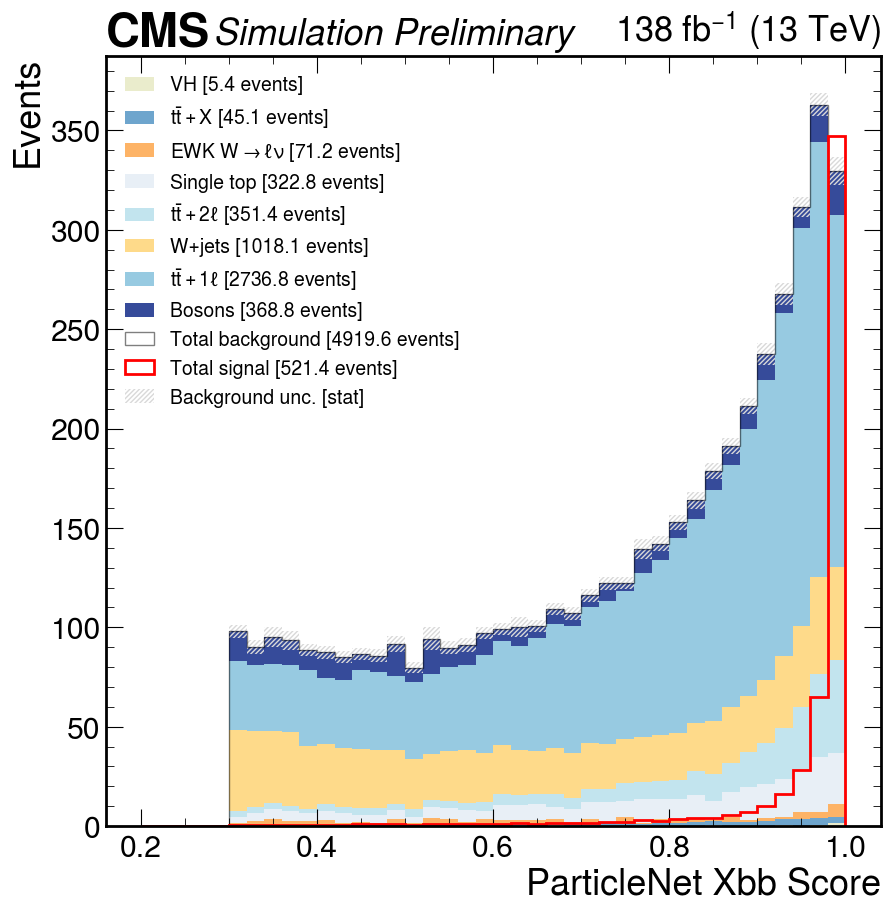

In [27]:
axes = vbswh.plot_sig_vs_bkg(
    "hbbjet_score", np.linspace(0.2, 1, 41), 
    selection="presel_noDetaJJ",
    x_label="ParticleNet Xbb Score",
    stacked=True,
    legend_loc="upper left"
#     norm=True
);

Wrote plot to /home/users/jguiang/public_html/vbswh_plots/btagsf_fix/opt/ld_vbsjet_pt_sig_vs_bkg_stacked_presel_noDetaJJ.pdf


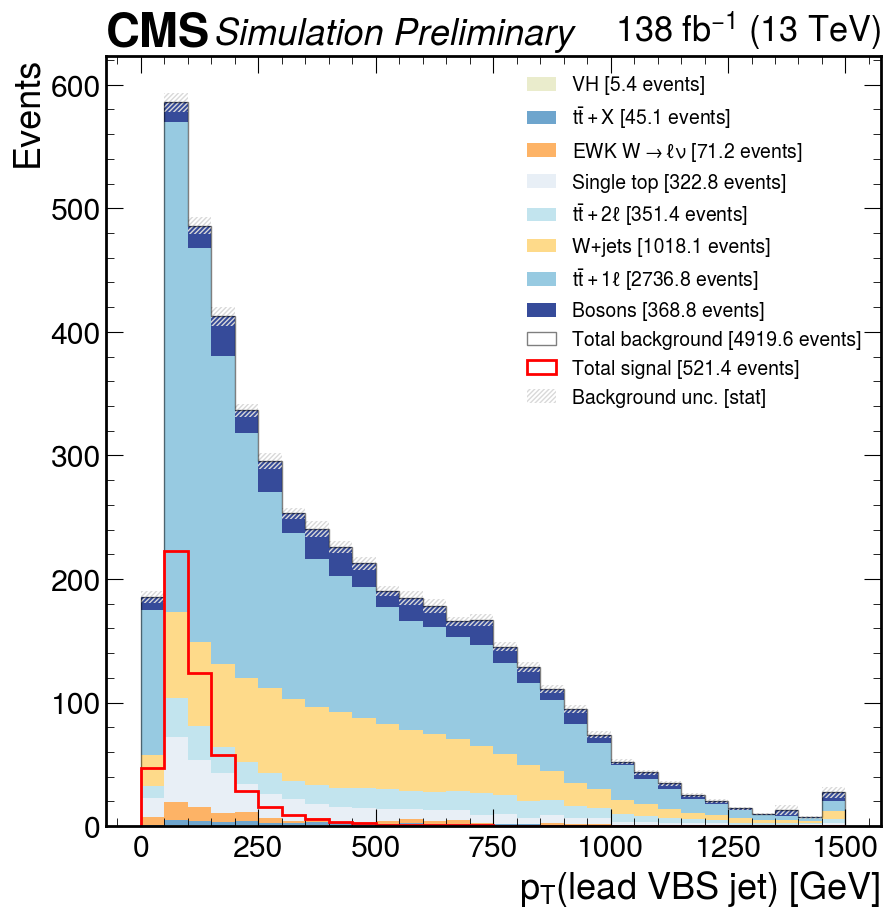

In [28]:
axes = vbswh.plot_sig_vs_bkg(
    "ld_vbsjet_pt", np.linspace(0, 1500, 31), 
    selection="presel_noDetaJJ",
    x_label="$p_T($lead VBS jet$)$ [GeV]",
    stacked=True,
    logy=False
);

Wrote plot to /home/users/jguiang/public_html/vbswh_plots/btagsf_fix/opt/tr_vbsjet_pt_sig_vs_bkg_stacked_presel_noDetaJJ.pdf


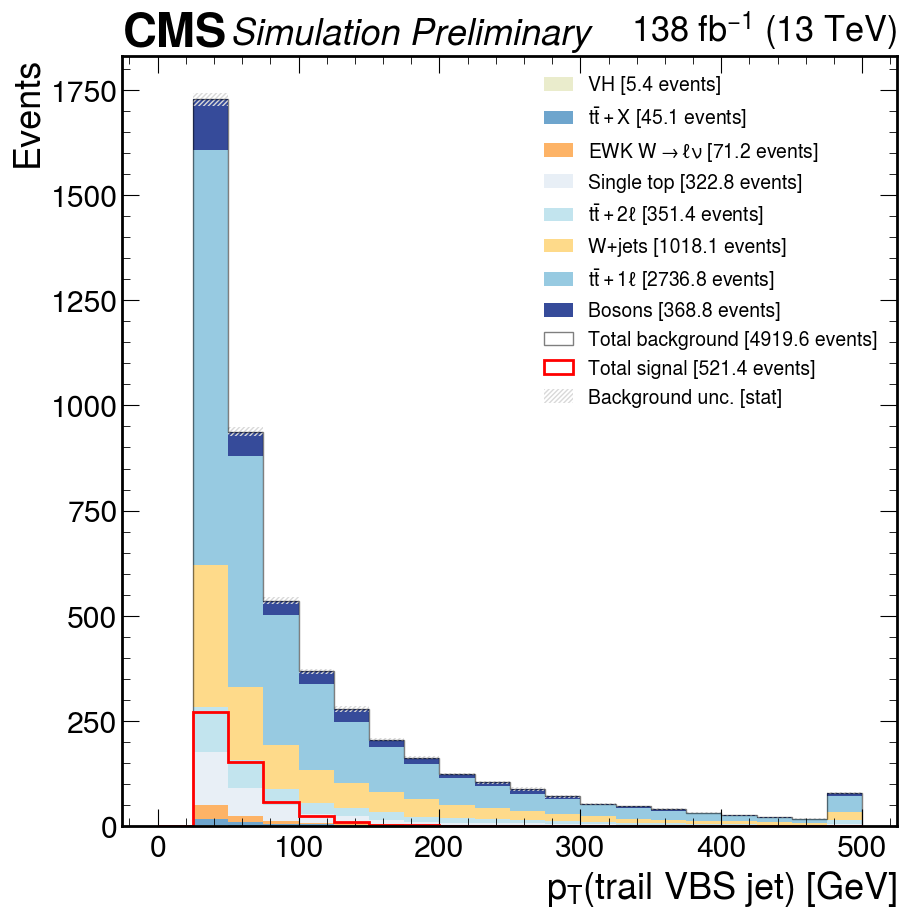

In [29]:
axes = vbswh.plot_sig_vs_bkg(
    "tr_vbsjet_pt", np.linspace(0, 500, 21), 
    selection="presel_noDetaJJ",
    x_label="$p_T($trail VBS jet$)$ [GeV]",
    stacked=True,
    logy=False
);

Wrote plot to /home/users/jguiang/public_html/vbswh_plots/btagsf_fix/opt/M_jj_sig_vs_bkg_stacked_logy_presel_noDetaJJ.pdf


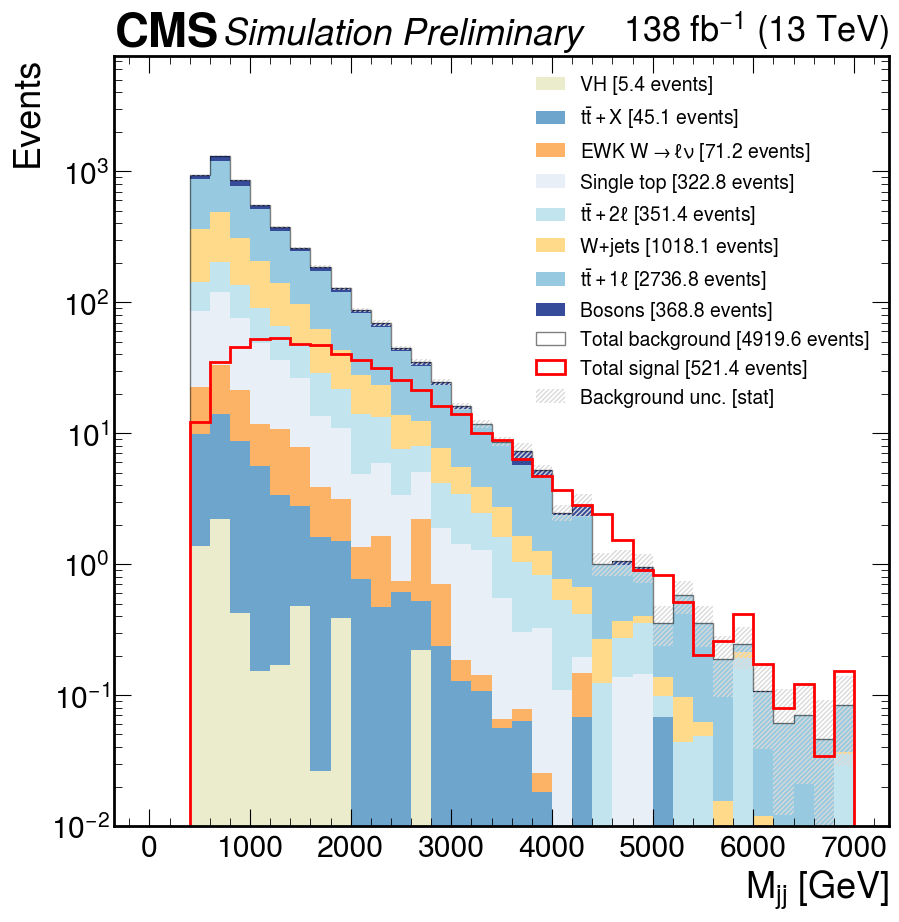

In [30]:
axes = vbswh.plot_sig_vs_bkg(
    "M_jj", np.linspace(0, 7000, 36), 
    selection="presel_noDetaJJ",
    x_label="$M_{jj}$ [GeV]",
    stacked=True,
    logy=True
);

Wrote plot to /home/users/jguiang/public_html/vbswh_plots/btagsf_fix/opt/deta_jj_sig_vs_bkg_stacked_presel_noDetaJJ.pdf


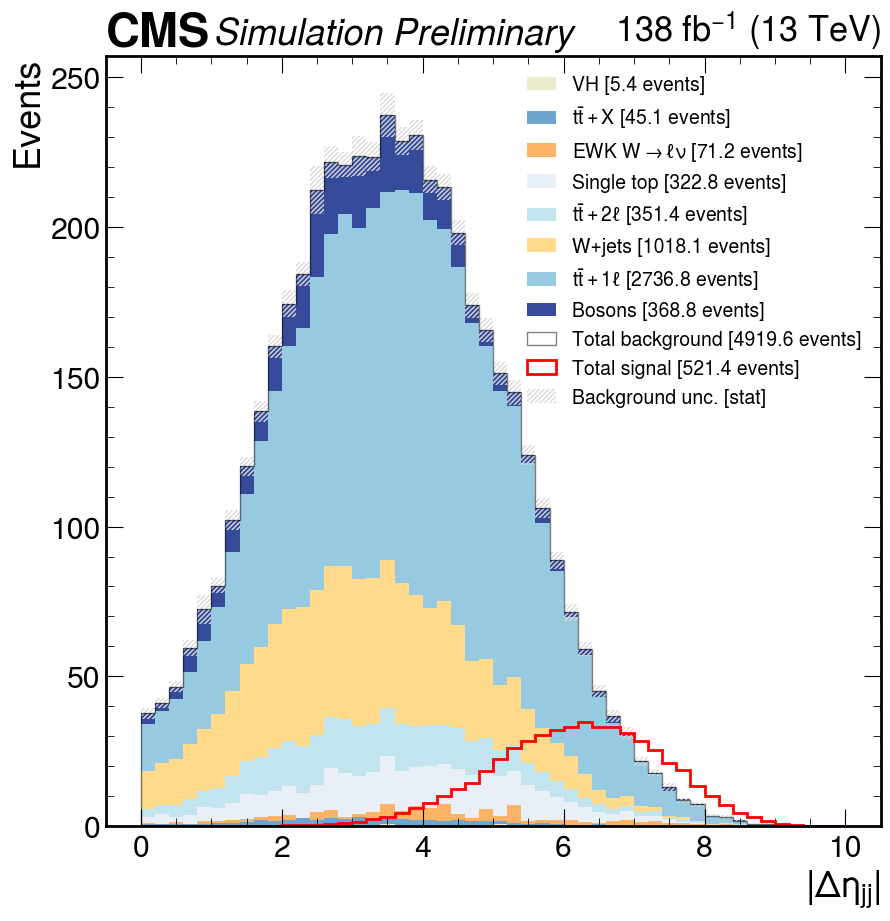

In [31]:
axes = vbswh.plot_sig_vs_bkg(
    "deta_jj", np.linspace(0, 10, 51), 
    selection="presel_noDetaJJ", 
    x_label="$|\Delta\eta_{jj}|$",
    transf=abs,
    stacked=True
);

Wrote plot to /home/users/jguiang/public_html/vbswh_plots/btagsf_fix/opt/deta_jj_sig_vs_bkg_stacked_presel.pdf


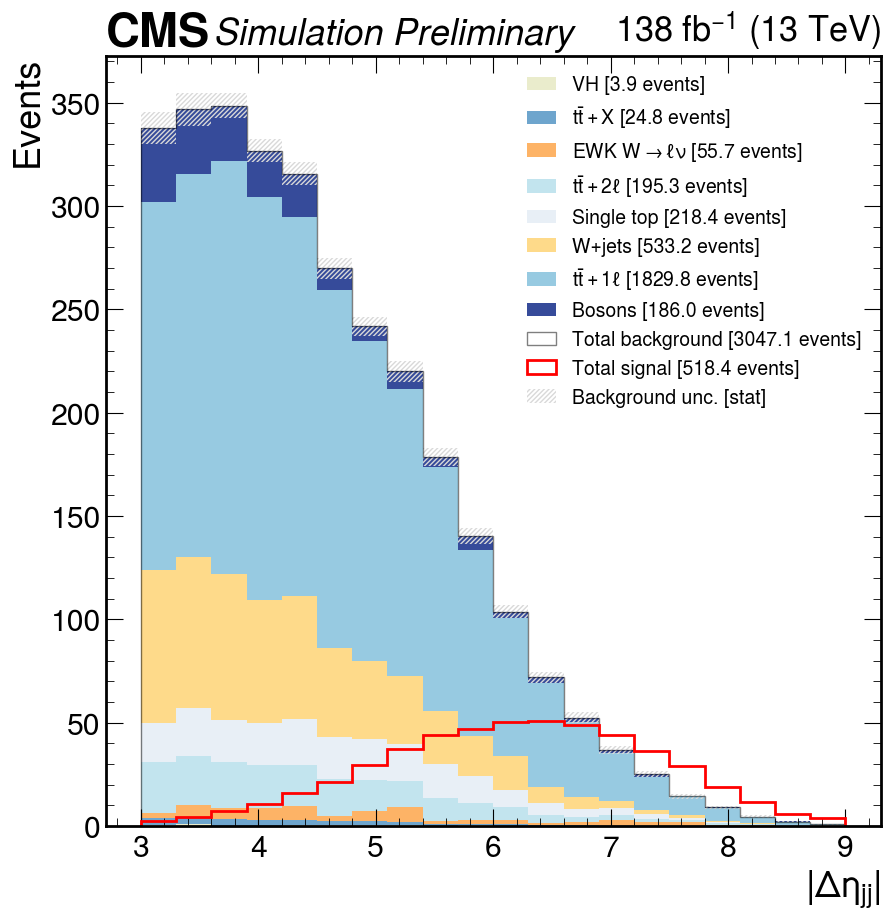

In [32]:
axes = vbswh.plot_sig_vs_bkg(
    "deta_jj", np.linspace(3, 9, 21), 
    selection="presel", 
    x_label="$|\Delta\eta_{jj}|$",
    transf=abs,
    stacked=True
);

Wrote plot to /home/users/jguiang/public_html/vbswh_plots/btagsf_fix/opt/LT_sig_vs_bkg_stacked_M_jj_gt_1500_and_abs(deta_jj)_gt_5.pdf


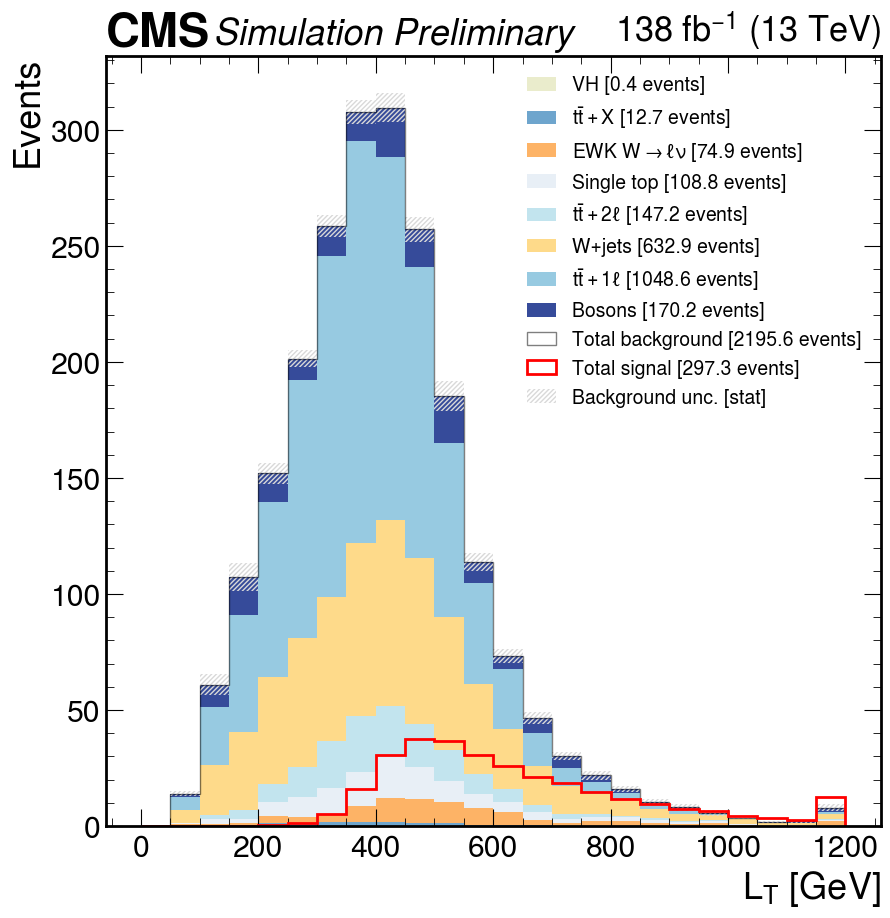

In [33]:
vbswh.plot_sig_vs_bkg(
    "LT", np.linspace(0, 1200, 25), 
    selection="M_jj > 1500 and abs(deta_jj) > 5", 
    x_label="$L_T$ [GeV]",
    stacked=True
);

Wrote plot to /home/users/jguiang/public_html/vbswh_plots/btagsf_fix/opt/ST_sig_vs_bkg_stacked_M_jj_gt_1500_and_abs(deta_jj)_gt_5.pdf


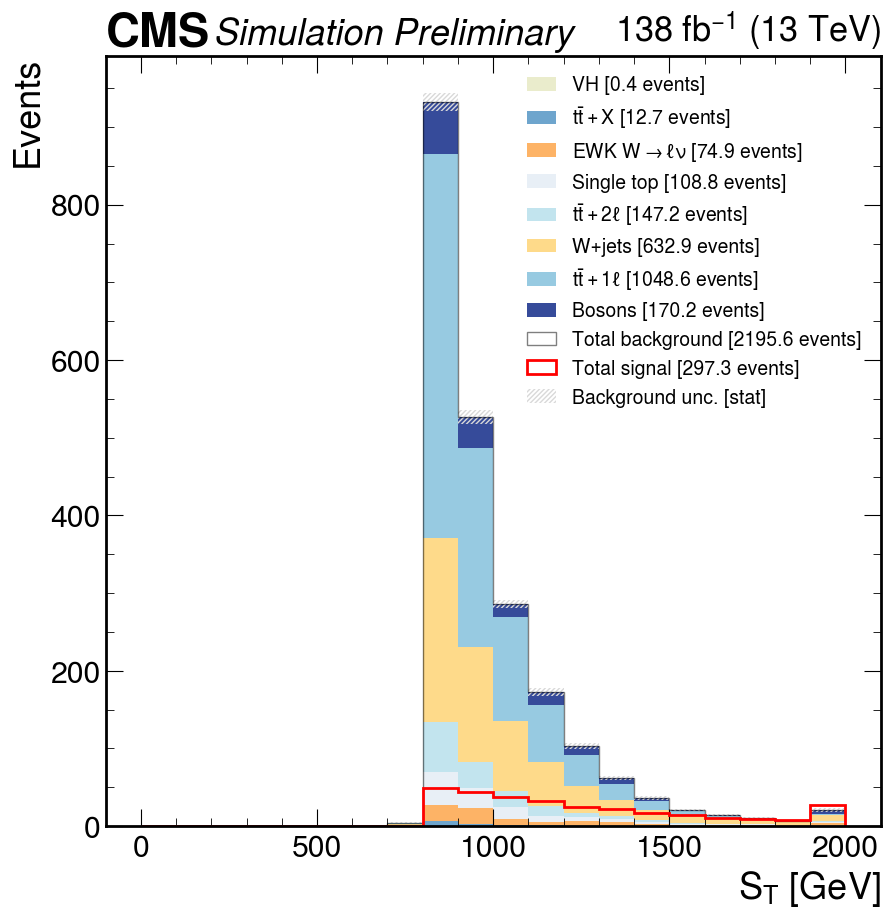

In [34]:
axes = vbswh.plot_sig_vs_bkg(
    "ST", np.linspace(0, 2000, 21), 
    selection="M_jj > 1500 and abs(deta_jj) > 5", x_label="$S_T$ [GeV]",
    stacked=True
);

Wrote plot to /home/users/jguiang/public_html/vbswh_plots/btagsf_fix/opt/hbbjet_score_sig_vs_bkg_stacked_norm.pdf


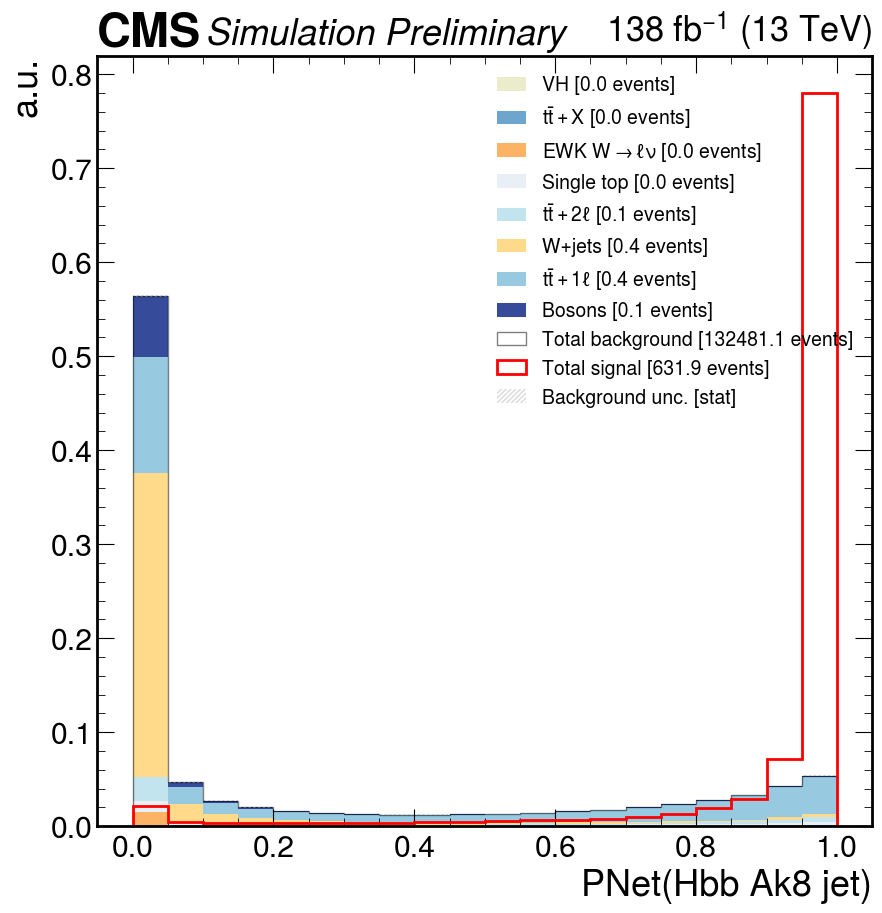

In [35]:
vbswh.plot_sig_vs_bkg(
    "hbbjet_score", np.linspace(0, 1.0, 21), 
#     selection="M_jj > 1500 and abs(deta_jj) > 5 and ST > 1300", 
    x_label="PNet(Hbb Ak8 jet)",
    stacked=True,
    norm=True
);

In [36]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors as clr

cmap = clr.LinearSegmentedColormap.from_list("trident", ["#182B49","#00629B", "#C69214", "#FFCD00"], N=256)
cmap.set_under("#182B49")

def colorbar(mappable):
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    return fig.colorbar(mappable, cax=cax)

In [37]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors as clr

cmap = clr.LinearSegmentedColormap.from_list("trident", ["#182B49","#00629B", "#C69214", "#FFCD00"], N=256)
cmap.set_under("#182B49")

def colorbar(mappable):
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    return fig.colorbar(mappable, cax=cax)

def plot_2dcorr(sel=None, sample=None, flip=False, year=None, rebin=None):
    msd_edges = np.linspace(40, 440, 41)
    detajj_edges = np.linspace(0, 8, 41)

    if sample is None:
        df = vbswh.bkg_df(selection=sel)
    else:
        df = vbswh.sample_df(sample, selection=sel)
        
    if not year is None:
        df = df[df.year.abs() == year]
        if year == 2016:
            lumi = 36.33
        elif year == 2017:
            lumi = 41.48
        elif year == 2018:
            lumi = 59.83
    else:
        lumi = 138

    hist2d = yahist.Hist2D(
        (df.abs_deta_jj, df.hbbjet_msoftdrop),
        bins=[detajj_edges, msd_edges],
        weights=df.event_weight
    )
    if flip:
        hist2d = hist2d.transpose()
    if not rebin is None:
        hist2d = hist2d.rebin(rebin)

    # Plot 2D hist
    fig, axes = plt.subplots(figsize=(11, 11))
    mpl_objs = hist2d.plot(
        ax=axes, colorbar=False, counts=False, 
        counts_formatter="{:.2f}".format, counts_fontsize=6, 
        cmap=cmap, zrange=(0, None), hide_empty=False
    );
    if flip:
        axes.set_xlabel(r"$M_{SD}$");
        axes.set_ylabel(r"$|\Delta\eta_{jj}|$");
        axes.set_ylim(bottom=0)
        hist2d.profile("x").plot(errors=True, color="white", fmt=".", label=r"$M_{SD}$ profile")
    else:
        axes.set_ylabel(r"$M_{SD}$");
        axes.set_xlabel(r"$|\Delta\eta_{jj}|$");
        axes.set_ylim(bottom=40)
        hist2d.profile("x").plot(errors=True, color="white", fmt=".", label=r"$|\Delta\eta_{jj}|$ profile")

    # Plot colorbar
    cbar = colorbar(mpl_objs[0]);
    cbar.set_label(r"Count");

    legend = axes.legend(title="All background" if sample is None else vbswh.sample_labels.get(sample, sample))
    legend.get_title().set_color("white")
    for label in legend.get_texts():
        label.set_color("white")

    # Add CMS label
    hep.cms.label(
        "Preliminary",
        data=False,
        lumi=lumi,
        loc=0,
        ax=axes,
    );
    
    outfile = f"{PLOTSDIR}/correlation2D_1Dprofile.pdf"
    if not sample is None:
        outfile = outfile.replace(".pdf", f"_{sample}.pdf")
    if flip:
        outfile = outfile.replace(".pdf", "_flipped.pdf")
    if not year is None:
        outfile = outfile.replace(".pdf", f"_{year}.pdf")
        
    print(f"Saved {outfile}")
    plt.savefig(outfile, bbox_inches="tight")
    plt.savefig(outfile.replace(".pdf", ".png"), bbox_inches="tight")

Saved /home/users/jguiang/public_html/vbswh_plots/btagsf_fix/opt/correlation2D_1Dprofile_flipped.pdf
Saved /home/users/jguiang/public_html/vbswh_plots/btagsf_fix/opt/correlation2D_1Dprofile_flipped_2016.pdf
Saved /home/users/jguiang/public_html/vbswh_plots/btagsf_fix/opt/correlation2D_1Dprofile_flipped_2017.pdf
Saved /home/users/jguiang/public_html/vbswh_plots/btagsf_fix/opt/correlation2D_1Dprofile_flipped_2018.pdf


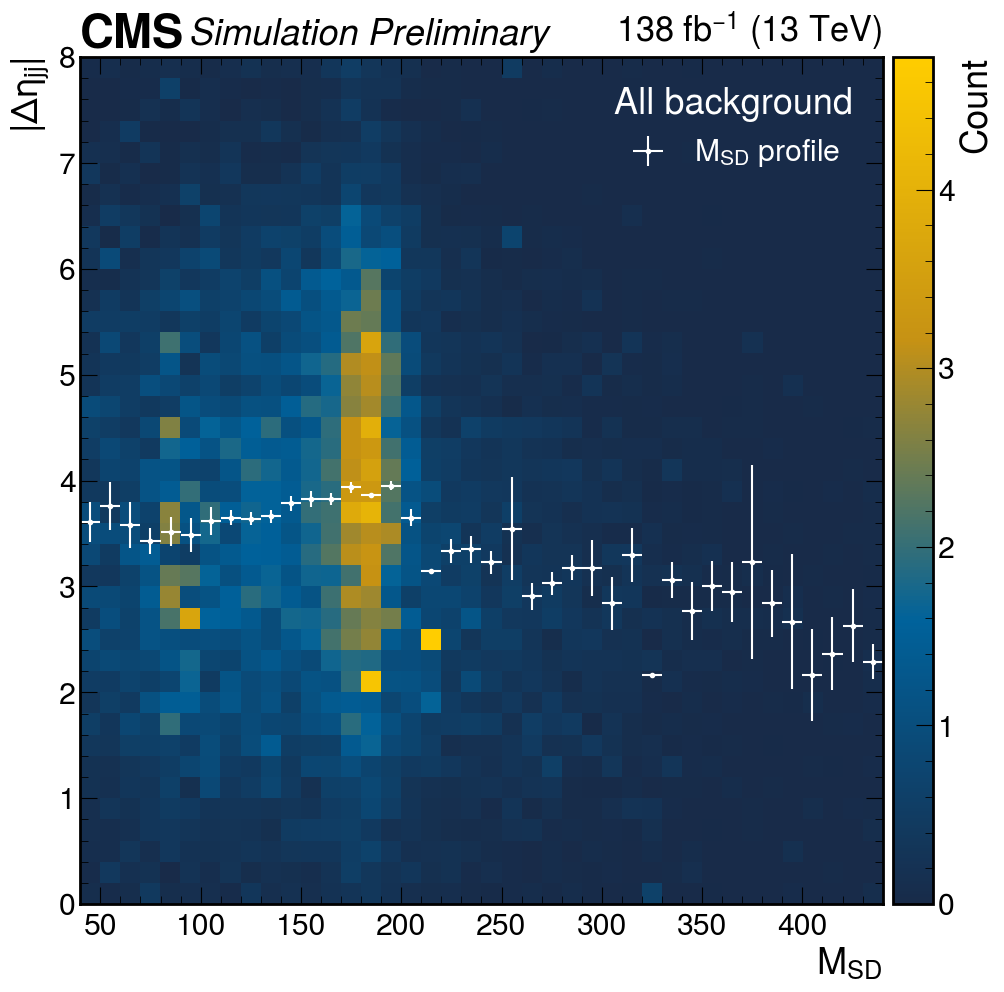

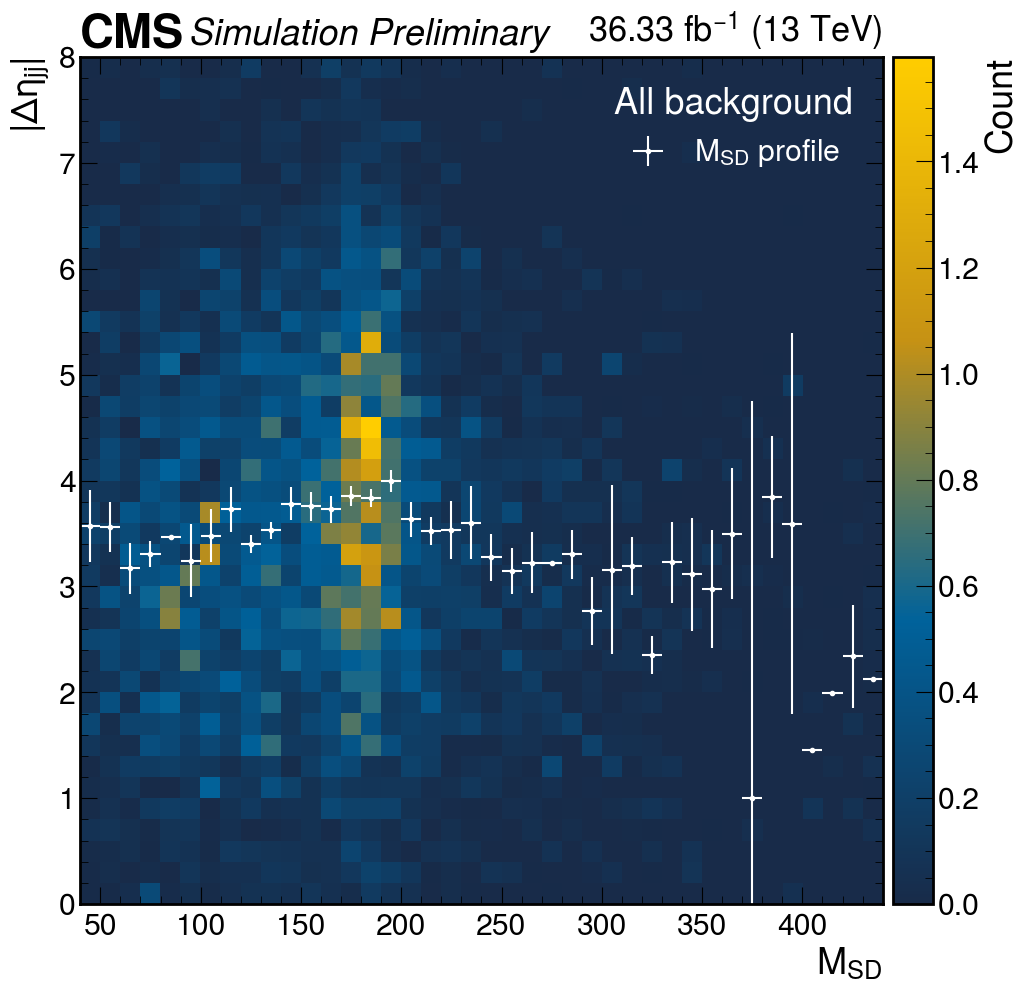

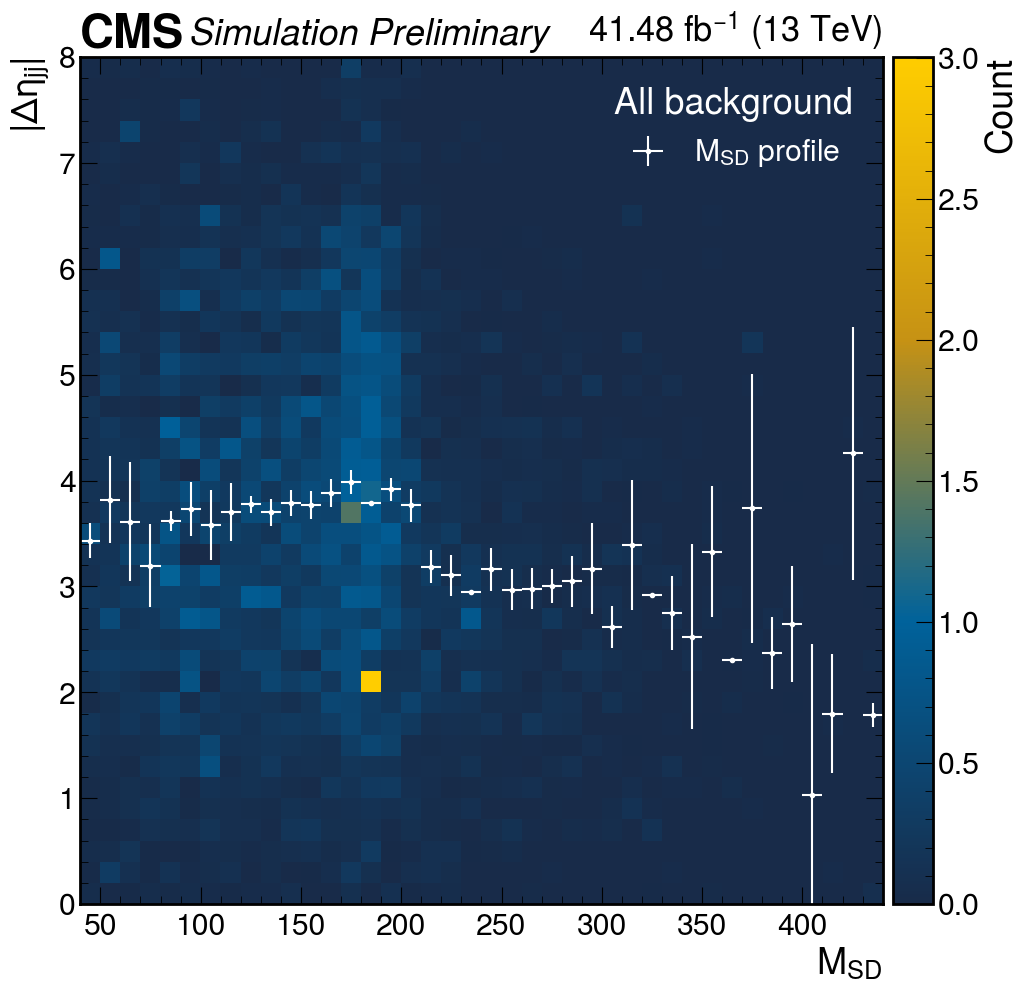

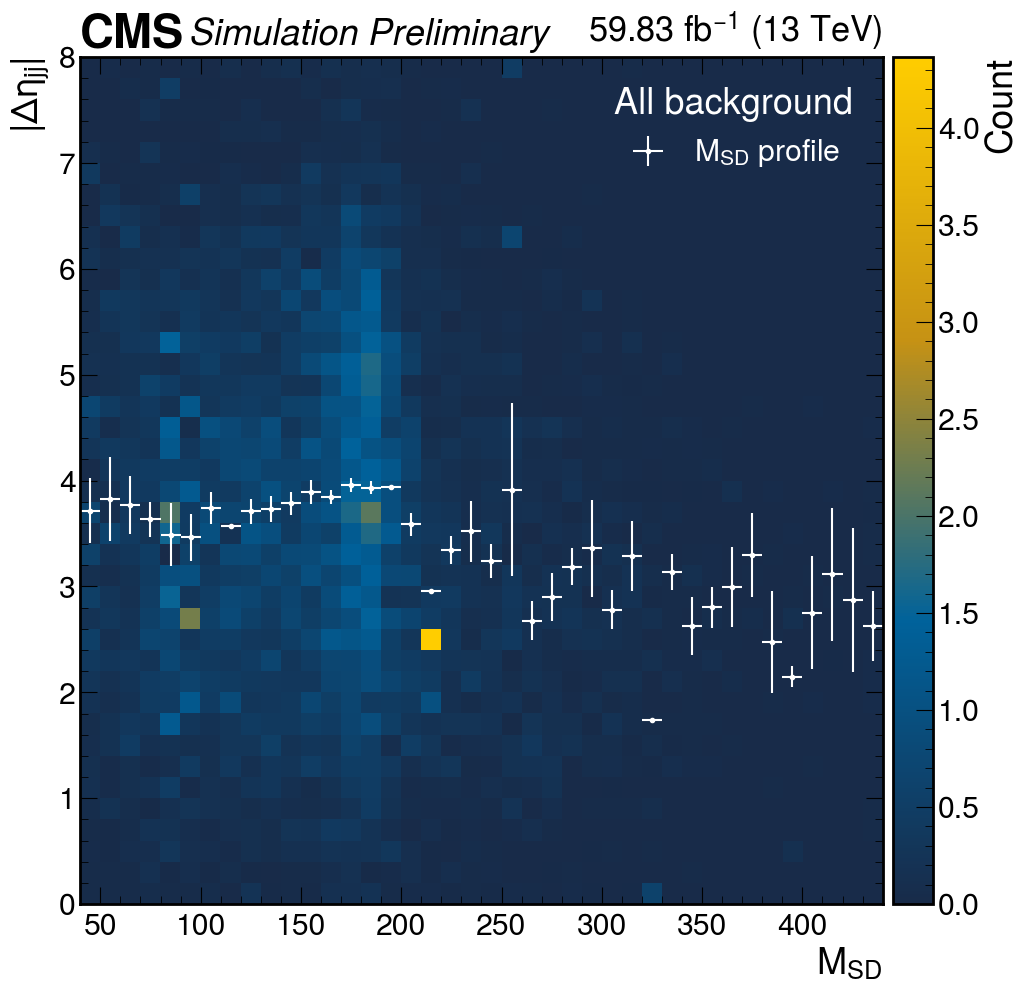

In [38]:
plot_2dcorr(sel="SR_like", flip=True)
for year in [2016, 2017, 2018]:
    plot_2dcorr(sel="SR_like", year=year, flip=True)

Saved /home/users/jguiang/public_html/vbswh_plots/btagsf_fix/opt/correlation2D_1Dprofile.pdf
Saved /home/users/jguiang/public_html/vbswh_plots/btagsf_fix/opt/correlation2D_1Dprofile_2016.pdf
Saved /home/users/jguiang/public_html/vbswh_plots/btagsf_fix/opt/correlation2D_1Dprofile_2017.pdf
Saved /home/users/jguiang/public_html/vbswh_plots/btagsf_fix/opt/correlation2D_1Dprofile_2018.pdf


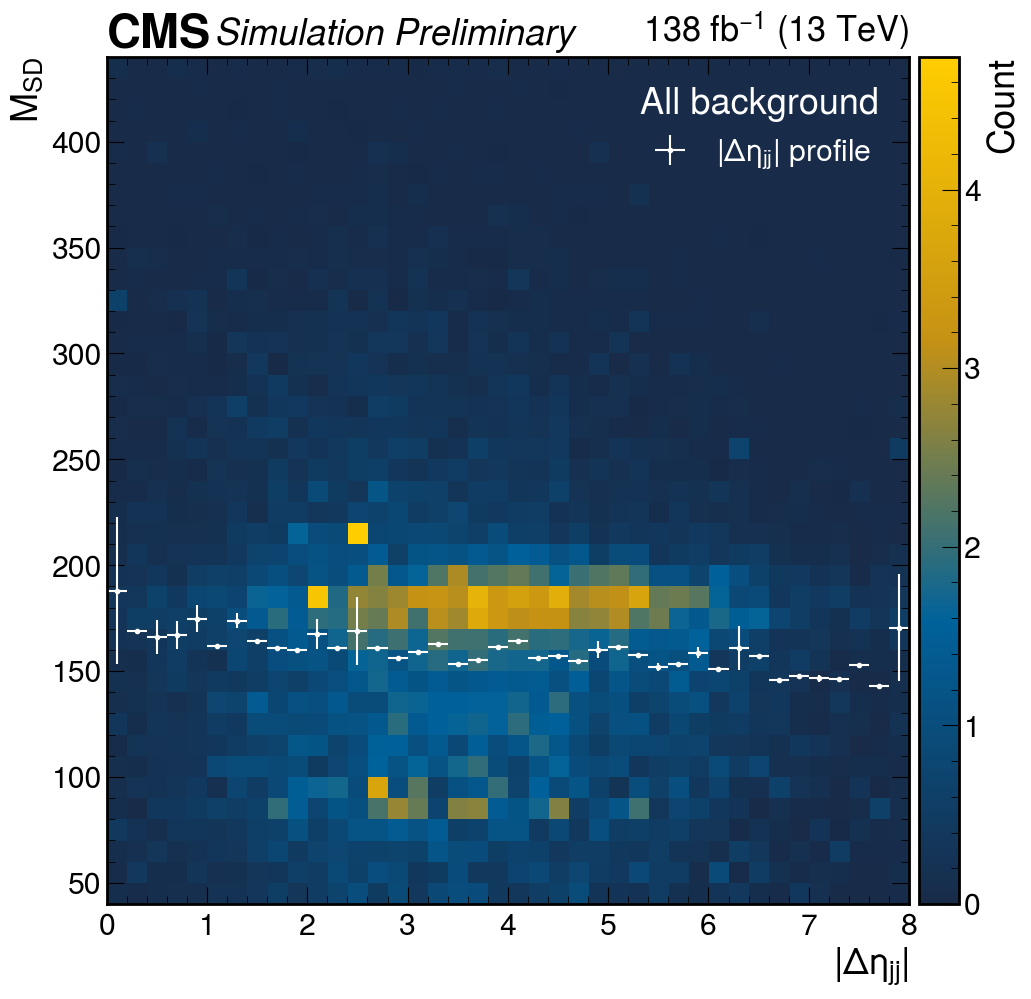

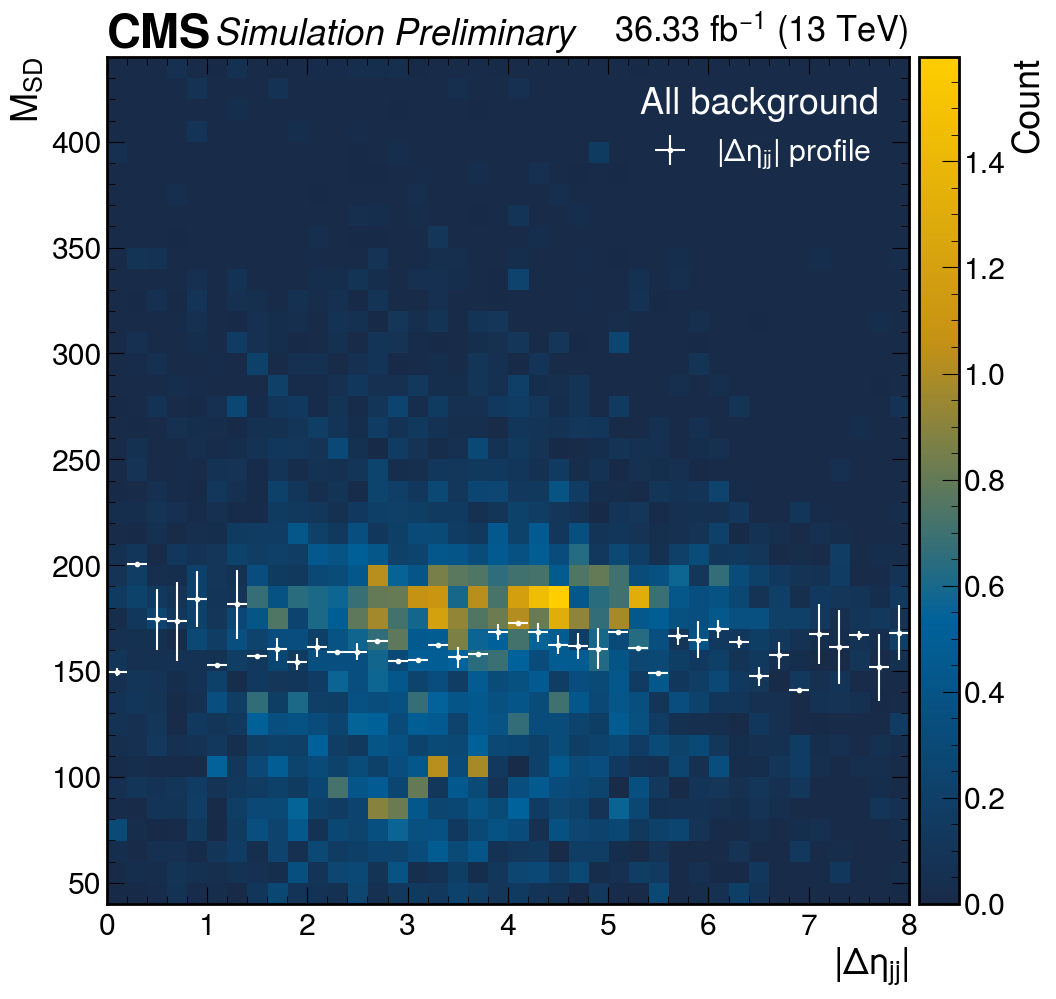

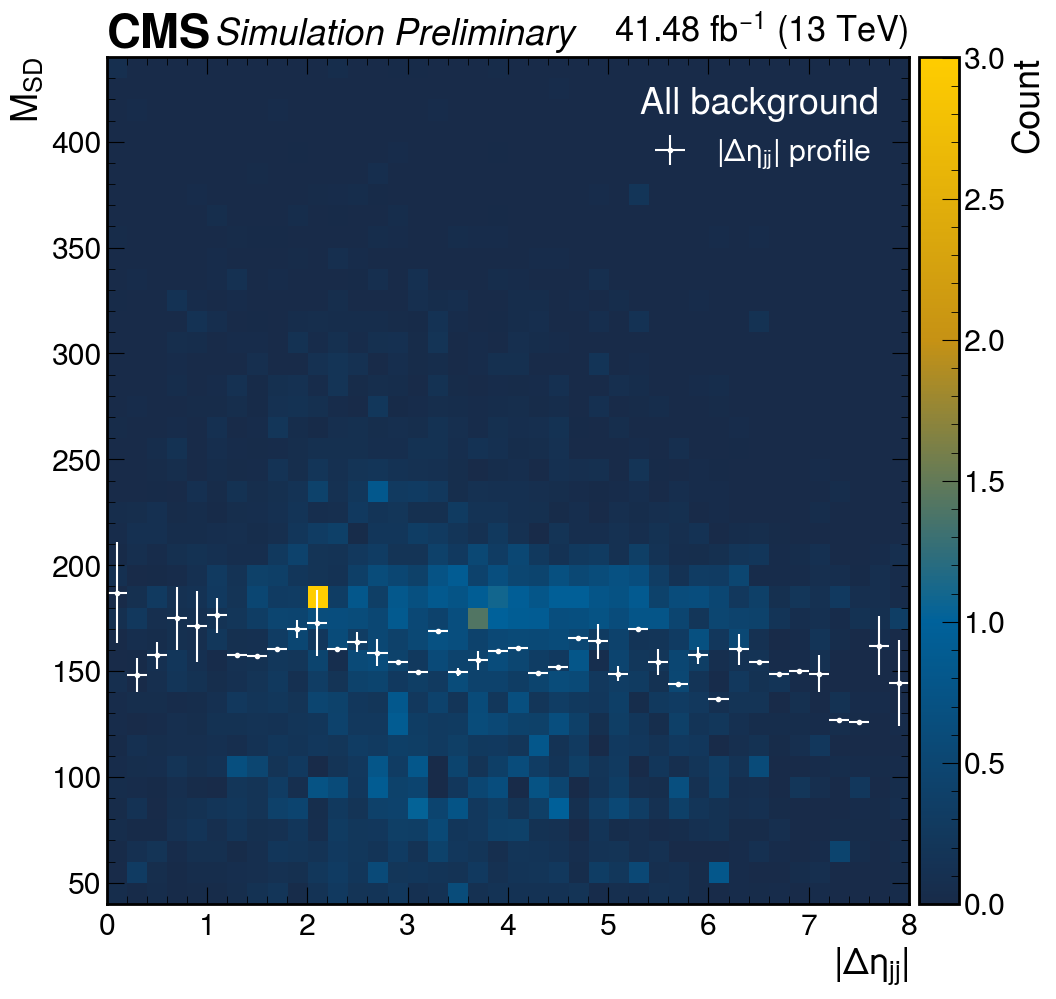

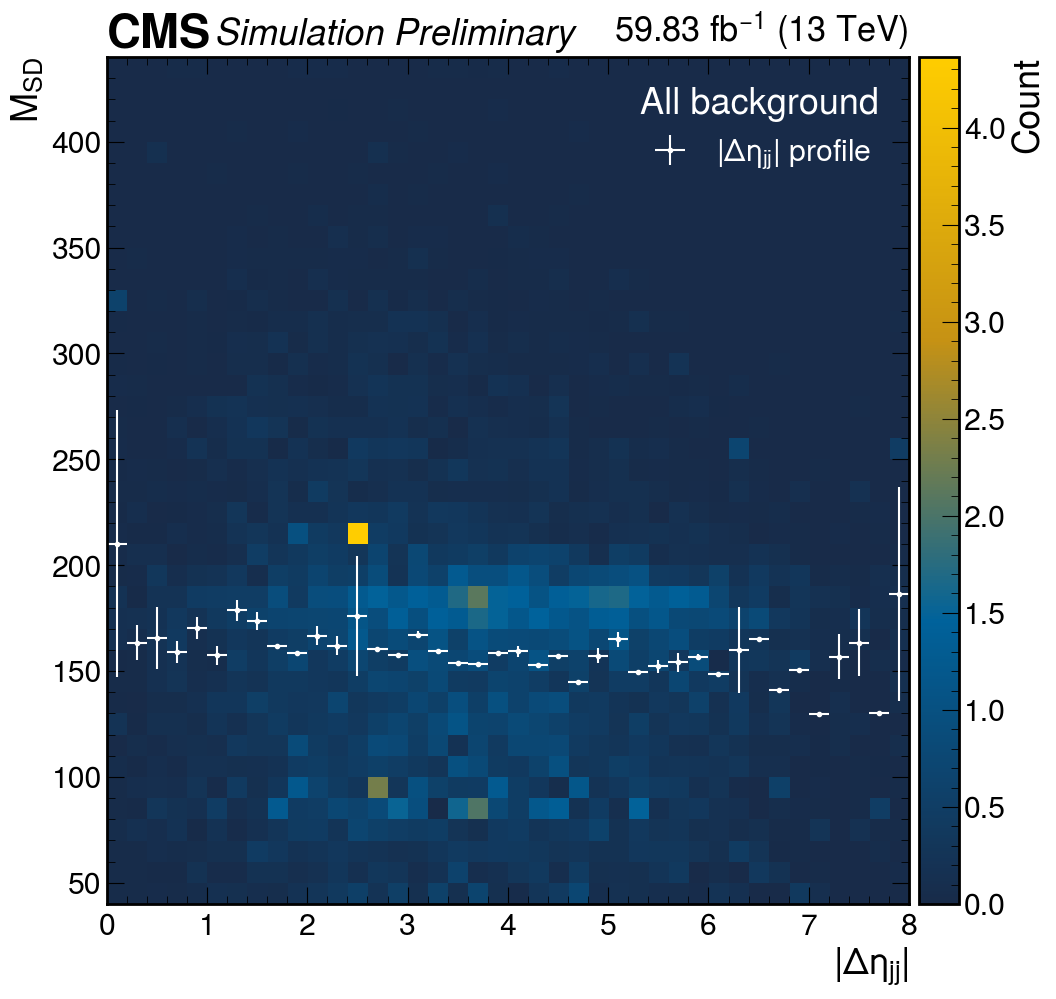

In [40]:
plot_2dcorr(sel="SR_like")
for year in [2016, 2017, 2018]:
    plot_2dcorr(sel="SR_like", year=year)

Saved /home/users/jguiang/public_html/vbswh_plots/btagsf_fix/opt/correlation2D_1Dprofile_TTbar1L.pdf
Saved /home/users/jguiang/public_html/vbswh_plots/btagsf_fix/opt/correlation2D_1Dprofile_TTbar1L_2016.pdf
Saved /home/users/jguiang/public_html/vbswh_plots/btagsf_fix/opt/correlation2D_1Dprofile_TTbar1L_2017.pdf
Saved /home/users/jguiang/public_html/vbswh_plots/btagsf_fix/opt/correlation2D_1Dprofile_TTbar1L_2018.pdf


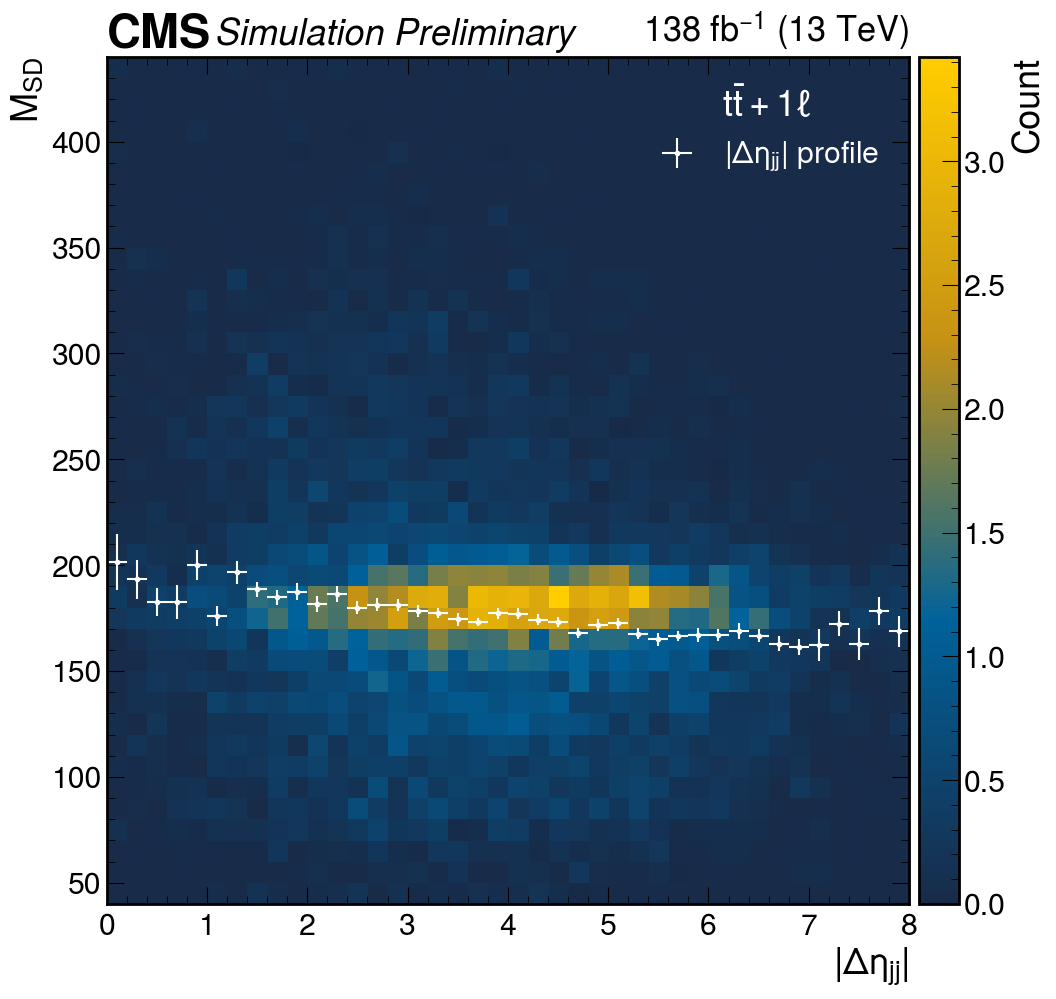

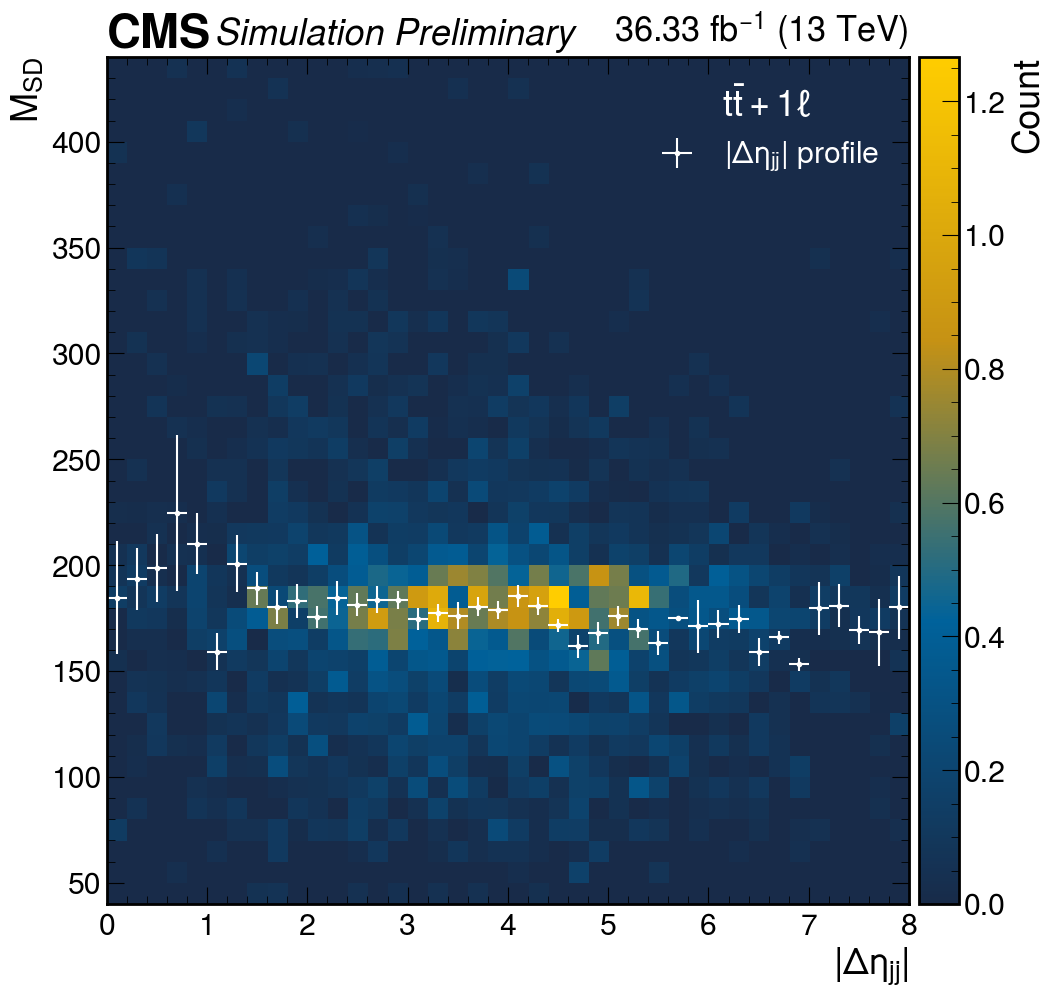

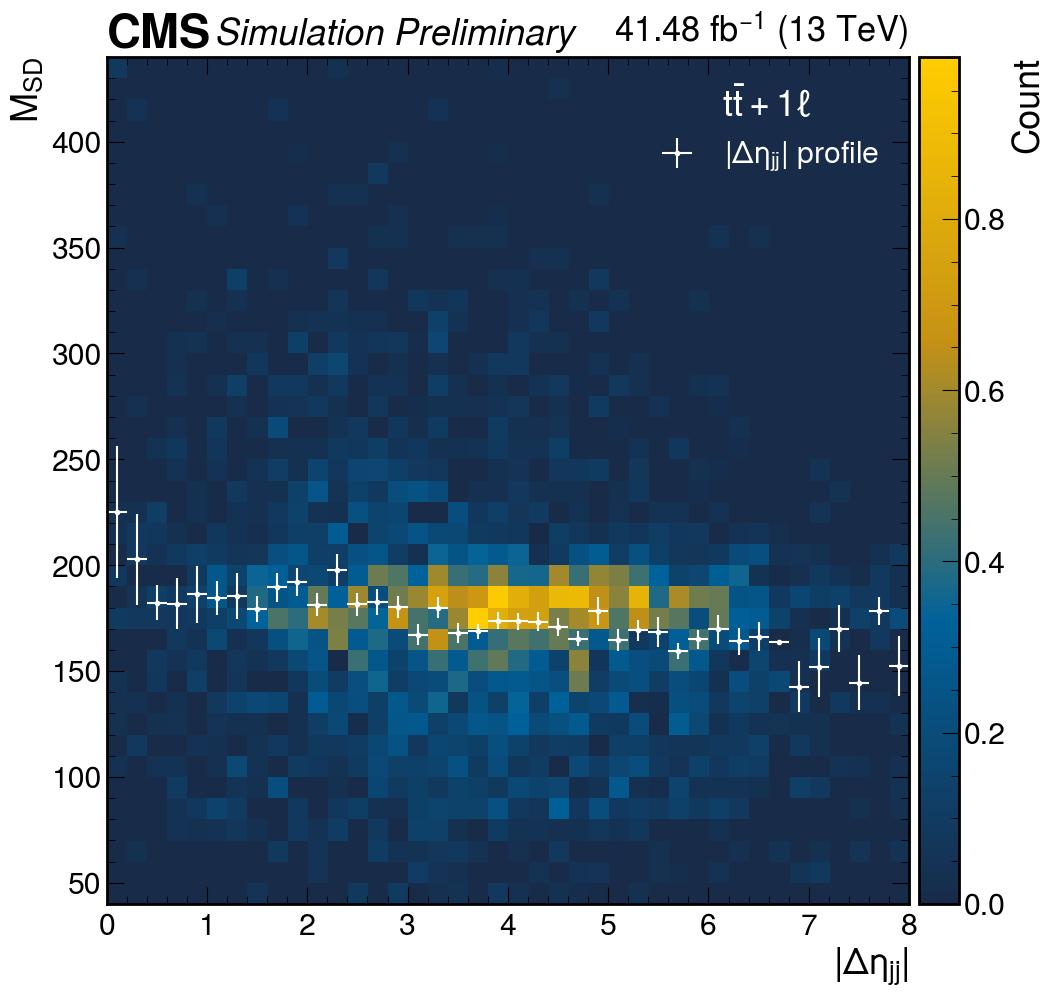

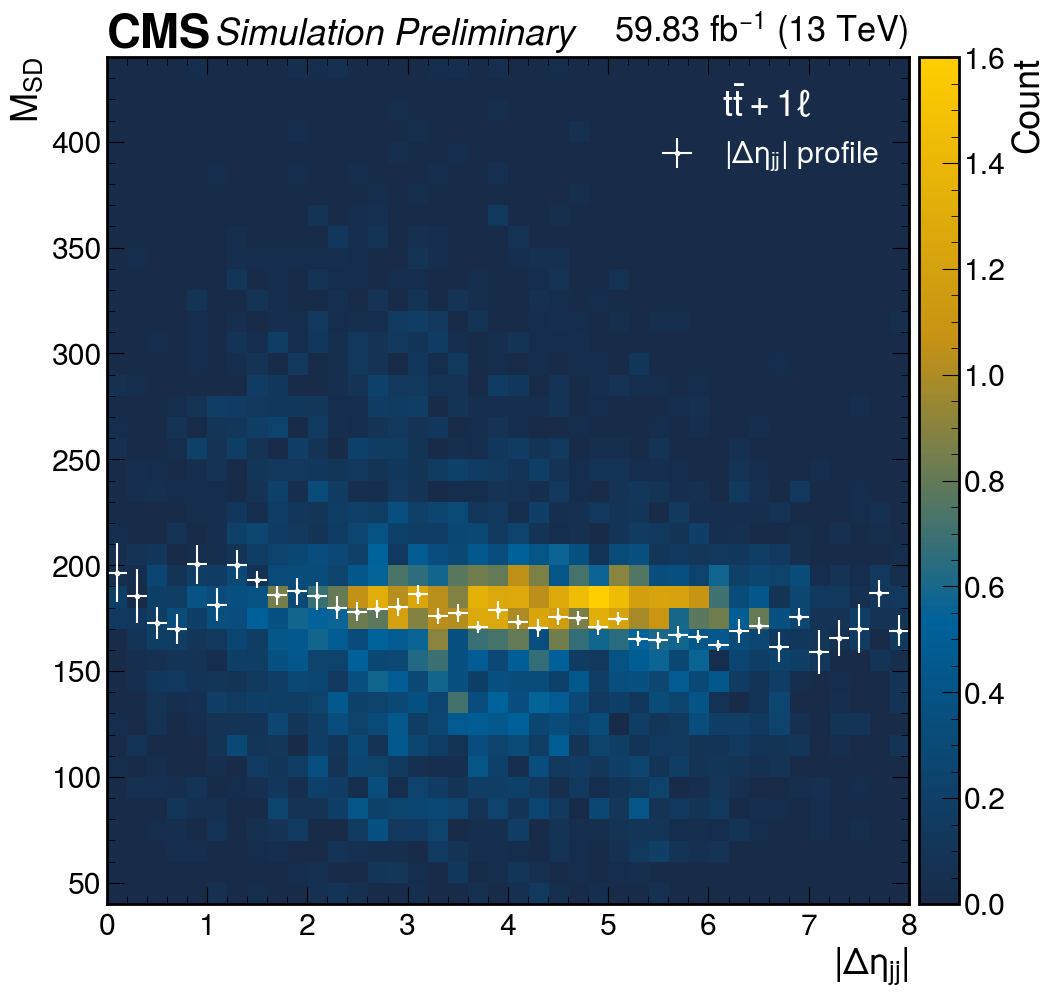

In [41]:
plot_2dcorr(sel="SR_like", sample="TTbar1L")
for year in [2016, 2017, 2018]:
    plot_2dcorr(sel="SR_like", sample="TTbar1L", year=year)

Saved /home/users/jguiang/public_html/vbswh_plots/btagsf_fix/opt/correlation2D_1Dprofile_TTbar1L_flipped.pdf
Saved /home/users/jguiang/public_html/vbswh_plots/btagsf_fix/opt/correlation2D_1Dprofile_TTbar1L_flipped_2016.pdf
Saved /home/users/jguiang/public_html/vbswh_plots/btagsf_fix/opt/correlation2D_1Dprofile_TTbar1L_flipped_2017.pdf
Saved /home/users/jguiang/public_html/vbswh_plots/btagsf_fix/opt/correlation2D_1Dprofile_TTbar1L_flipped_2018.pdf


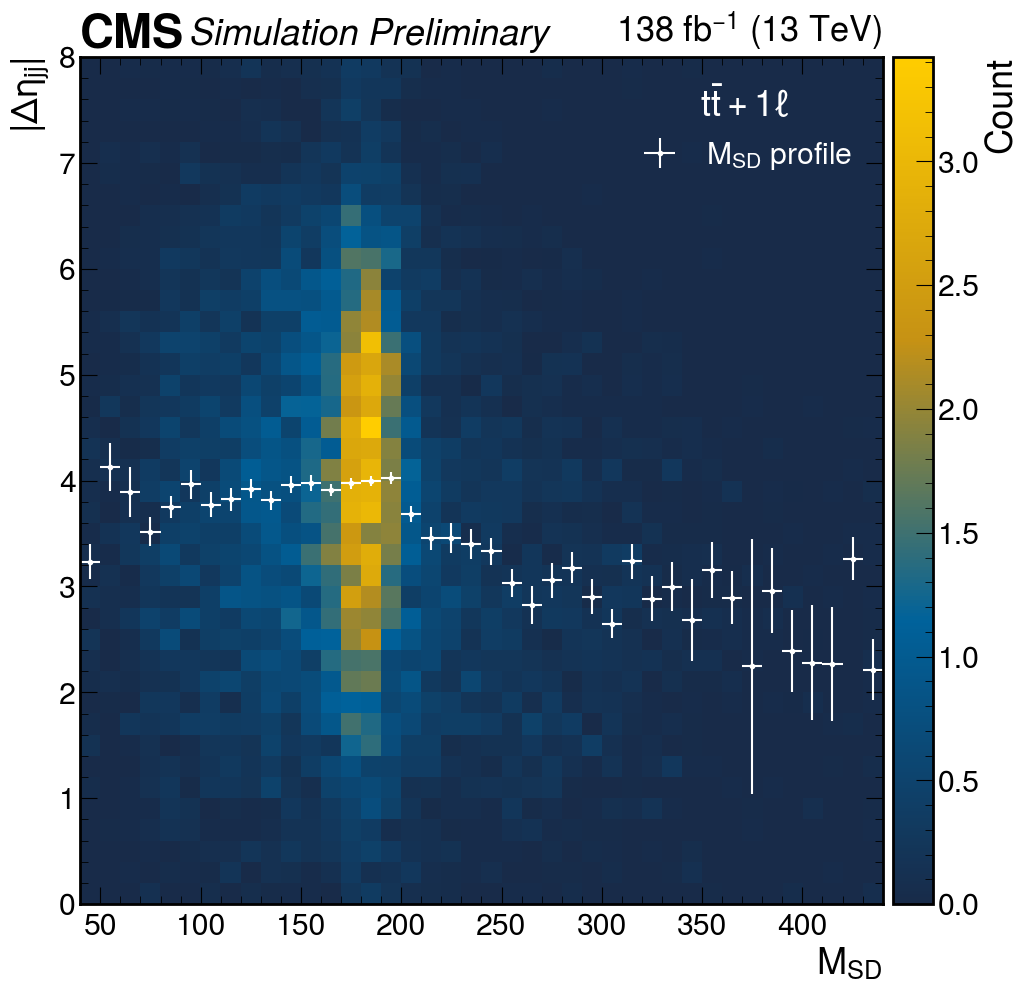

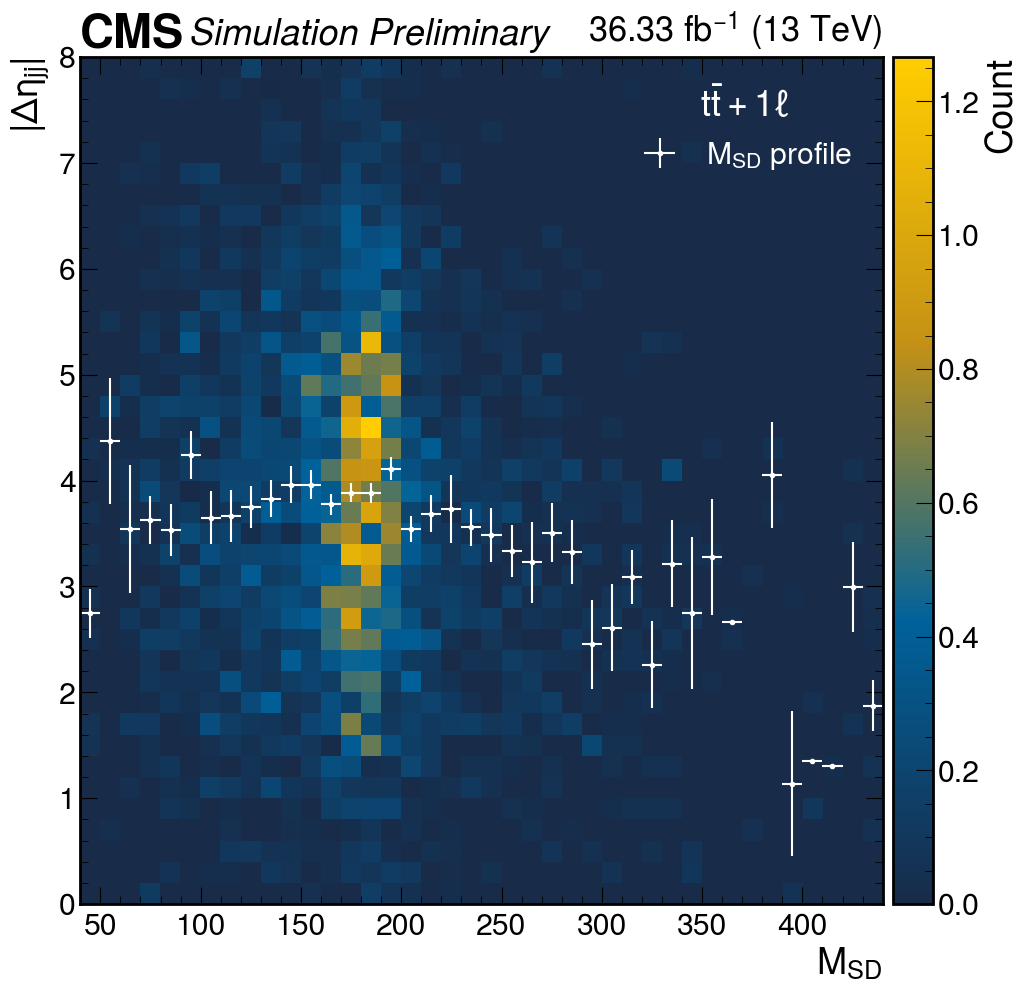

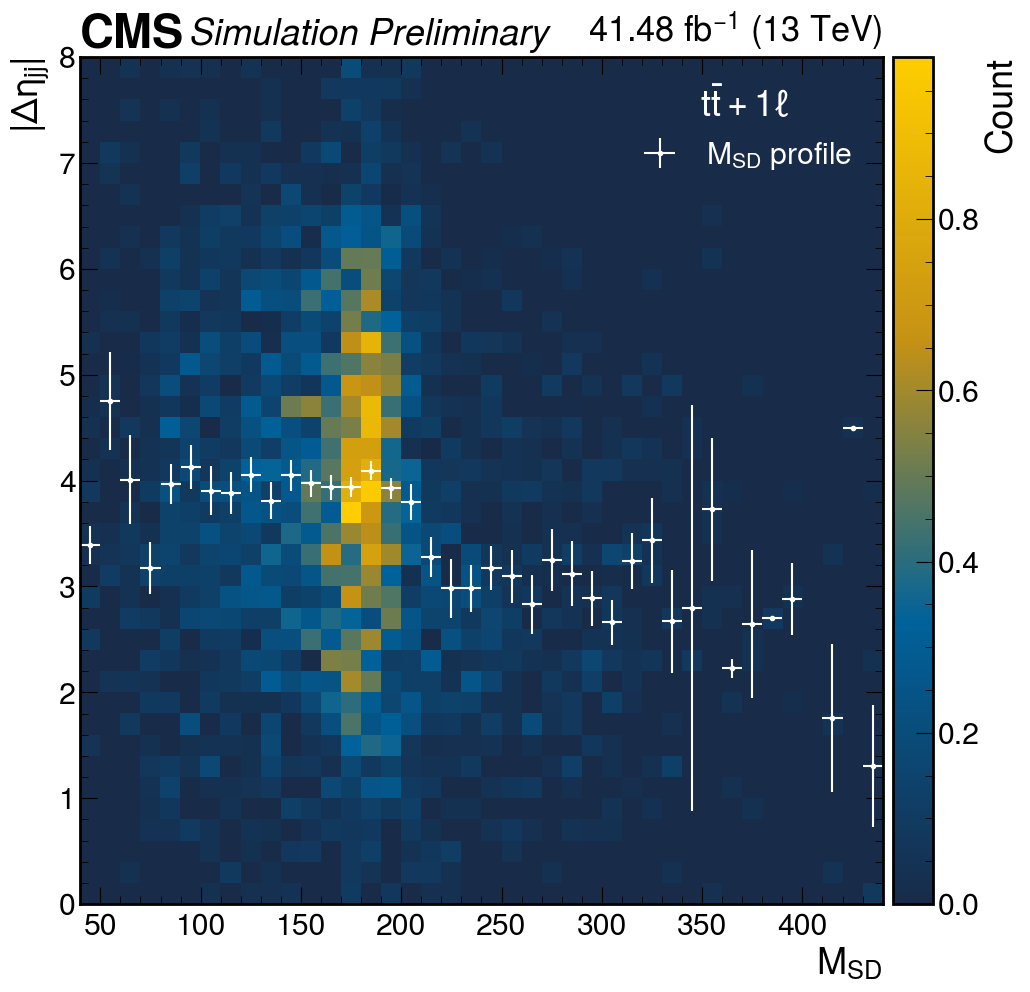

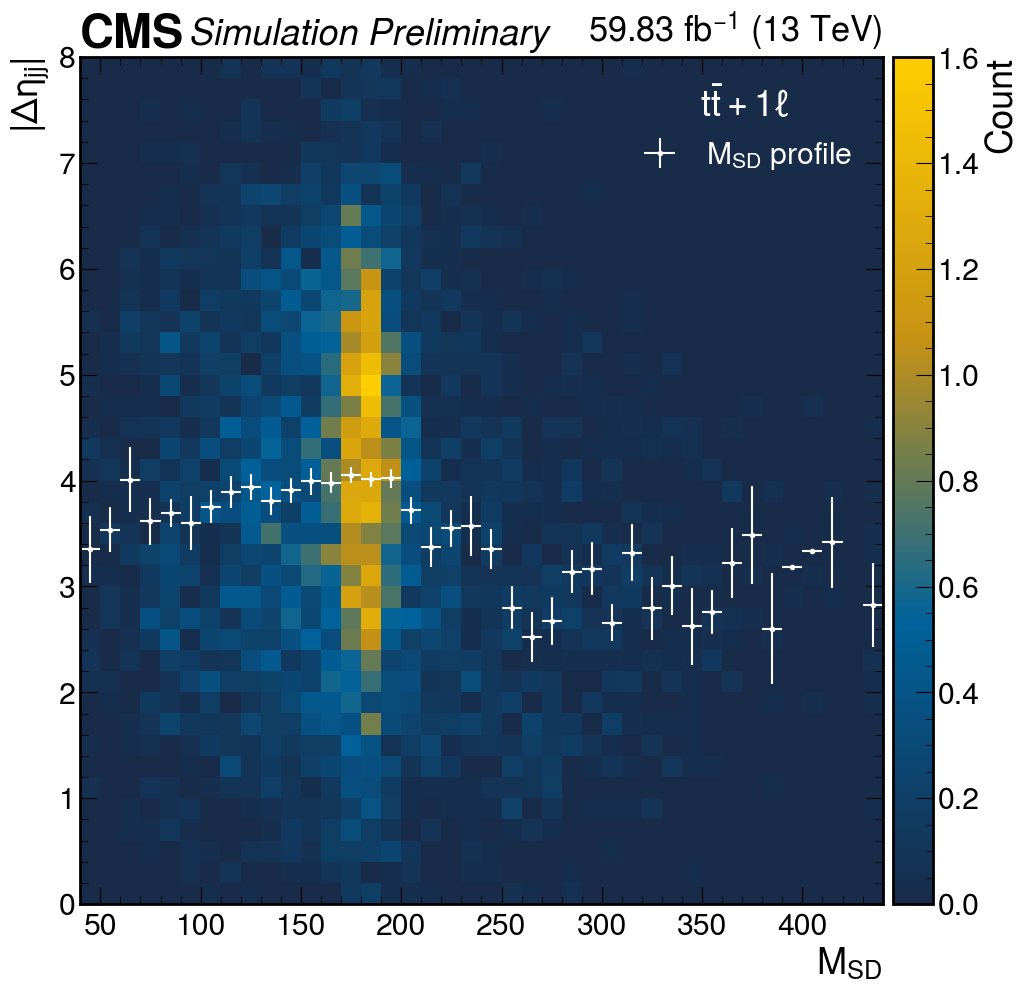

In [39]:
plot_2dcorr(sel="SR_like", sample="TTbar1L", flip=True)
for year in [2016, 2017, 2018]:
    plot_2dcorr(sel="SR_like", sample="TTbar1L", year=year, flip=True)

Saved /home/users/jguiang/public_html/vbswh_plots/btagsf_fix/opt/correlation2D_1Dprofile_TTbar2L.pdf
Saved /home/users/jguiang/public_html/vbswh_plots/btagsf_fix/opt/correlation2D_1Dprofile_TTbar2L_2016.pdf
Saved /home/users/jguiang/public_html/vbswh_plots/btagsf_fix/opt/correlation2D_1Dprofile_TTbar2L_2017.pdf
Saved /home/users/jguiang/public_html/vbswh_plots/btagsf_fix/opt/correlation2D_1Dprofile_TTbar2L_2018.pdf


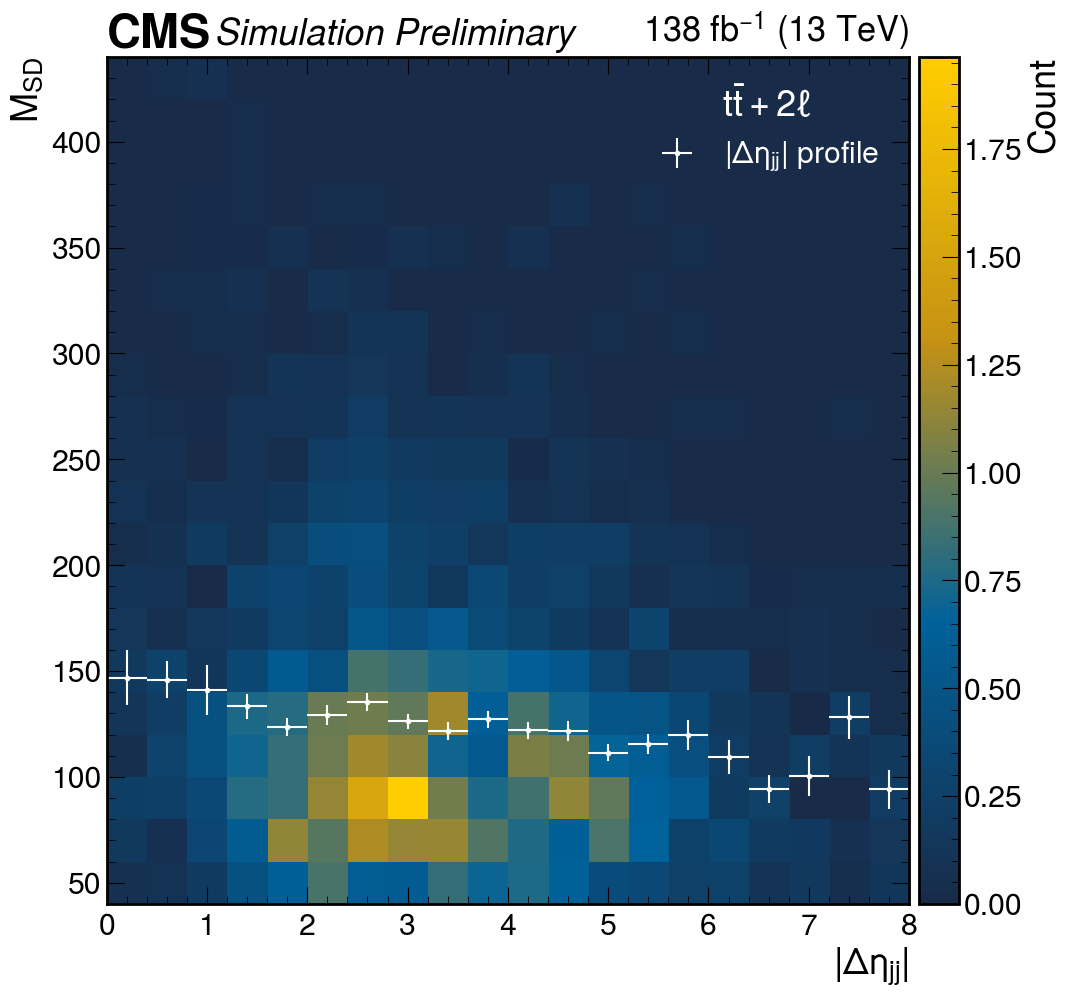

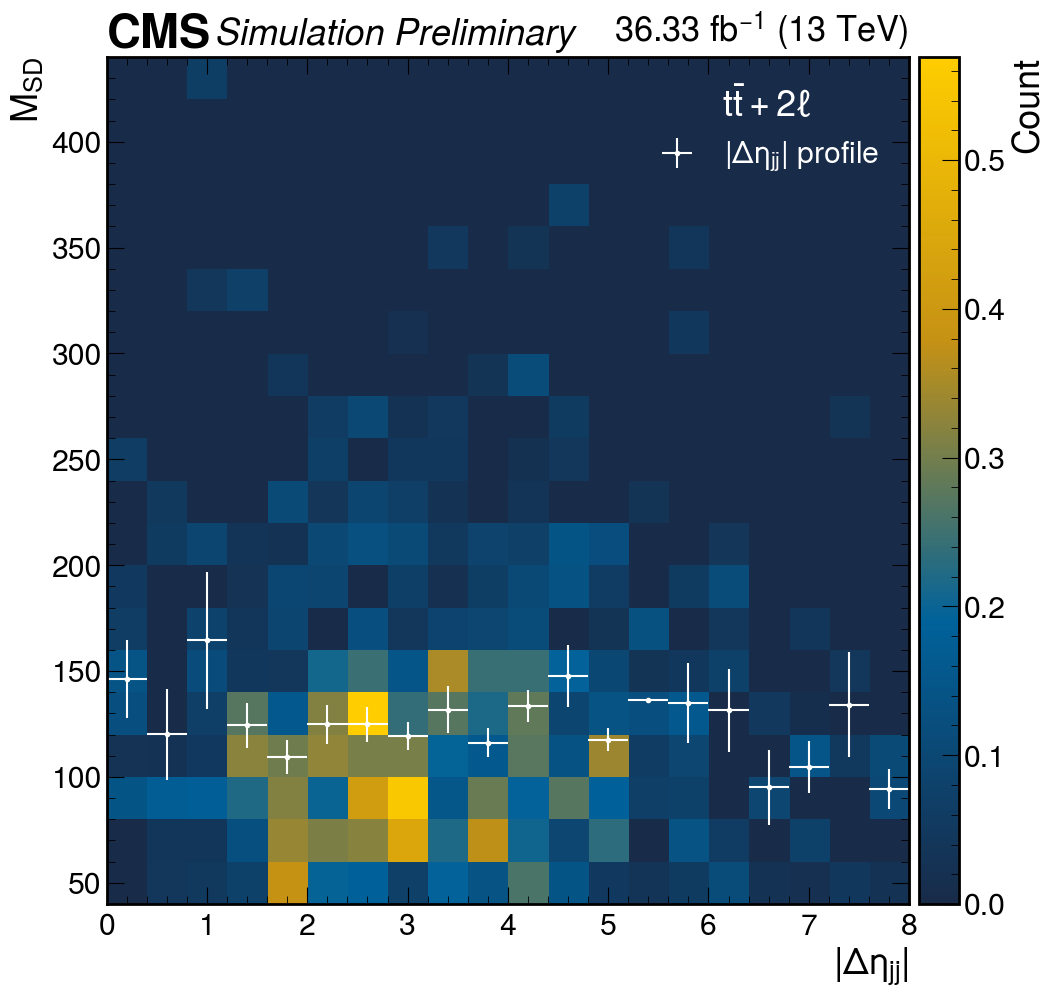

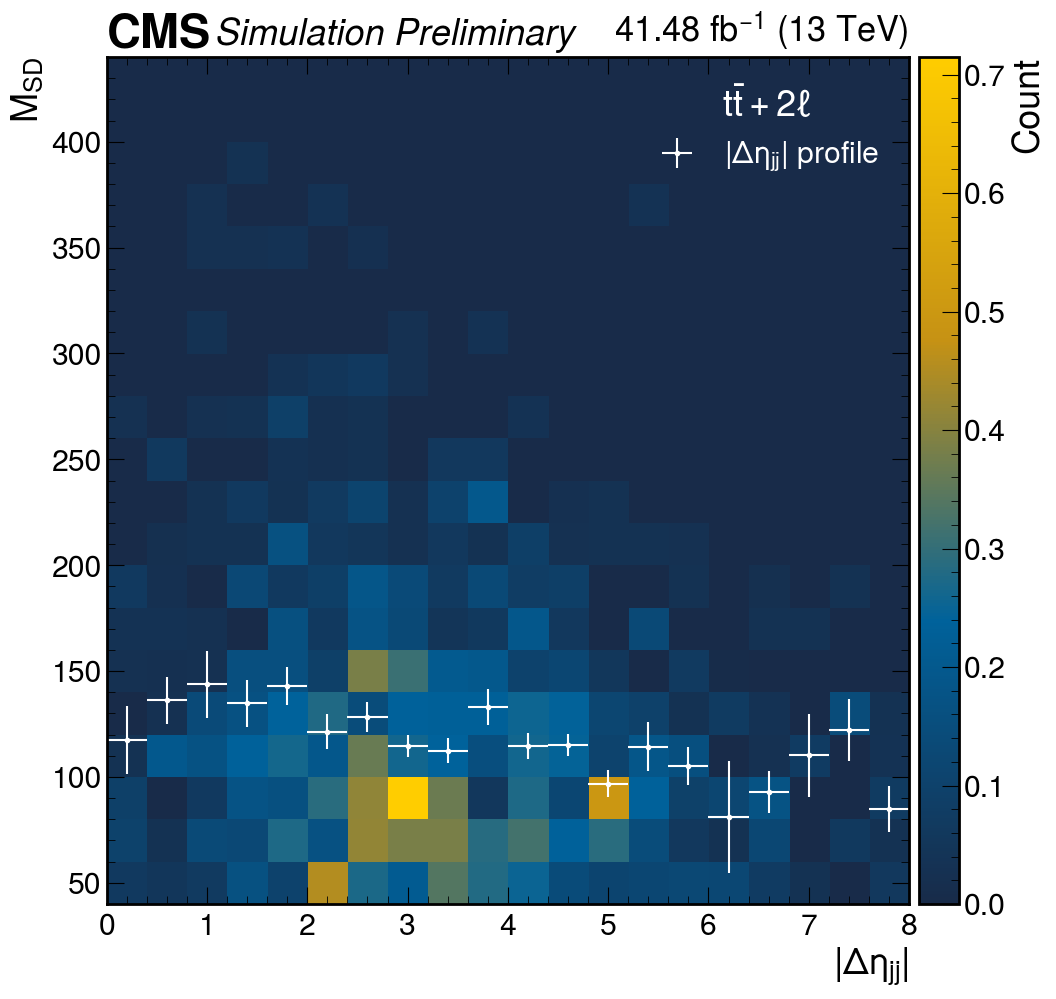

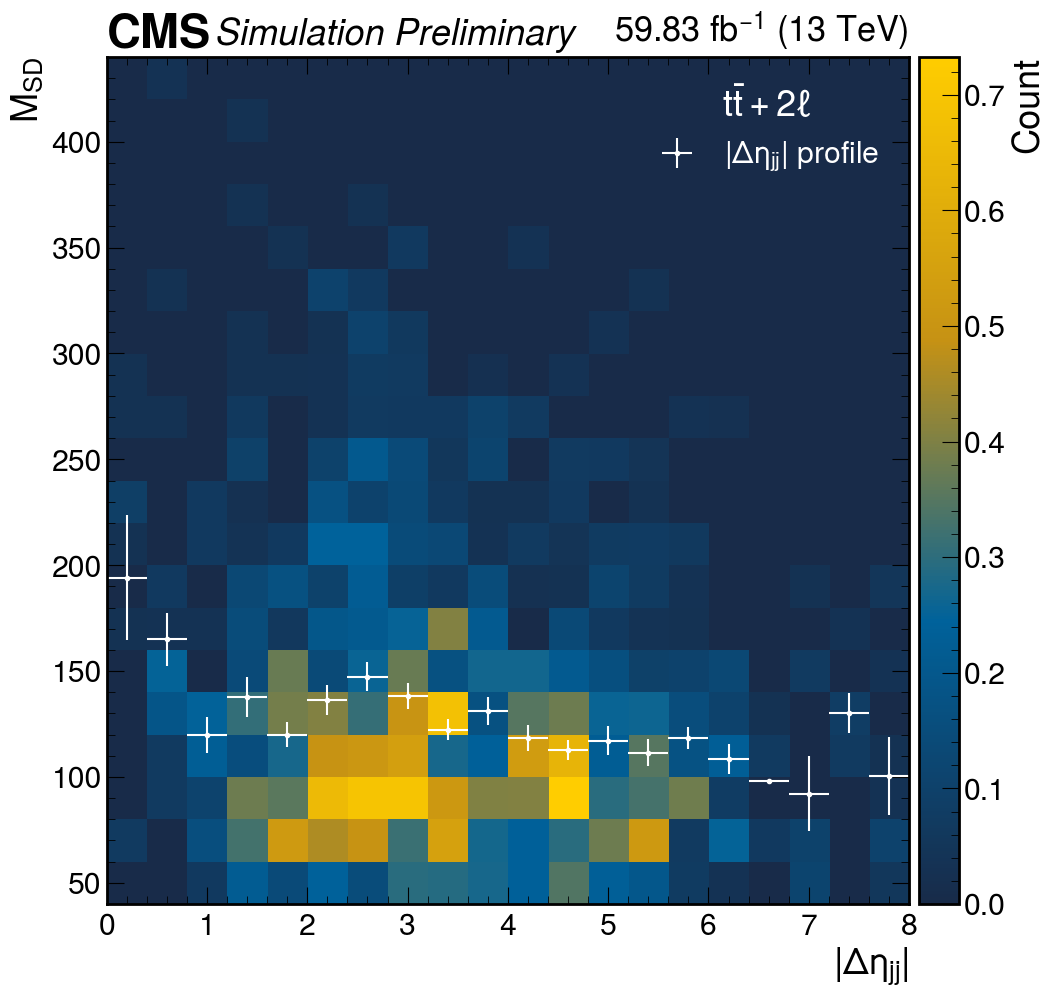

In [50]:
plot_2dcorr(sel="SR_like", sample="TTbar2L", rebin=2)
for year in [2016, 2017, 2018]:
    plot_2dcorr(sel="SR_like", sample="TTbar2L", year=year, rebin=2)

Saved /home/users/jguiang/public_html/vbswh_plots/btagsf_fix/opt/correlation2D_1Dprofile_TTbar2L_flipped.pdf
Saved /home/users/jguiang/public_html/vbswh_plots/btagsf_fix/opt/correlation2D_1Dprofile_TTbar2L_flipped_2016.pdf
Saved /home/users/jguiang/public_html/vbswh_plots/btagsf_fix/opt/correlation2D_1Dprofile_TTbar2L_flipped_2017.pdf
Saved /home/users/jguiang/public_html/vbswh_plots/btagsf_fix/opt/correlation2D_1Dprofile_TTbar2L_flipped_2018.pdf


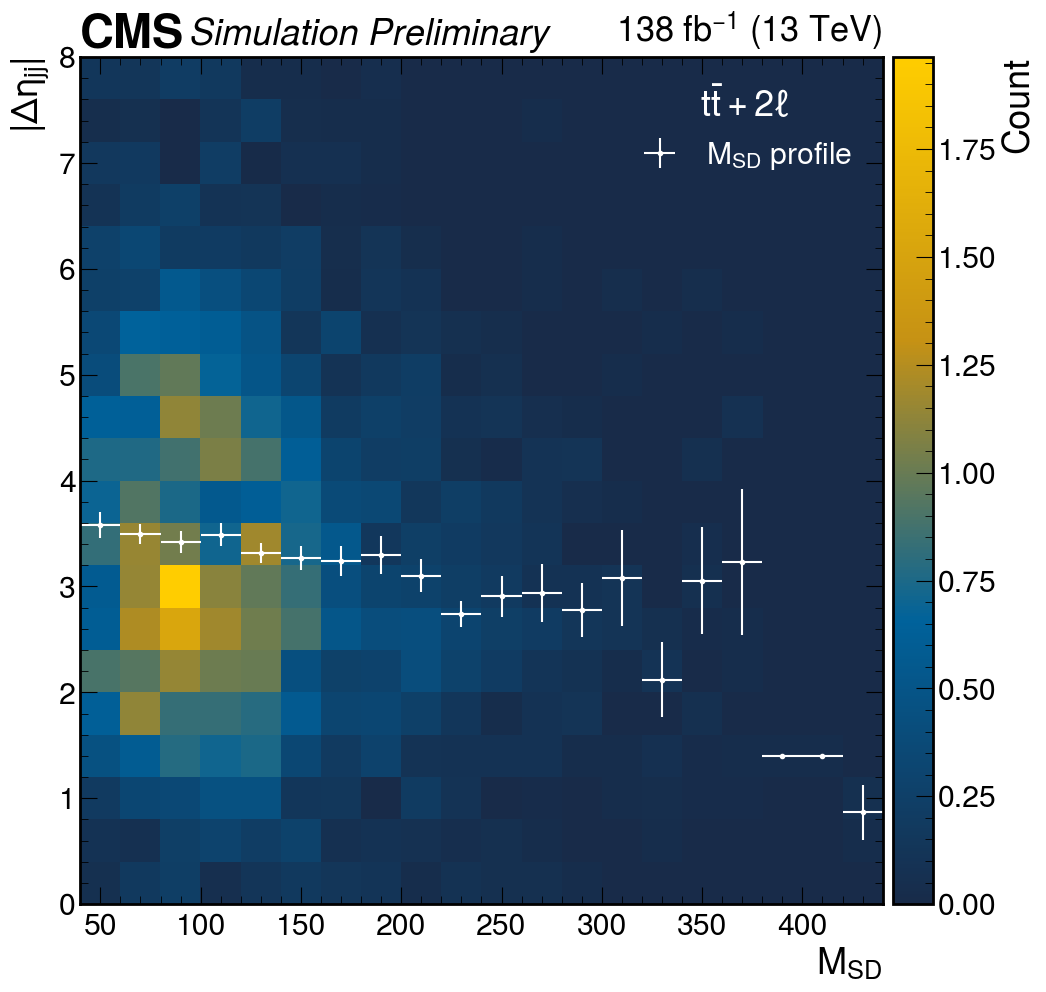

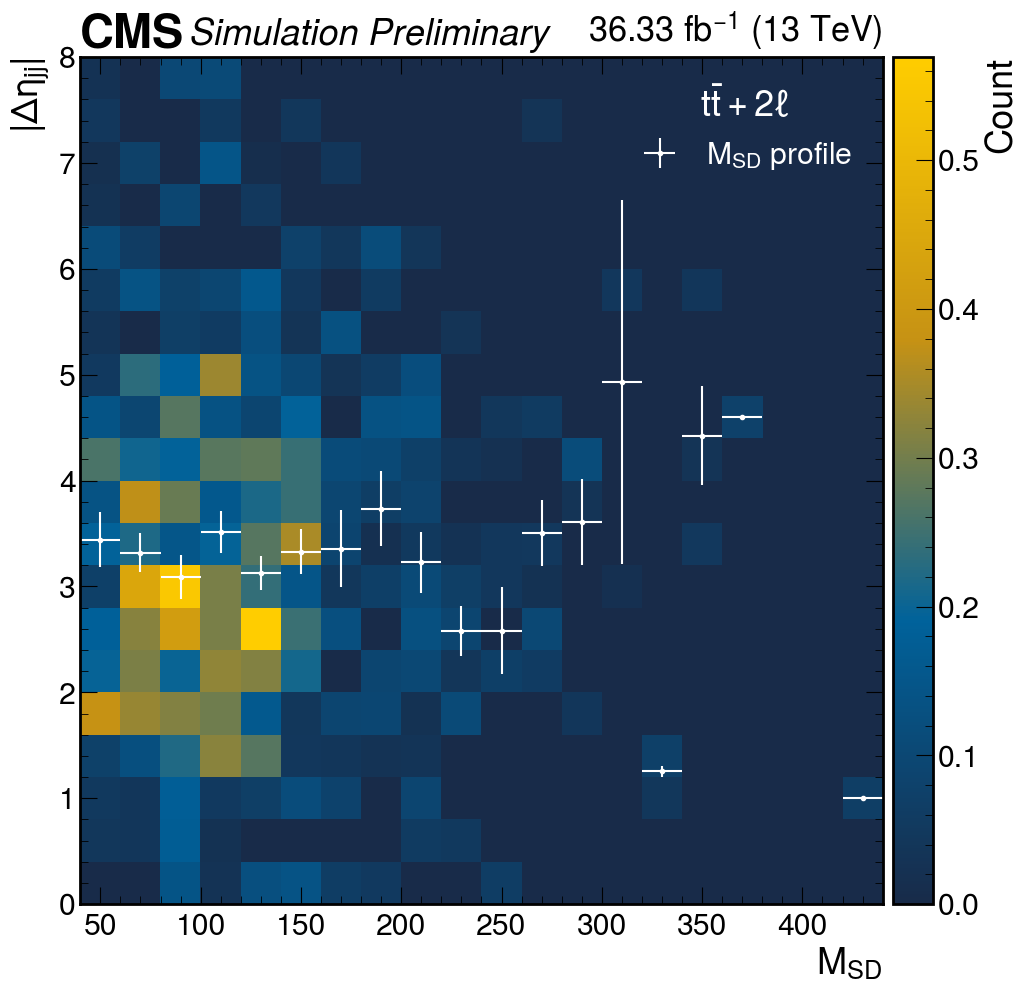

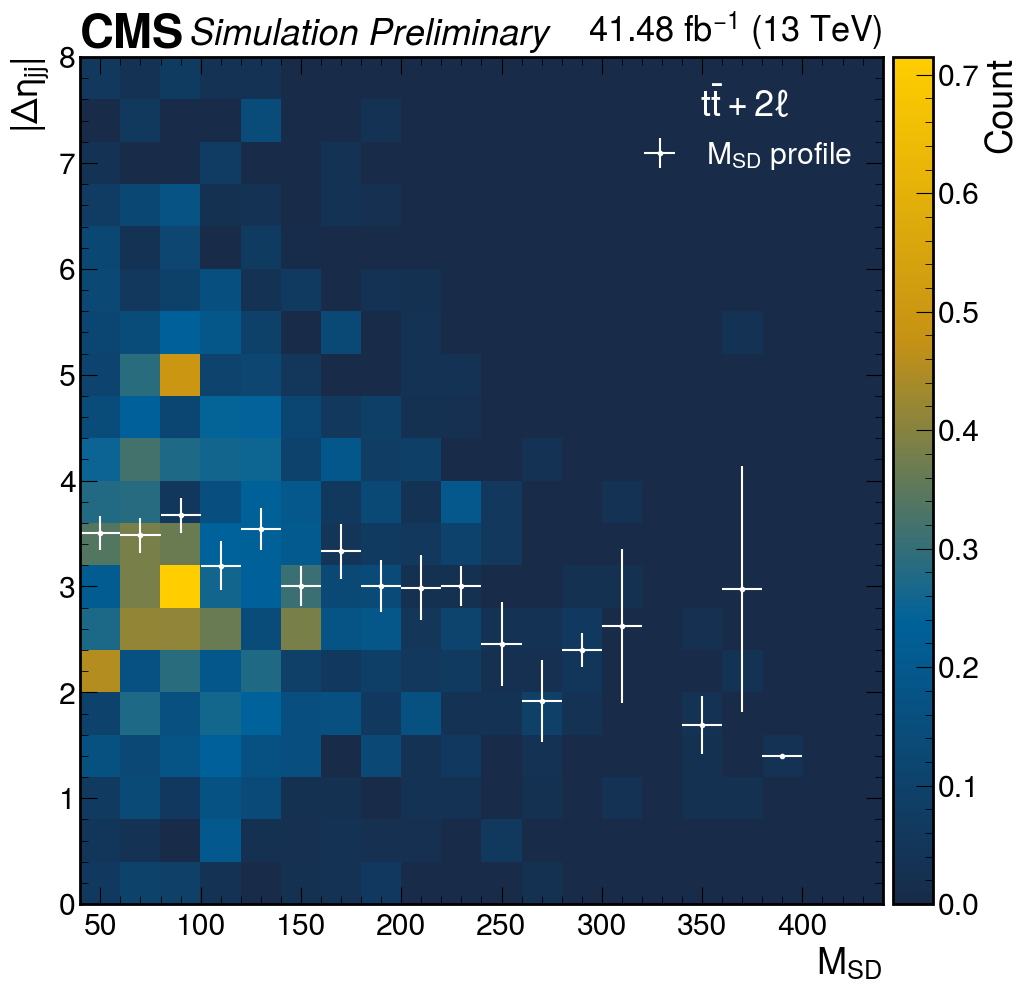

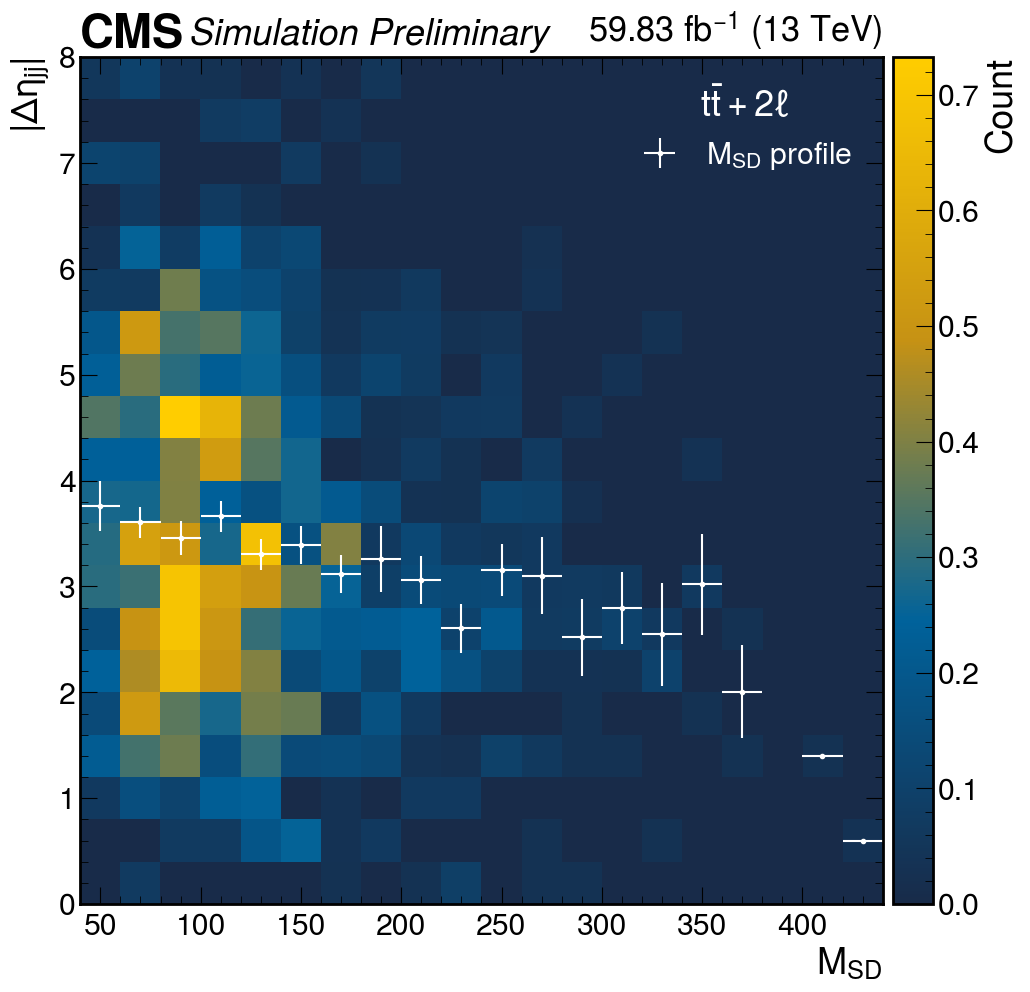

In [49]:
plot_2dcorr(sel="SR_like", sample="TTbar2L", rebin=2, flip=True)
for year in [2016, 2017, 2018]:
    plot_2dcorr(sel="SR_like", sample="TTbar2L", year=year, rebin=2, flip=True)

Saved /home/users/jguiang/public_html/vbswh_plots/btagsf_fix/opt/correlation2D_1Dprofile_WJets.pdf
Saved /home/users/jguiang/public_html/vbswh_plots/btagsf_fix/opt/correlation2D_1Dprofile_WJets_2016.pdf
Saved /home/users/jguiang/public_html/vbswh_plots/btagsf_fix/opt/correlation2D_1Dprofile_WJets_2017.pdf
Saved /home/users/jguiang/public_html/vbswh_plots/btagsf_fix/opt/correlation2D_1Dprofile_WJets_2018.pdf


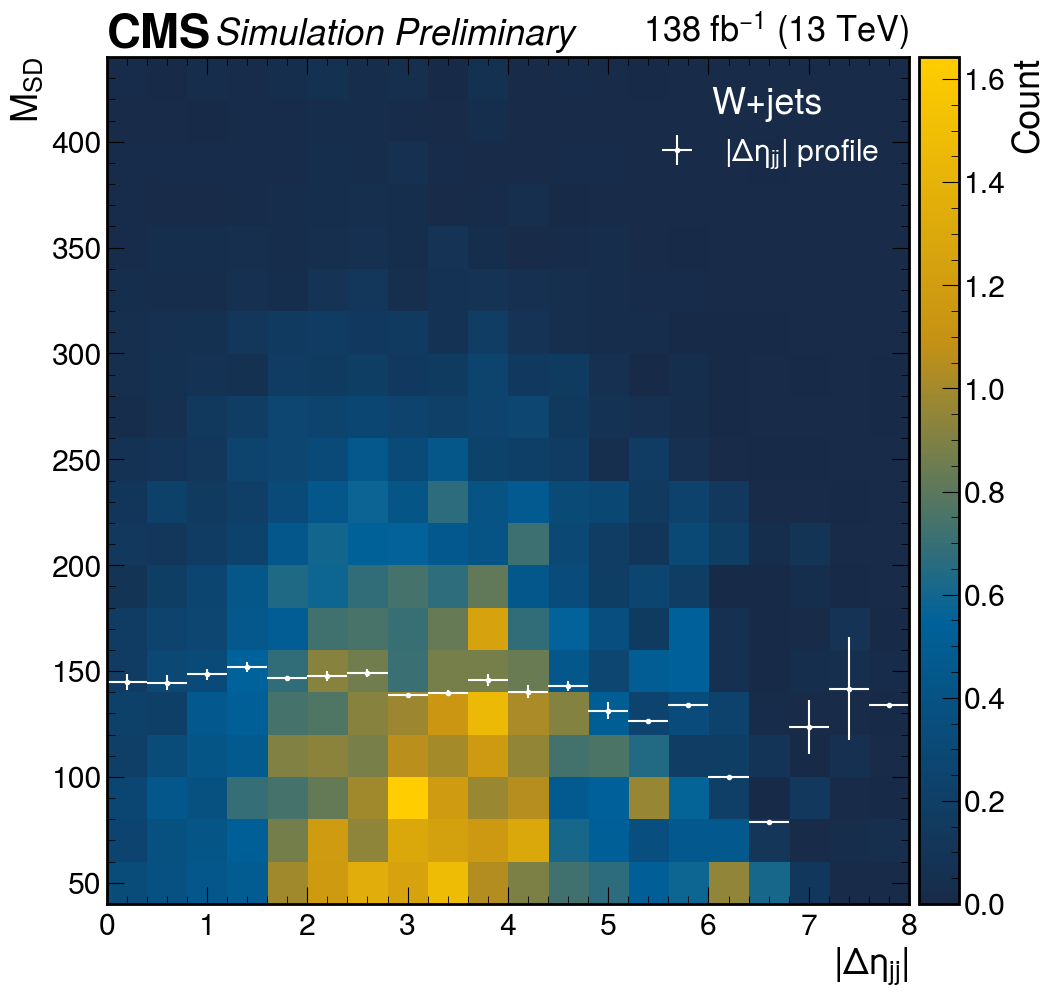

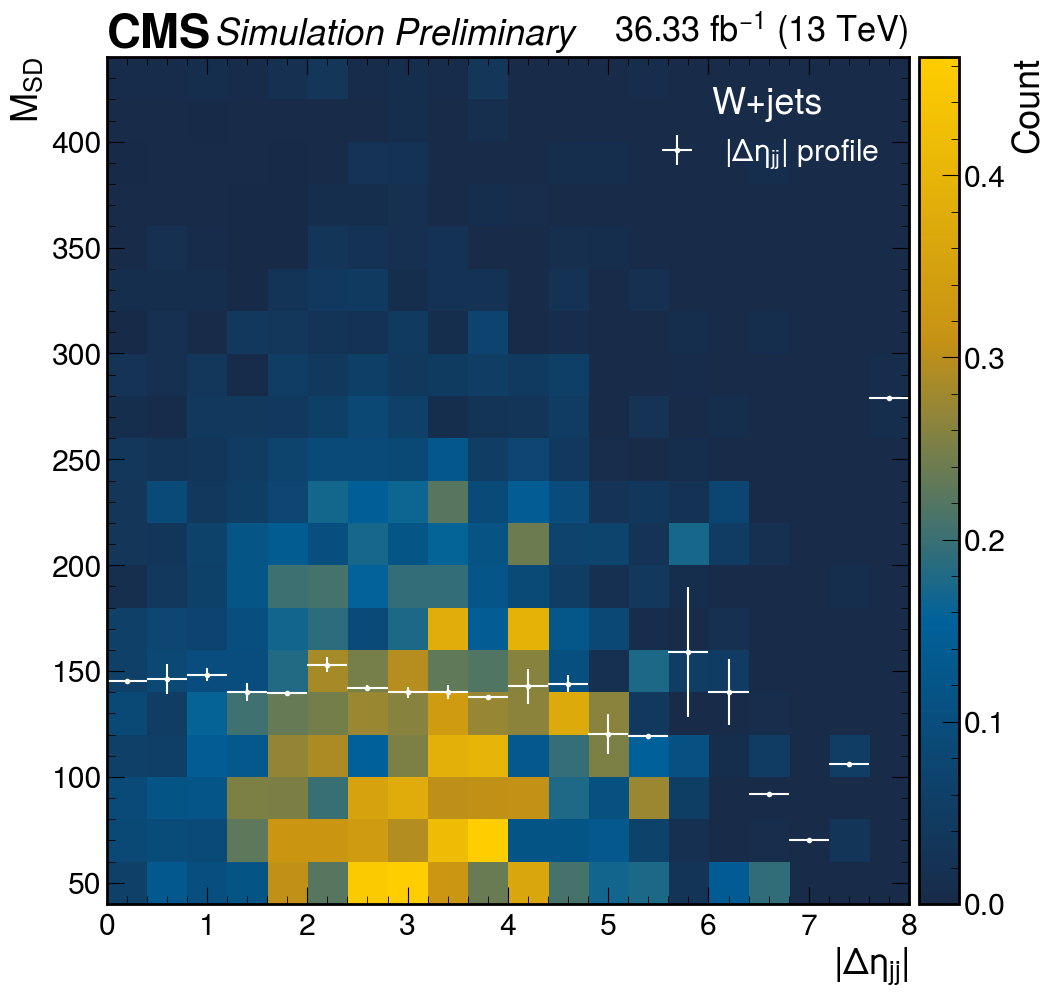

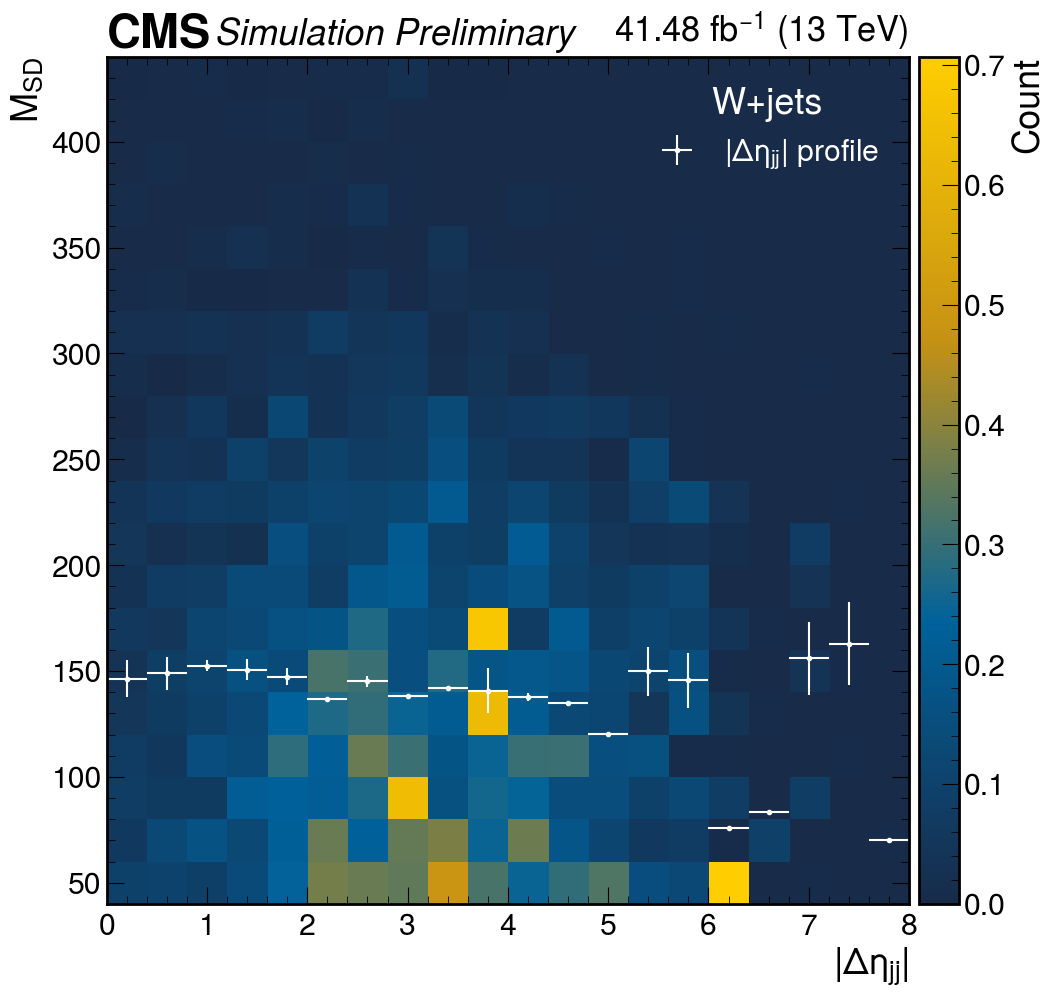

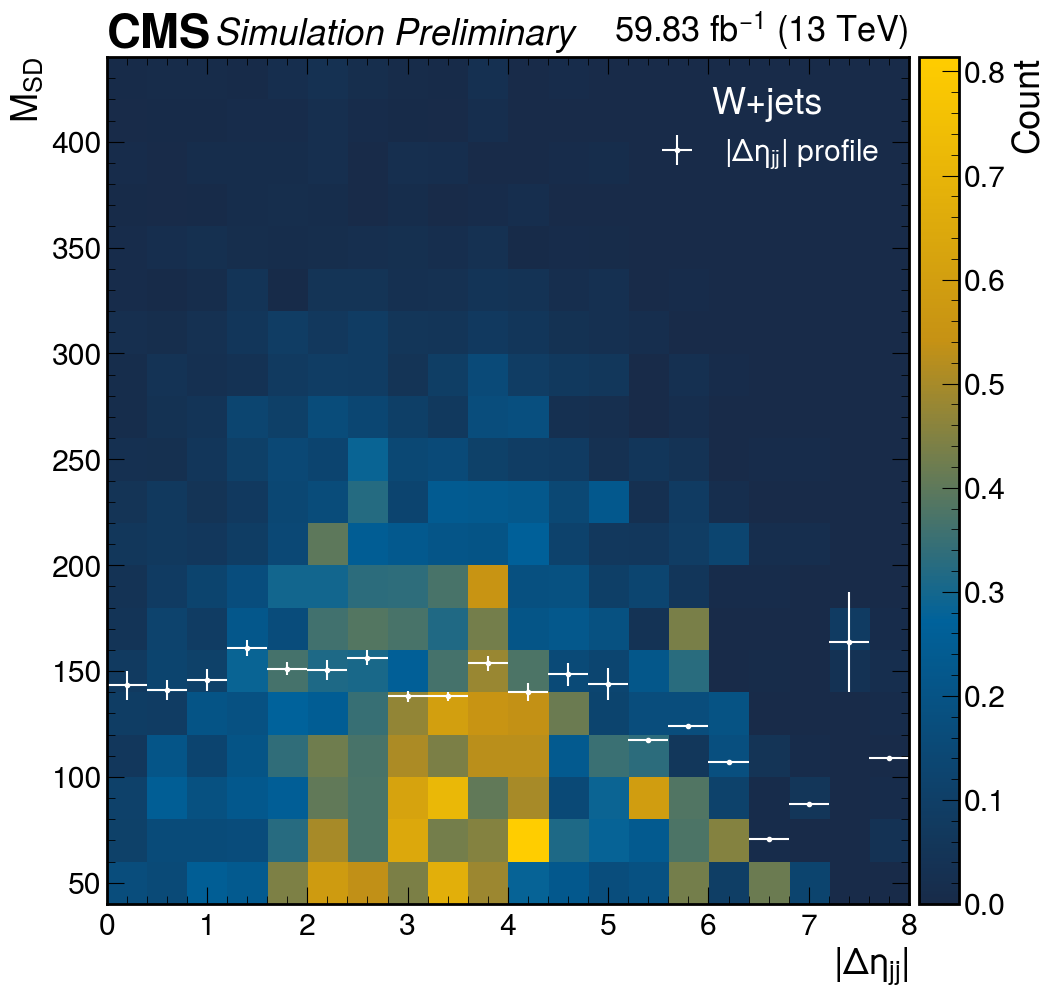

In [43]:
plot_2dcorr(sel="SR_like", sample="WJets", rebin=2)
for year in [2016, 2017, 2018]:
    plot_2dcorr(sel="SR_like", sample="WJets", year=year, rebin=2)

Saved /home/users/jguiang/public_html/vbswh_plots/btagsf_fix/opt/correlation2D_1Dprofile_WJets_flipped.pdf
Saved /home/users/jguiang/public_html/vbswh_plots/btagsf_fix/opt/correlation2D_1Dprofile_WJets_flipped_2016.pdf
Saved /home/users/jguiang/public_html/vbswh_plots/btagsf_fix/opt/correlation2D_1Dprofile_WJets_flipped_2017.pdf
Saved /home/users/jguiang/public_html/vbswh_plots/btagsf_fix/opt/correlation2D_1Dprofile_WJets_flipped_2018.pdf


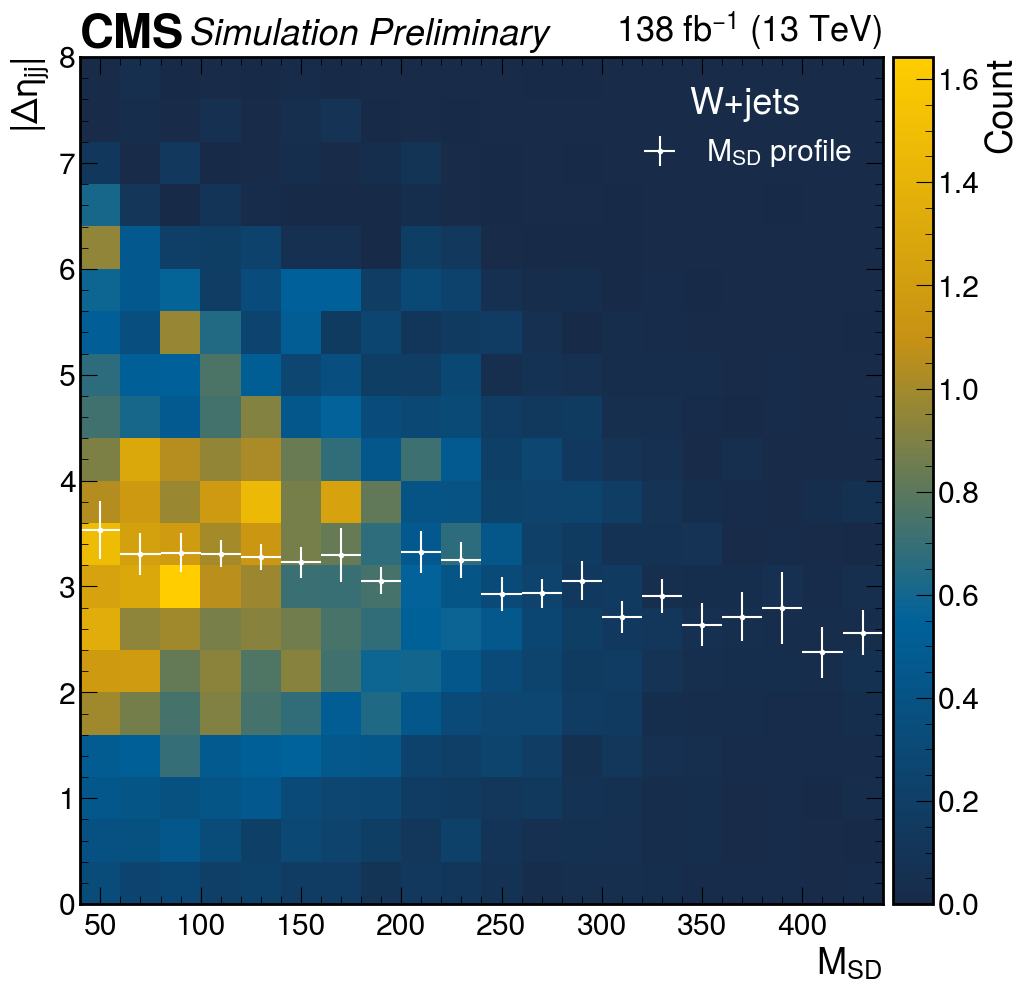

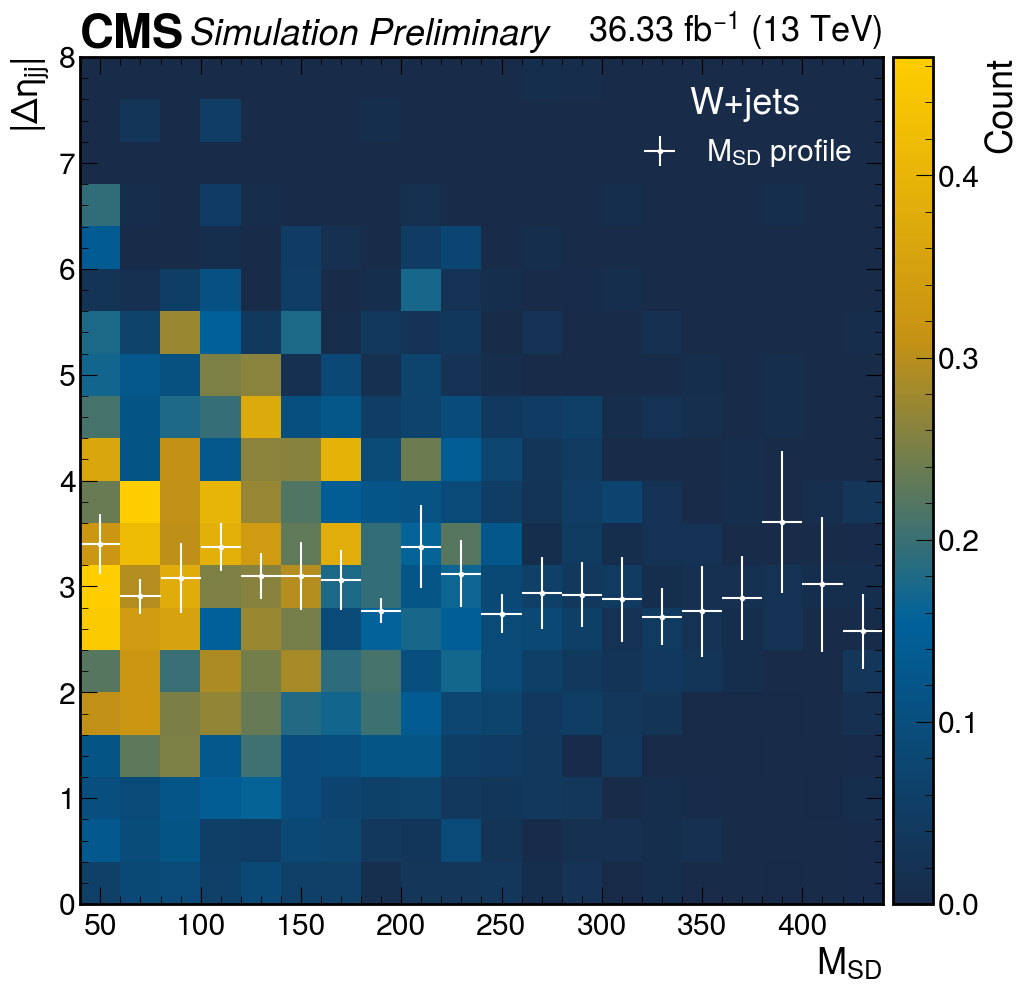

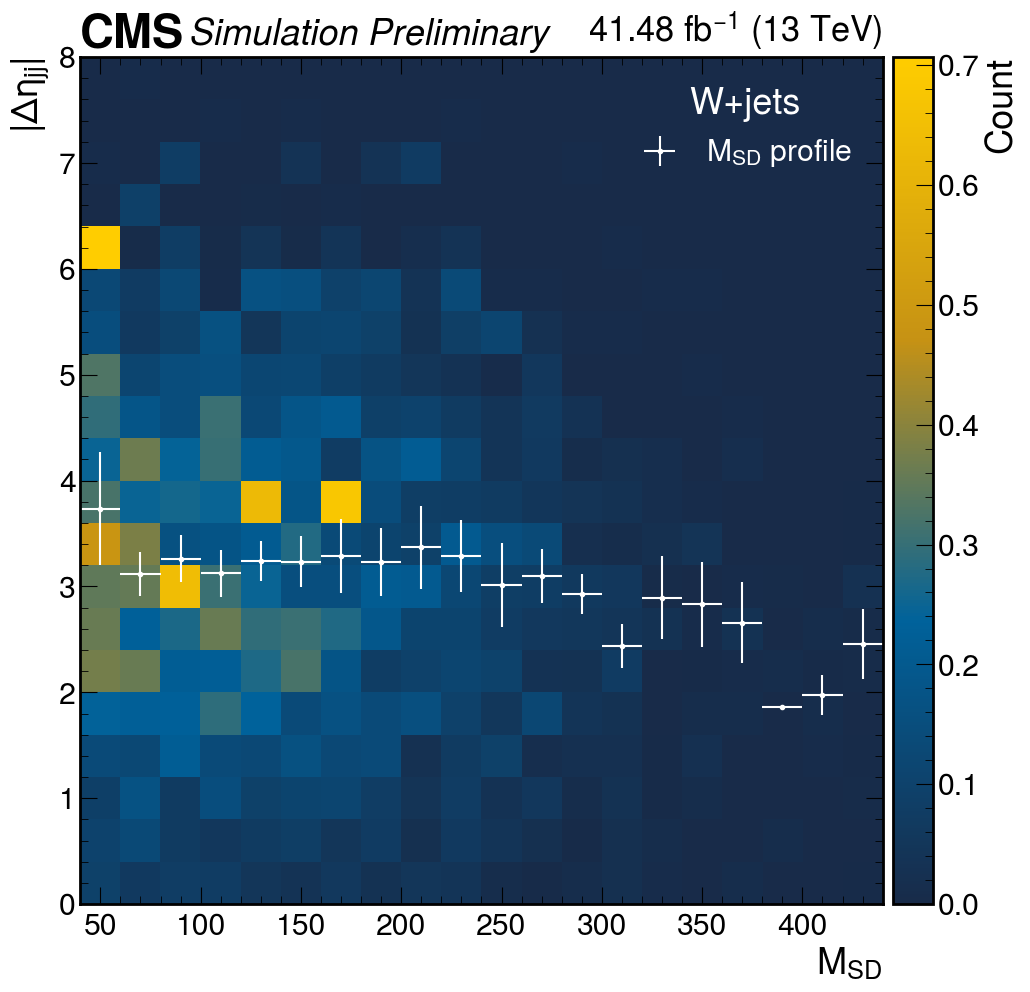

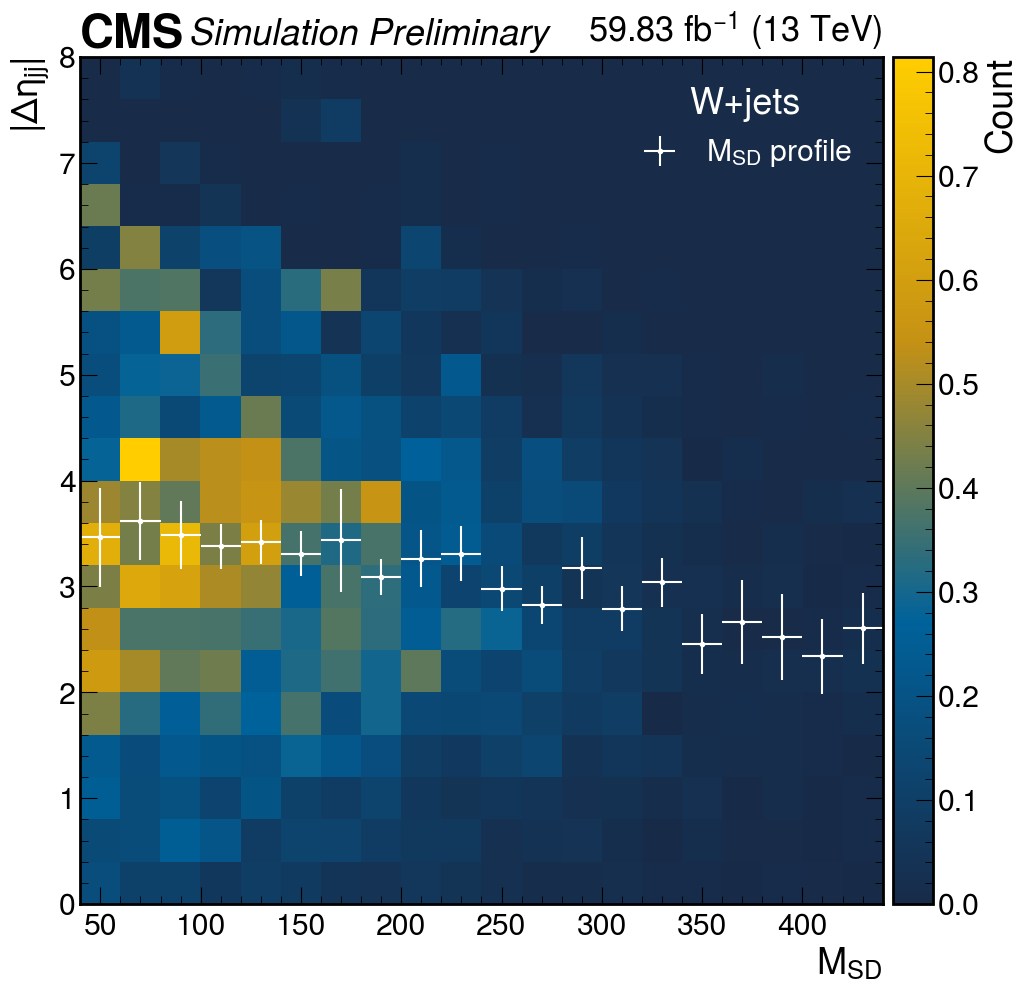

In [51]:
plot_2dcorr(sel="SR_like", sample="WJets", rebin=2, flip=True)
for year in [2016, 2017, 2018]:
    plot_2dcorr(sel="SR_like", sample="WJets", year=year, rebin=2, flip=True)

Saved /home/users/jguiang/public_html/vbswh_plots/btagsf_fix/opt/correlation2D_1Dprofile_Bosons.pdf
Saved /home/users/jguiang/public_html/vbswh_plots/btagsf_fix/opt/correlation2D_1Dprofile_Bosons_2016.pdf
Saved /home/users/jguiang/public_html/vbswh_plots/btagsf_fix/opt/correlation2D_1Dprofile_Bosons_2017.pdf
Saved /home/users/jguiang/public_html/vbswh_plots/btagsf_fix/opt/correlation2D_1Dprofile_Bosons_2018.pdf


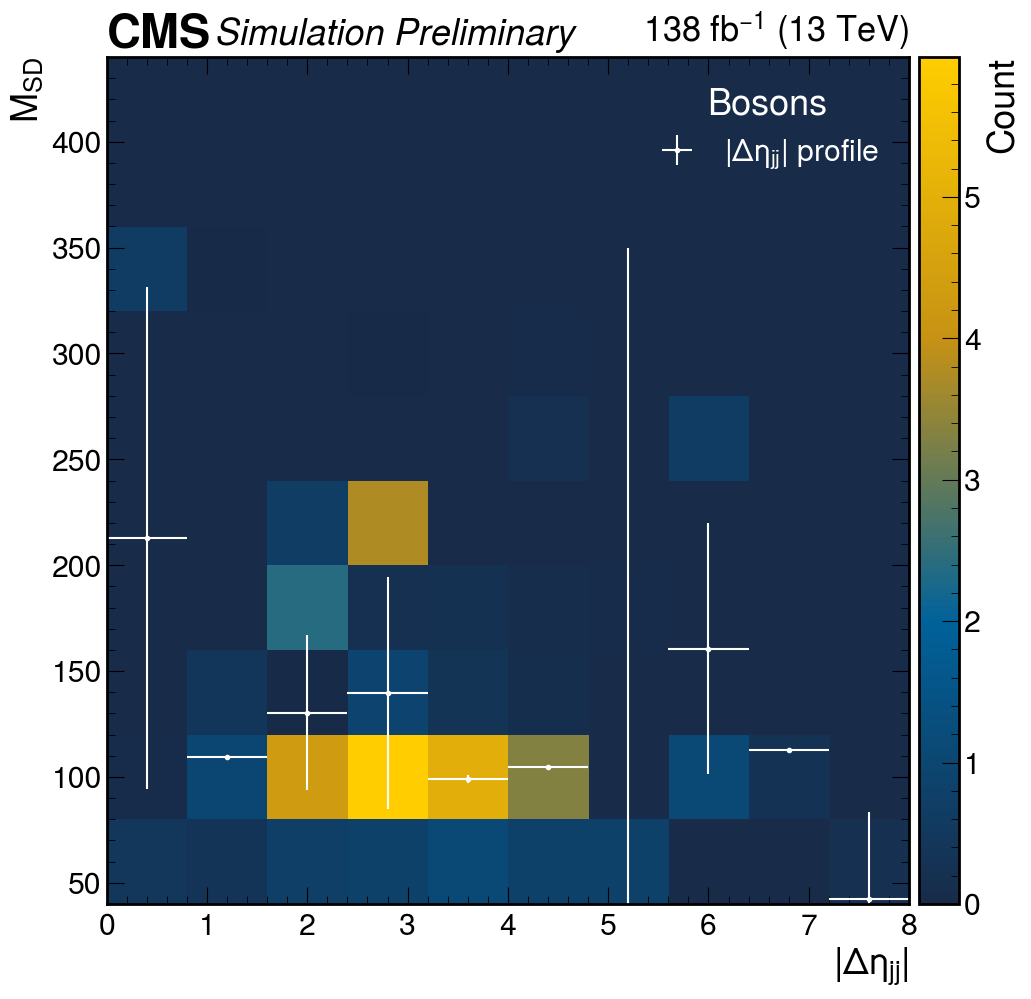

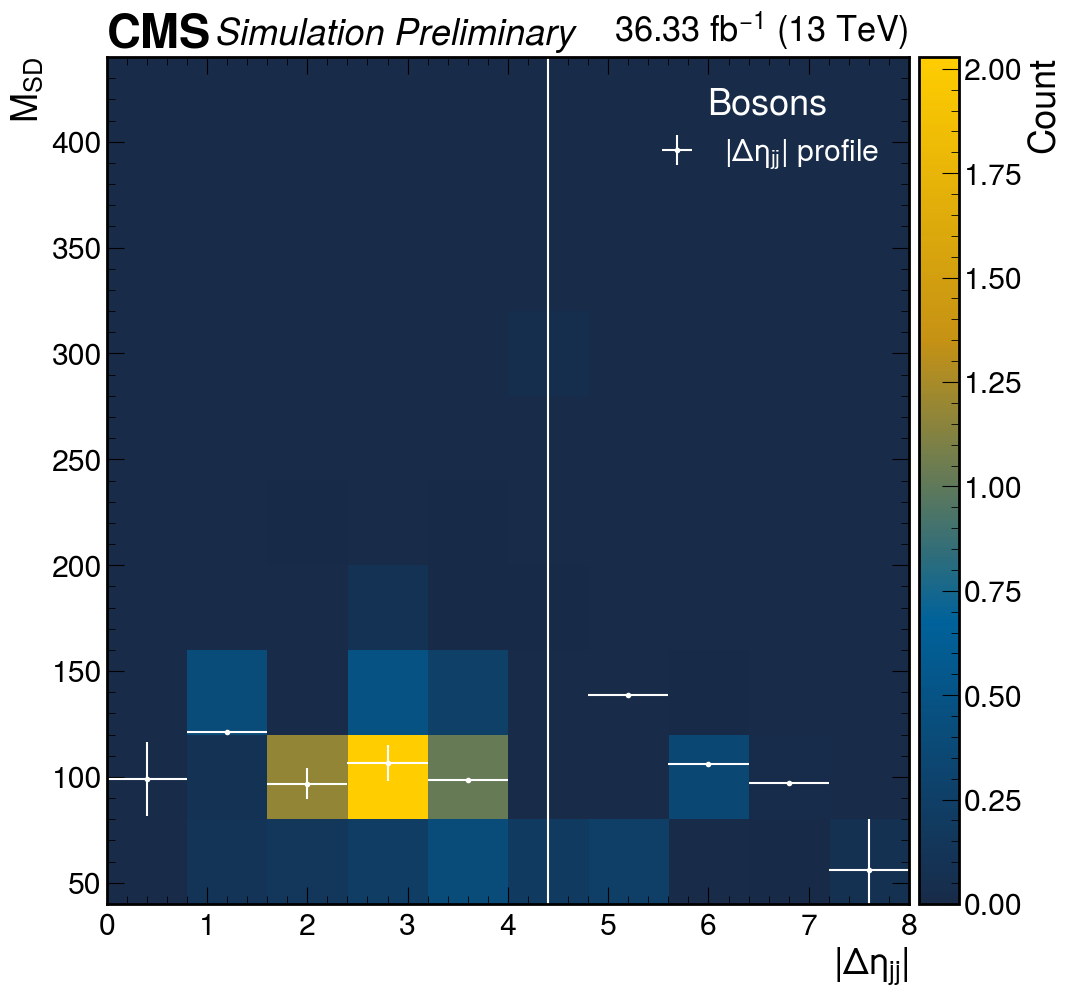

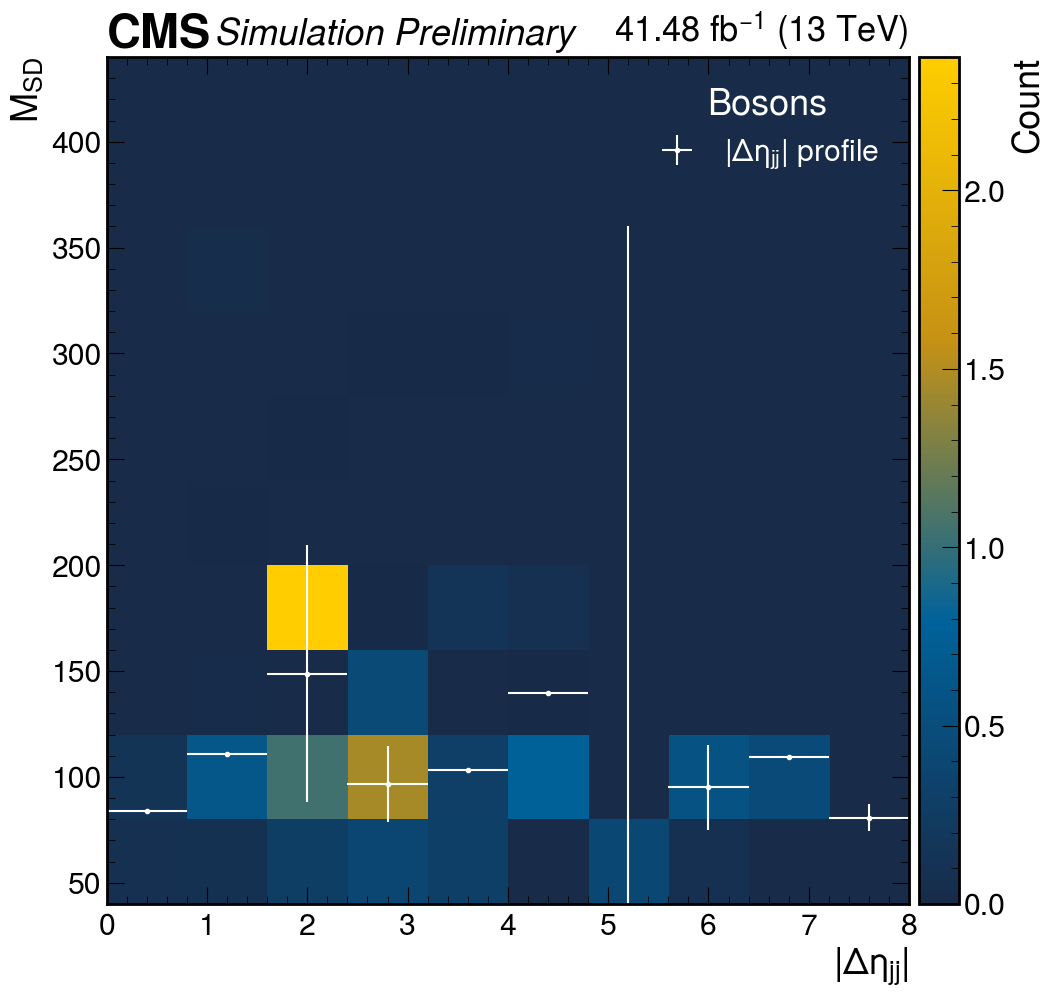

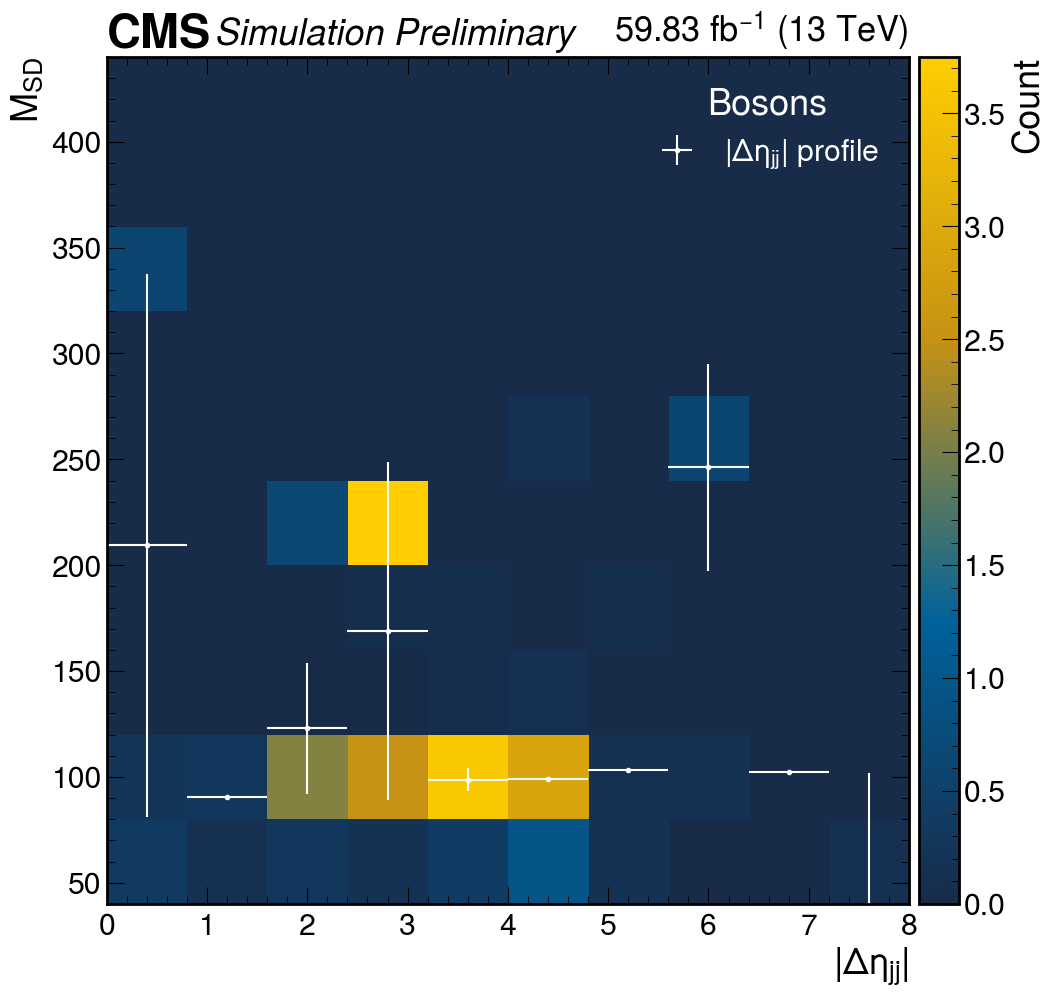

In [48]:
plot_2dcorr(sel="SR_like", sample="Bosons", rebin=4)
for year in [2016, 2017, 2018]:
    plot_2dcorr(sel="SR_like", sample="Bosons", year=year, rebin=4)

Saved /home/users/jguiang/public_html/vbswh_plots/btagsf_fix/opt/correlation2D_1Dprofile_Bosons_flipped.pdf
Saved /home/users/jguiang/public_html/vbswh_plots/btagsf_fix/opt/correlation2D_1Dprofile_Bosons_flipped_2016.pdf
Saved /home/users/jguiang/public_html/vbswh_plots/btagsf_fix/opt/correlation2D_1Dprofile_Bosons_flipped_2017.pdf
Saved /home/users/jguiang/public_html/vbswh_plots/btagsf_fix/opt/correlation2D_1Dprofile_Bosons_flipped_2018.pdf


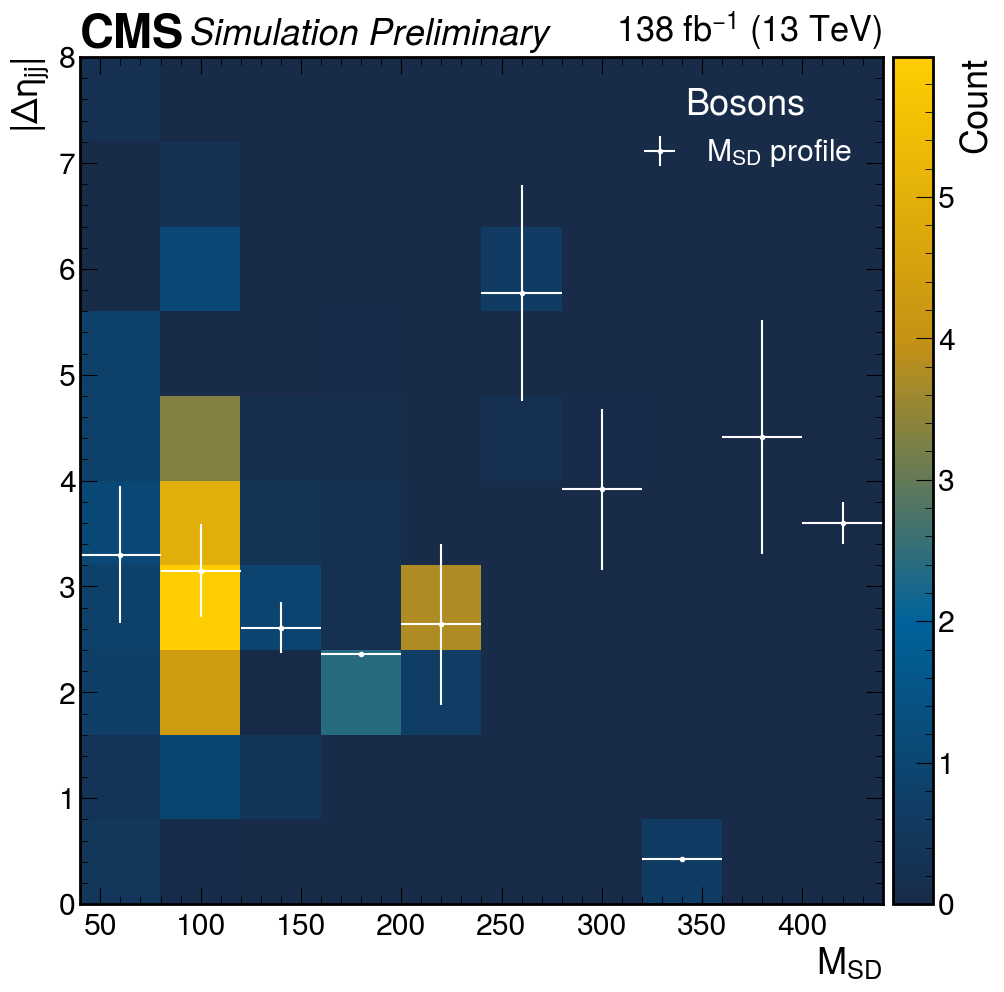

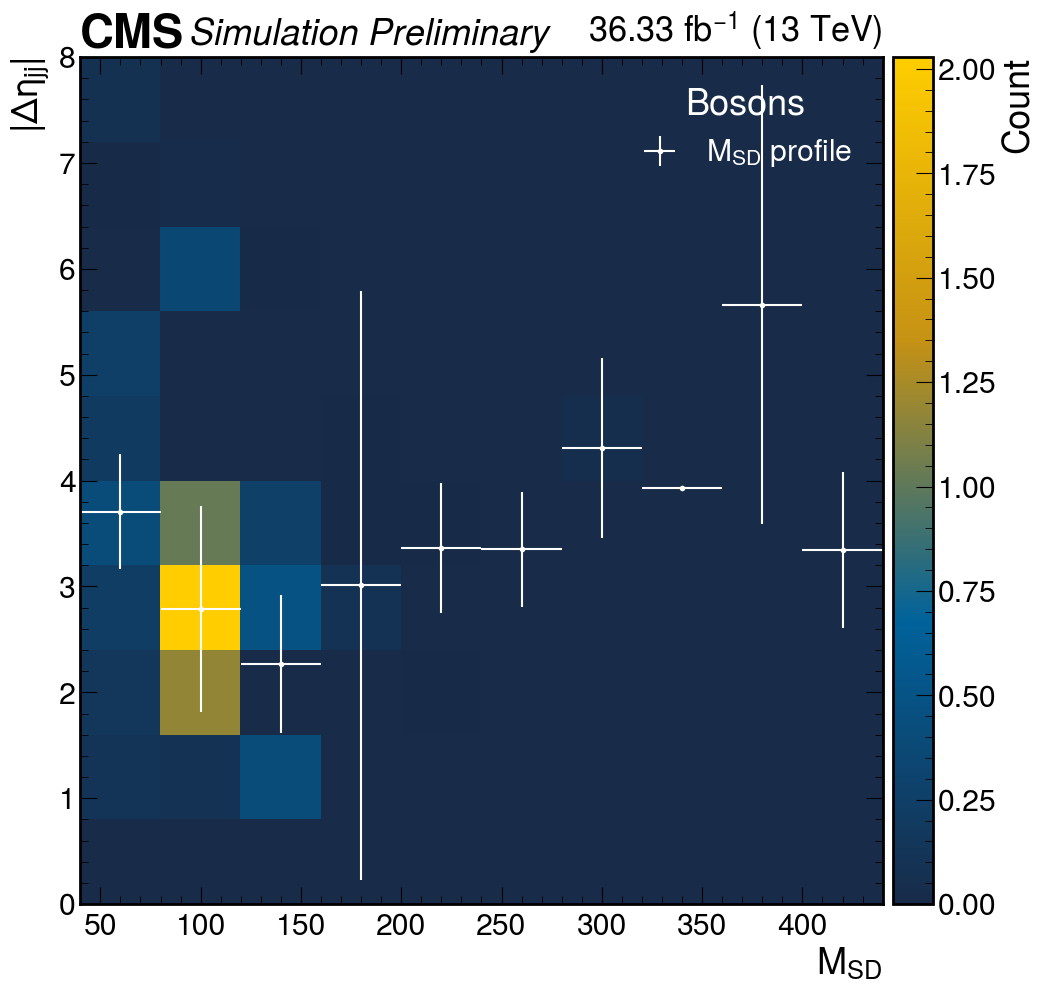

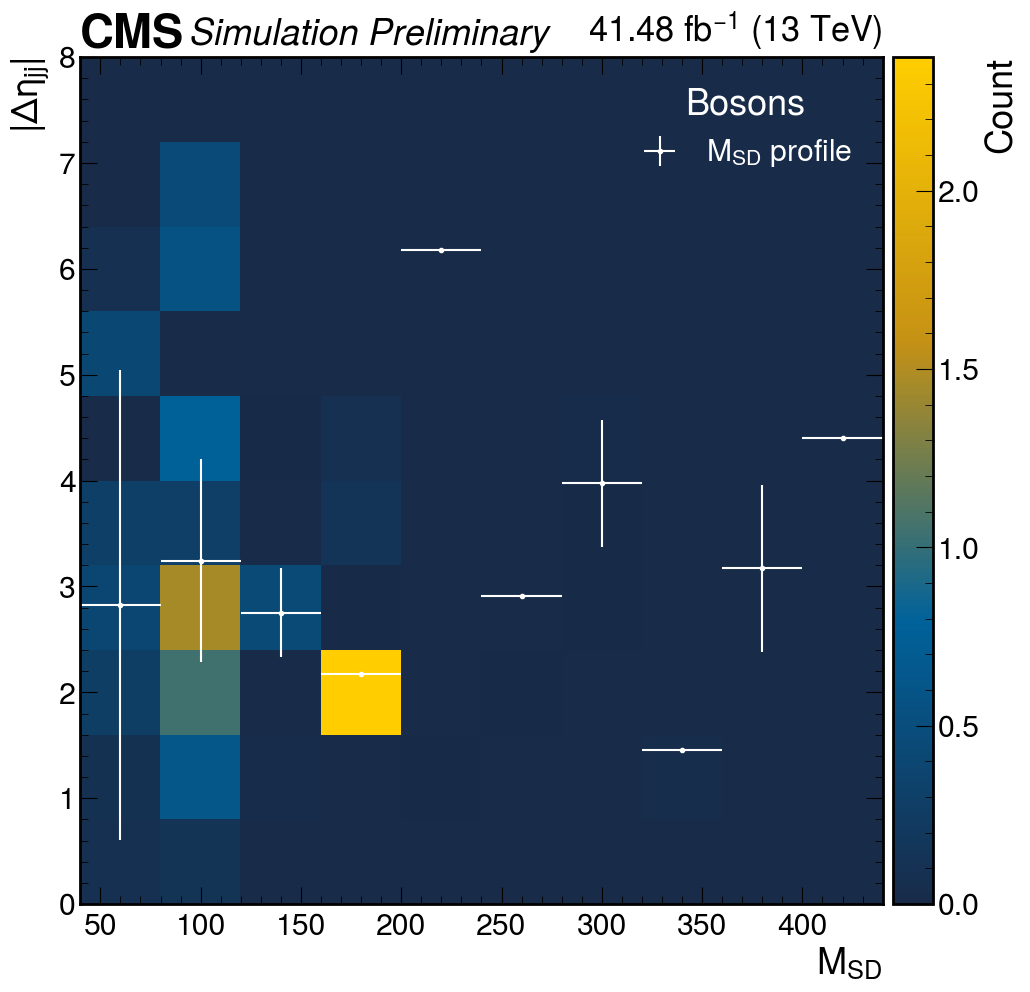

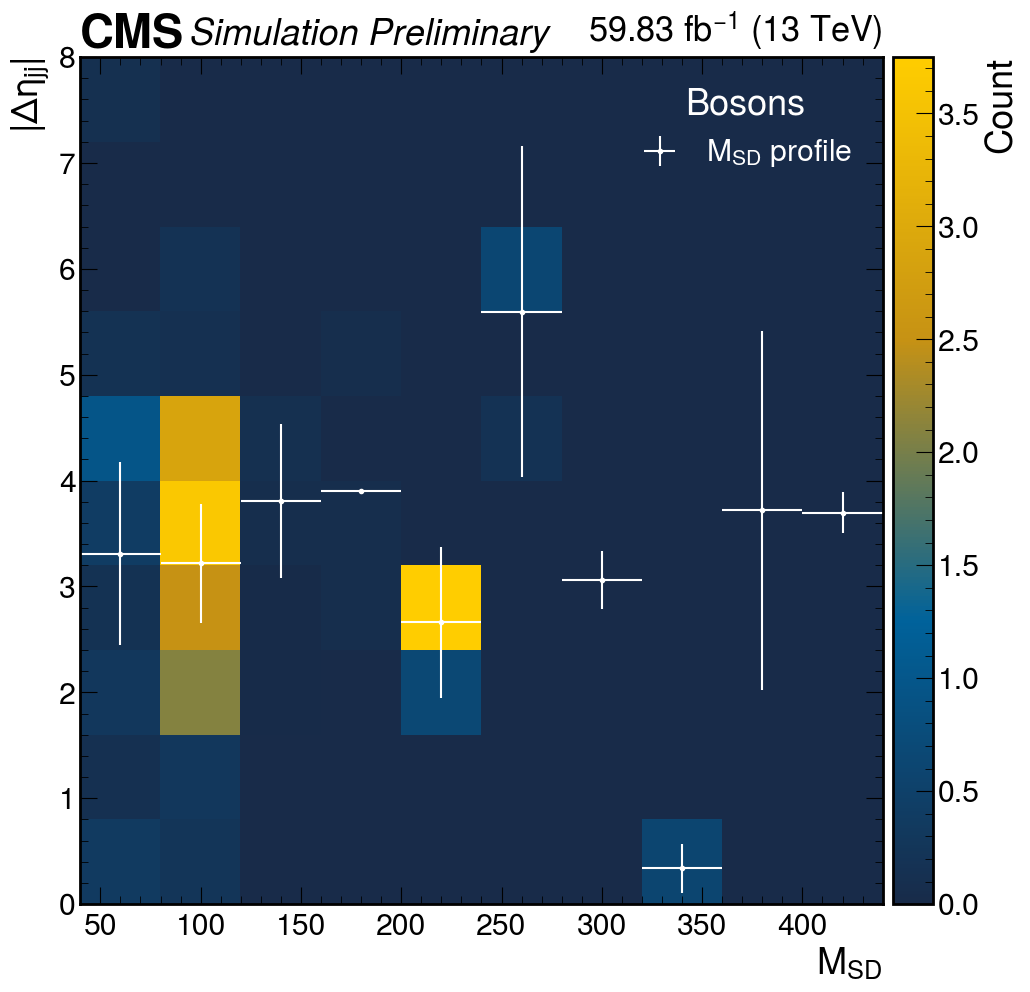

In [52]:
plot_2dcorr(sel="SR_like", sample="Bosons", rebin=4, flip=True)
for year in [2016, 2017, 2018]:
    plot_2dcorr(sel="SR_like", sample="Bosons", year=year, rebin=4, flip=True)